# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

The first project is about finding lanes in a series of images using the canny edge detector algorithm and the hough transformation to find lines. Some filtering have to be done to stabilize noisy detections. 

## Import Packages and define some functions

These functions are provided by the udacity team

In [32]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

import os
dir_list = os.listdir("test_images/")   


## Fist task: Detect lines on single images

Entry task is to detect the lane lines on single images. The detected lines by the hough transformation have to be averaged only for one frame. 


test_images/solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


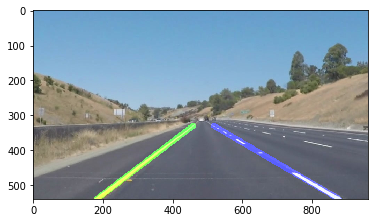

In [34]:
# Building a lane finding pipeline 
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# ---------------------- CONSTANTS -------------------------------

# define gaussian filter kernel size to reduce image noise  
kernel_size = 7

# Define our parameters for Canny 
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10   # maximum gap in pixels between connectable line segments

# ROI scalings in percent of imageg size 
# bottom left, top left, top right, bottom right 
bottom_left_roi_scale_x = 0.1241
bottom_left_roi_scale_y = 0.92

top_left_roi_scale_x = 0.40#0.46875
top_left_roi_scale_y = 0.65#0.5925

top_right_roi_scale_x = 0.6#0.5429
top_right_roi_scale_y = 0.65#0.5925

bottom_right_scale_x = 0.9075
bottom_right_scale_y = 0.92


# ---------------------- PROCESSING -------------------------------

# Loading images from directory 
for dir in dir_list: 
    print("test_images/"+dir)

    # Load from path 
    image = mpimg.imread("test_images/"+dir)
    imshape = image.shape

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    
    gray = grayscale(image)

    # Blur the image with the gaussian filter 
    # gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    gray = gaussian_blur(gray, kernel_size)

    # Calculate edges with canny algorithm 
    edges = canny(gray, low_threshold, high_threshold)

    # Because the second video have another size but the same side ratio define ROI in % of image size 
    # This would not work if image size not has same side ratio 
    #vertices = np.array([[(100,imshape[0]),(450, 320), (550, 320), (900,imshape[0])]], dtype=np.int32)
    # imshape[0] = ROWS = y 
    # imshape[1] = COLS = x 
    # np.array([[(x,y),(x,y), (x,y), (x,y), ... n-coordiantes ... ]], dtype=np.int32)
    vertices = np.array([[(imshape[1]*bottom_left_roi_scale_x,imshape[0]*bottom_left_roi_scale_y),(imshape[1]*top_left_roi_scale_x, imshape[0]*top_left_roi_scale_y), (imshape[1]*top_right_roi_scale_x,  imshape[0]*top_right_roi_scale_y), (imshape[1]*bottom_right_scale_x,imshape[0]*bottom_right_scale_y)]], dtype=np.int32)
    
    masked_edge_image = region_of_interest(edges, vertices)

    # hough_lines function does not return lines - so I call the cv2.HoughLinesP function directly to get lines g
    lines = cv2.HoughLinesP(masked_edge_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    line_image = np.zeros((masked_edge_image.shape[0], masked_edge_image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_image, lines)

    left_count = 0
    right_count = 0
    left_slope_avg = 0
    right_slope_avg = 0
    left_pos_avg = 0 
    right_pos_avg = 0

    # Tried to define integer vetors but they change their type later on!? 
    left_pos_avg = np.zeros((4,) , dtype=np.int);
    right_pos_avg = np.zeros((4,) , dtype=np.int);

    # Sorting and averaging the slope of the calculated line segments 
    for line in lines:
        for x1,y1,x2,y2 in line:
                #print('x1:', x1, ' y1:', y1, ' x2:', x2, ' y2:', y2 )
                slope = ((y2-y1)/(x2-x1))
                #print('Slope: ', slope) 
                if slope < 0: 
                    #print('right')
                    right_count = right_count + 1
                    right_slope_avg = right_slope_avg + slope
                    right_pos_avg[0] = right_pos_avg[0] + x1 + x2
                    right_pos_avg[1] = right_pos_avg[1] + y1 + y2 
                else: 
                    #print('left')
                    left_count = left_count +1 
                    left_slope_avg = left_slope_avg + slope 
                    left_pos_avg[0] = left_pos_avg[0] + x1 + x2 
                    left_pos_avg[1] = left_pos_avg[1] + y1 + y2 
    
    # Averaging slope and x,y position for one frame
    left_slope_avg = left_slope_avg / left_count
    right_slope_avg = right_slope_avg / right_count 
    left_pos_avg = left_pos_avg / (left_count*2) 
    right_pos_avg = right_pos_avg / (right_count*2)

    # Using line equation to calculate new averaged lines 
    # y = kx + d 

    # Calculating intersection of line with y axis with calculated slope 
    # and the averaged position 
    # d = y - kx 
    d_left = left_pos_avg[1] - left_slope_avg*left_pos_avg[0]
    d_right = right_pos_avg[1] - right_slope_avg*right_pos_avg[0]

    # Calculating x coordinates at max y (number of rows) --> where to start at the bottom of the image 
    # x = (y-d)/k
    left_pos_avg[3]  = imshape[0]
    right_pos_avg[3] = imshape[0]

    left_pos_avg[2] = (left_pos_avg[3] - d_left)/left_slope_avg 
    right_pos_avg[2] = (right_pos_avg[3] - d_right)/(right_slope_avg)

    # Calculating second point for line drawing - 330 height is choosen so that they do not intersect 
    # --> Where to end the line so that it looks neat 
    left_pos_avg[0] =(330 - d_left)/(left_slope_avg)
    left_pos_avg[1] = 330
    right_pos_avg[0] =(330 - d_right)/(right_slope_avg)
    right_pos_avg[1] = 330 

    # Drawing debug image 
    cv2.line(line_image, (int(right_pos_avg[0]), int(right_pos_avg[1])), (int(right_pos_avg[2]), int(right_pos_avg[3])), [0, 255, 0], 4)
    cv2.line(line_image, (int(left_pos_avg[0]), int(left_pos_avg[1])), (int(left_pos_avg[2]), int(left_pos_avg[3])), [0, 0, 255], 4)

    # Drawing output image --> make a blank copy for overlay 
    image_overlay = np.copy(image)*0 

    cv2.line(image_overlay, (int(right_pos_avg[0]), int(right_pos_avg[1])), (int(right_pos_avg[2]), int(right_pos_avg[3])), [0, 255, 0], 16)
    cv2.line(image_overlay, (int(left_pos_avg[0]), int(left_pos_avg[1])), (int(left_pos_avg[2]), int(left_pos_avg[3])), [0, 0, 255], 16)

    overlayed_image = weighted_img(image_overlay, image, 1.0, 0.8)

   
    
    # ---------------------- DEBUG -------------------------------
    
    # Debug messages - are there preprocessor directives in python!? 
    show_debug_messages = False
    
    if show_debug_messages == True: 
        print('---------------------------------------------')
        print('d_left: ', d_left)
        print('d_right: ', d_right)
        print('right count', right_count)
        print('left_count', left_count)
        print('left slope average: ', left_slope_avg)
        print('right slope average: ', right_slope_avg)
        print('right pos average x1: ', right_pos_avg[0], ' y1:',  right_pos_avg[1], 'x2: ', right_pos_avg[2], ' y2:',  right_pos_avg[3])
        print('left pos average x1: ', left_pos_avg[0], ' y1:',  left_pos_avg[1], 'x2: ', left_pos_avg[2], ' y2:',  left_pos_avg[3])

    # Show gaussian blurred imaged 
    #plt.imshow(gray, cmap='gray')
    
    # Show edged picture 
    #plt.imshow(masked_edge_image, cmap = 'gray')
    
    # Show segmented lines 
    #plt.imshow(line_image, cmap = 'gray')
    
    draw_roi = False
    
    if draw_roi == True:
        cv2.line(overlayed_image, (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(overlayed_image, (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(overlayed_image, (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), [0, 255, 0], 1)
        cv2.line(overlayed_image, (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), [0, 255, 0], 1)

    
    # Show segmented lines 
    plt.imshow(overlayed_image)
     
    # Because imread swappes R and B 
    cv2.imwrite("test_images_output/"+dir, cv2.cvtColor(overlayed_image, cv2.COLOR_RGB2BGR))


## Second task: Detect lines on a stream of images (video)

In the second task the lines have to be detected in a series of successive images. Now it makes sense to keep data throughout the frames to stabilize noisy detections of the lane marking slopes and positions. 

Importing further libraries: 

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


Redefining my constants because even on my on edge 24" monitor it is a long way to scroll up to the top. 

Defining some globals to be able to keep data throughout the frames. 

In [13]:
# ---------------------- CONSTANTS AND GLOBALS -------------------------------

# define gaussian filter kernel size to reduce image noise  
kernel_size = 7

# Define our parameters for Canny 
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10   # maximum gap in pixels between connectable line segments


# ROI scalings in percent of imageg size 
# bottom left, top left, top right, bottom right 
bottom_left_roi_scale_x = 0.1241
bottom_left_roi_scale_y = 0.92

top_left_roi_scale_x = 0.40
top_left_roi_scale_y = 0.65

top_right_roi_scale_x = 0.6
top_right_roi_scale_y = 0.65

bottom_right_scale_x = 0.9075
bottom_right_scale_y = 0.92

# Using this like a c struct 
class Statistics:
    count = 0.0
    mean = 0.0
    var = 0.0
    M2 = 0.0

filtered_d_right = Statistics()
filtered_d_left = Statistics() 

filtered_d_right.mean = 5.0
filtered_d_right.var = 9999.0

filtered_d_left.mean = 640.0
filtered_d_left.var = 9999.0
    
slope_right = Statistics() 
# Using apriori knowledge to initialize slope of line 
slope_right.mean = -0.7
slope_right.var = 0.002

slope_left = Statistics()
# Using apriori knowledge to initialize slope of line 
slope_left.mean = 0.6
slope_left.var = 0.002
    
filtered_slope_right = Statistics()
filtered_slope_right.var = 9999.0
filtered_slope_right.mean = -0.7

filtered_slope_left = Statistics()
filtered_slope_left.var = 99999.0
filtered_slope_left.mean = 0.6

plot_slope_left_filtered=[]
plot_slope_left=[]

plot_slope_right_filtered=[]
plot_slope_right=[]

plot_d_right_filtered=[]
plot_d_right=[]
plot_d_left_filtered=[]
plot_d_left=[]
frame=[]
frame_counter = 0

# Tried to define integer vetors but they change their type later on!? 
left_pos_avg = np.zeros((4,) , dtype=np.int);
right_pos_avg = np.zeros((4,) , dtype=np.int);

def update(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return (new_mean, new_var)

def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return (new_mean, new_var)


def calc_mean_welford(x, mean, M2, n): 
    n = n + 1
    delta = x - mean
    mean += delta/n
    delta2 = x - mean
    M2 += delta*delta2
    return (mean, M2, n)

def calc_var_welford(n, M2, var): 
    if n < 2: # not enough sample points to estimate variance 
        var = var # using last variance 
    else:
        var = (M2 / (n -1)) # Estimating variance
        #print('right_slope_mean: ', slope_right.mean, ' var: ', slope_right.var) 
    return (var)


def process_image(image):
    global left_pos_avg
    global right_pos_avg
    global slope_left
    global slope_right 
    global filtered_slope_left
    global filtered_slope_right
    global filtered_d_right
    global filtered_d_left 
    
    global plot_slope_left_filtered
    global plot_slope_left
    global plot_slope_right_filtered
    global plot_slope_right

    global plot_d_right_filtered
    global plot_d_right
    global plot_d_left_filtered
    global plot_d_left
    
    global frame
    global frame_counter 
    
    frame_counter = frame_counter + 1
    frame.append(frame_counter)
    
    gray = grayscale(image)

    # Blur the image with the gaussian filter 
    # gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny 
    edges = canny(gray, low_threshold, high_threshold)

    # Because the second video have another size but the same side ratio define ROI in % of image size 
    # This would not work if image size not has same side ratio 
    imshape = edges.shape
        
    vertices = np.array([[(imshape[1]*bottom_left_roi_scale_x,imshape[0]*bottom_left_roi_scale_y),(imshape[1]*top_left_roi_scale_x, imshape[0]*top_left_roi_scale_y), (imshape[1]*top_right_roi_scale_x,  imshape[0]*top_right_roi_scale_y), (imshape[1]*bottom_right_scale_x,imshape[0]*bottom_right_scale_y)]], dtype=np.int32)
    masked_edge_image = region_of_interest(edges, vertices)
       
    # hough_lines function does not return lines - so I call the cv2.HoughLinesP function directly to get lines g
    lines = cv2.HoughLinesP(masked_edge_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
   
   # Tried to define integer vetors but they change their type later on!? 
    frame_left_pos_avg = np.zeros((4,) , dtype=np.int);
    frame_right_pos_avg = np.zeros((4,) , dtype=np.int);
      
    slope_left.count = 0
    slope_right.count = 0
   
    right_slope_avg = slope_right.mean 
    left_slope_avg = slope_left.mean 

    # Sorting and averaging the slope of the calculated line segments 
    for line in lines:
        for x1,y1,x2,y2 in line:
                #print('x1:', x1, ' y1:', y1, ' x2:', x2, ' y2:', y2 )
                slope = ((y2-y1)/(x2-x1))
                #print('Slope: ', slope) 
                
                if (slope < 0.75 and slope > 0.55) or (slope < -0.55 and slope > -0.75):       
                    if slope > 0:
                        #print('right')

                        frame_right_pos_avg[0] = frame_right_pos_avg[0] + x1 + x2
                        frame_right_pos_avg[1] = frame_right_pos_avg[1] + y1 + y2 

                        slope_right.mean, slope_right.M2, slope_right.count = calc_mean_welford(slope, slope_right.mean, slope_right.M2, slope_right.count)
                    else: 
                        #print('left')
                        frame_left_pos_avg[0] = frame_left_pos_avg[0] + x1 + x2 
                        frame_left_pos_avg[1] = frame_left_pos_avg[1] + y1 + y2 

                        slope_left.mean, slope_left.M2, slope_left.count = calc_mean_welford(slope, slope_left.mean, slope_left.M2, slope_left.count)
                else: 
                    print('Outlier slope... skipping')
    print('--------------------------------------------')      
                    
    if slope_left.count > 0 and slope_right.count > 0:
        left_pos_avg = frame_left_pos_avg / (slope_left.count*2) 
        right_pos_avg = frame_right_pos_avg / (slope_right.count*2)
 
        slope_right.var = calc_var_welford(slope_right.count, slope_right.M2, slope_right.var)
        #print('right_slope_mean: ', slope_right.mean, ' var: ', slope_right.var)     

        slope_left.var = calc_var_welford(slope_left.count, slope_left.M2, slope_left.var)
        #print('left_slope_mean: ', slope_left.mean, ' var: ', slope_left.var)   
        
        right_slope_avg = slope_right.mean 
        left_slope_avg = slope_left.mean 
    else:
        print('No detections on right or left line - using previous results')
    
    #########################################################################
    # Filtering calculated slopes 
    
    # ---------------------------- Right slope  
    print('right slope average: ', slope_right.mean)
    plot_slope_right.append(slope_right.mean)
    
    filtered_slope_right.mean, filtered_slope_right.var = update(filtered_slope_right.mean,filtered_slope_right.var,slope_right.mean,0.1)#slope_right.var)
    print('update right slope average: ',  filtered_slope_right.mean)

    filtered_slope_right.mean, filtered_slope_right.var = predict(filtered_slope_right.mean,filtered_slope_right.var,0.0,0.001)#0.000001)
    print('update right slope average: ',  filtered_slope_right.mean)
    plot_slope_right_filtered.append(filtered_slope_right.mean)

    right_slope_avg = filtered_slope_right.mean
    

    # ---------------------------- left slope  
    print('left slope average: ', slope_left.mean)
    plot_slope_left.append(slope_left.mean)

    filtered_slope_left.mean, filtered_slope_left.var = update(filtered_slope_left.mean,filtered_slope_left.var,slope_left.mean,0.1)#slope_left.var)
    print('update left slope average: ',  filtered_slope_left.mean)

    filtered_slope_left.mean, filtered_slope_left.var = predict(filtered_slope_left.mean,filtered_slope_left.var,0.0,0.001)#0.000001)
    print('update left slope average: ',  filtered_slope_left.mean)
   
    left_slope_avg = filtered_slope_left.mean

    plot_slope_left_filtered.append(filtered_slope_left.mean)

    #########################################################################
    # Using line equation to calculate new lines from averaged slopes 
    # y = kx + d 

    # Calculating d translation on y axis of a line with the calculated slope running through the averages x,y coordinates 
    # d = y - kx 

    d_left = left_pos_avg[1] - left_slope_avg*left_pos_avg[0]
    d_right = right_pos_avg[1] - right_slope_avg*right_pos_avg[0]

    
    # ---------------------------- Right d  
    plot_d_right.append(d_right)
    
    filtered_d_right.mean, filtered_d_right.var = update(filtered_d_right.mean,filtered_d_right.var,d_right,10.0)
    print('update d right mean: ',  filtered_slope_right.mean)

    filtered_d_right.mean, filtered_d_right.var = predict(filtered_d_right.mean,filtered_d_right.var,0.0,2.5)
    print('predict d right mean: ',  filtered_d_right.mean)
   
    plot_d_right_filtered.append(filtered_d_right.mean)
  
    print('d_right: ', d_right)
    print('filtered_d_right: ', filtered_d_right.mean)
    
    
    # ---------------------------- Left d  
    plot_d_left.append(d_left)

    filtered_d_left.mean, filtered_d_left.var = update(filtered_d_left.mean,filtered_d_left.var,d_left,10.0)
    print('update d left mean: ',  filtered_slope_left.mean)

    filtered_d_left.mean, filtered_d_left.var = predict(filtered_d_left.mean,filtered_d_left.var,0.0,2.5)
    print('predict d left mean: ',  filtered_d_left.mean)
    
    plot_d_left_filtered.append(filtered_d_left.mean)

    print('d_left: ', d_left)
    print('filtered_d_left: ', filtered_d_left.mean)
    
    
    d_right = filtered_d_right.mean
    d_left = filtered_d_left.mean

    
    # Calculating x coordinates at max y (number of rows) --> where to start at the bottom of the image 
    # x = (y-d)/k
    left_pos_avg[3]  = imshape[0]
    right_pos_avg[3] = imshape[0]

    left_pos_avg[2] = (left_pos_avg[3] - d_left)/left_slope_avg 
    right_pos_avg[2] = (right_pos_avg[3] - d_right)/(right_slope_avg)
    
    # Calculating second point for line drawing - 330 height is choosen so that they do not intersect 
    # --> Where to end the line so that it looks neat 
    corp_height = imshape[0] * 0.61
    
    left_pos_avg[0] =(corp_height - d_left)/(left_slope_avg)
    left_pos_avg[1] = corp_height
   
    right_pos_avg[0] =(corp_height - d_right)/(right_slope_avg)
    right_pos_avg[1] = corp_height 
   
    # Drawing output image --> make a blank copy for overlay
    image_overlay = np.copy(image)*0  
    
    # Drawing calculated lines on overlay image 
    cv2.line(image_overlay, (int(right_pos_avg[0]), int(right_pos_avg[1])), (int(right_pos_avg[2]), int(right_pos_avg[3])), [0, 255, 0], 16)
    cv2.line(image_overlay, (int(left_pos_avg[0]), int(left_pos_avg[1])), (int(left_pos_avg[2]), int(left_pos_avg[3])), [0, 0, 255], 16)
        
    # Generating overlayed output image
    result = weighted_img(image_overlay, image, 1.0, 0.8)
        
    # ---------------------- DEBUG -------------------------------
    
    # Debug messages - are there preprocessor directives in python!? 
    show_debug_messages = False
    
    if show_debug_messages == True: 
        print('---------------------------------------------')
        print('d_left: ', d_left)
        print('d_right: ', d_right)
        print('right count', right_count)
        print('left_count', left_count)
        print('left slope average: ', left_slope_avg)
        print('right slope average: ', right_slope_avg)
        print('right pos average x1: ', right_pos_avg[0], ' y1:',  right_pos_avg[1], 'x2: ', right_pos_avg[2], ' y2:',  right_pos_avg[3])
        print('left pos average x1: ', left_pos_avg[0], ' y1:',  left_pos_avg[1], 'x2: ', left_pos_avg[2], ' y2:',  left_pos_avg[3])

    show_hough_line_image = False
    
    if show_hough_line_image == True:
        line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

        cv2.line(line_image, (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(line_image, (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(line_image, (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), [0, 255, 0], 1)
        cv2.line(line_image, (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), [0, 255, 0], 1)


        draw_lines(line_image, lines)
        result = weighted_img(line_image, image, 1.0, 0.8)
         
    return result

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.624510399852
update right slope average:  0.6244971535558169
update right slope average:  0.6244971535558169
left slope average:  -0.726273726274
update left slope average:  -0.7262723999880633
update left slope average:  -0.7262723999880633
update d right mean:  0.6244971535558169
predict d right mean:  3.6248438077570526
d_right:  3.62346851404
filtered_d_right:  3.6248438077570526
update d left mean:  -0.7262723999880633
predict d left mean:  648.7354299933236
d_left:  648.744166297
filtered_d_left:  648.7354299933236
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:06, 36.32it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.624510399852
update right slope average:  0.6245038096220947
update right slope average:  0.6245038096220947
left slope average:  -0.726273726274
update left slope average:  -0.7262730664297845
update left slope average:  -0.7262730664297845
update d right mean:  0.6245038096220947
predict d right mean:  3.6216627799905035
d_right:  3.61911592212
filtered_d_right:  3.6216627799905035
update d left mean:  -0.7262730664297845
predict d left mean:  648.7403764270417
d_left:  648.744336739
filtered_d_left:  648.7403764270417
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.626566966631
update right slope average:  0.6252028824314058
update right slope average:  0.6252028824314058
left slope average:  -0.714285714286
update left slope average:  -0.7222113028363204
update left

  6%|▌         | 13/222 [00:00<00:05, 38.14it/s]

 -0.7164272530215859
predict d left mean:  647.7444254280016
d_left:  646.948372252
filtered_d_left:  647.7444254280016
--------------------------------------------
right slope average:  0.620438893961
update right slope average:  0.6181547715510203
update right slope average:  0.6181547715510203
left slope average:  -0.706565656566
update left slope average:  -0.7152428374596863
update left slope average:  -0.7152428374596863
update d right mean:  0.6181547715510203
predict d right mean:  8.620663798619223
d_right:  10.8335355423
filtered_d_right:  8.620663798619223
update d left mean:  -0.7152428374596863
predict d left mean:  648.3542782457972
d_left:  649.306518696
filtered_d_left:  648.3542782457972
--------------------------------------------
right slope average:  0.626131110306
update right slope average:  0.6190730516928029
update right slope average:  0.6190730516928029
left slope average:  -0.710294117647
update left slope average:  -0.714673113324861
update left slope averag

 10%|█         | 23/222 [00:00<00:04, 41.73it/s]

--------------------------------------------
right slope average:  0.648235674878
update right slope average:  0.630869004020525
update right slope average:  0.630869004020525
left slope average:  -0.653333333333
update left slope average:  -0.6994405798750122
update left slope average:  -0.6994405798750122
update d right mean:  0.630869004020525
predict d right mean:  4.5476863482772965
d_right:  1.25233280424
filtered_d_right:  4.5476863482772965
update d left mean:  -0.6994405798750122
predict d left mean:  641.8074747858279
d_left:  638.115357308
filtered_d_left:  641.8074747858279
--------------------------------------------
right slope average:  0.653367316092
update right slope average:  0.6331124138428808
update right slope average:  0.6331124138428808
left slope average:  -0.67374005305
update left slope average:  -0.6968778623241311
update left slope average:  -0.6968778623241311
update d right mean:  0.6331124138428808
predict d right mean:  3.018336482363662
d_right:  0.630

 15%|█▍        | 33/222 [00:00<00:04, 44.40it/s]

--------------------------------------------
right slope average:  0.639255800674
update right slope average:  0.6393914649310976
update right slope average:  0.6393914649310976
left slope average:  -0.691662639007
update left slope average:  -0.6943305527068967
update left slope average:  -0.6943305527068967
update d right mean:  0.6393914649310976
predict d right mean:  -0.6503323316950085
d_right:  -1.02168113449
filtered_d_right:  -0.6503323316950085
update d left mean:  -0.6943305527068967
predict d left mean:  642.4196997166068
d_left:  641.749780827
filtered_d_left:  642.4196997166068
Outlier slope... skipping
--------------------------------------------
right slope average:  0.642186005748
update right slope average:  0.6396589989084203
update right slope average:  0.6396589989084203
left slope average:  -0.636363636364
update left slope average:  -0.6887811186940349
update left slope average:  -0.6887811186940349
update d right mean:  0.6396589989084203
predict d right mean:  

 19%|█▉        | 43/222 [00:00<00:03, 45.23it/s]

update left slope average:  -0.694528800793569
update d right mean:  0.637583174950421
predict d right mean:  -0.7453855258077243
d_right:  0.63218865797
filtered_d_right:  -0.7453855258077243
update d left mean:  -0.694528800793569
predict d left mean:  641.8265677303403
d_left:  644.030754024
filtered_d_left:  641.8265677303403
--------------------------------------------
right slope average:  0.633365124781
update right slope average:  0.6371815089926144
update right slope average:  0.6371815089926144
left slope average:  -0.712852489056
update left slope average:  -0.6962736832666916
update left slope average:  -0.6962736832666916
update d right mean:  0.6371815089926144
predict d right mean:  -0.4843691361009488
d_right:  -0.0767782585651
filtered_d_right:  -0.4843691361009488
update d left mean:  -0.6962736832666916
predict d left mean:  643.032016815075
d_left:  644.914389224
filtered_d_left:  643.032016815075
Outlier slope... skipping
Outlier slope... skipping
-----------------

 22%|██▏       | 48/222 [00:01<00:05, 32.47it/s]

--------------------------------------------
right slope average:  0.648636815611
update right slope average:  0.6439981070823503
update right slope average:  0.6439981070823503
left slope average:  -0.71349563312
update left slope average:  -0.7047902900446493
update left slope average:  -0.7047902900446493
update d right mean:  0.6439981070823503
predict d right mean:  -5.993361770203914
d_right:  -7.64550391929
filtered_d_right:  -5.993361770203914
update d left mean:  -0.7047902900446493
predict d left mean:  640.4720778423044
d_left:  643.146146014
filtered_d_left:  640.4720778423044


 23%|██▎       | 52/222 [00:01<00:05, 30.83it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.651998306912
update right slope average:  0.6447591985058925
update right slope average:  0.6447591985058925
left slope average:  -0.697553778793
update left slope average:  -0.7041018514096019
update left slope average:  -0.7041018514096019
update d right mean:  0.6447591985058925
predict d right mean:  -6.049145595190244
d_right:  -6.13625498401
filtered_d_right:  -6.049145595190244
update d left mean:  -0.7041018514096019
predict d left mean:  639.7271062909546
d_left:  638.563793869
filtered_d_left:  639.7271062909546
--------------------------------------------
right slope average:  0.647061386772
update right slope average:  0.6449782111945292
update right slope average:  0.6449782111945292
left slope average:  -0.715448738334
update left slope average:  -0.7051813079642203
update left slope average:  -0.7051813079642203
update d right mean:  0.6449782111945292

 25%|██▌       | 56/222 [00:01<00:05, 29.98it/s]

--------------------------------------------
right slope average:  0.656879388909
update right slope average:  0.6462609043318114
update right slope average:  0.6462609043318114
left slope average:  -0.690476190476
update left slope average:  -0.7000677907272495
update left slope average:  -0.7000677907272495
update d right mean:  0.6462609043318114
predict d right mean:  -6.242971515712607
d_right:  -5.13590654327
filtered_d_right:  -6.242971515712607
update d left mean:  -0.7000677907272495
predict d left mean:  638.483732259945
d_left:  637.899150447
filtered_d_left:  638.483732259945
--------------------------------------------
right slope average:  0.639143508484
update right slope average:  0.6455838465746322
update right slope average:  0.6455838465746322
left slope average:  -0.680249328276
update left slope average:  -0.6981825163902278
update left slope average:  -0.6981825163902278
update d right mean:  0.6455838465746322
predict d right mean:  -5.747250913685136
d_right:  -

 28%|██▊       | 63/222 [00:01<00:06, 26.18it/s]

--------------------------------------------
right slope average:  0.652846422486
update right slope average:  0.6477394215336804
update right slope average:  0.6477394215336804
left slope average:  -0.68519509476
update left slope average:  -0.6952123722992485
update left slope average:  -0.6952123722992485
update d right mean:  0.6477394215336804
predict d right mean:  -4.201266870179006
d_right:  -4.17131440929
filtered_d_right:  -4.201266870179006
update d left mean:  -0.6952123722992485
predict d left mean:  637.6361446068832
d_left:  637.482880703
filtered_d_left:  637.6361446068832
--------------------------------------------
right slope average:  0.657286363702
update right slope average:  0.6486475801429804
update right slope average:  0.6486475801429804
left slope average:  -0.695276744851
update left slope average:  -0.6952184957769316
update left slope average:  -0.6952184957769316
update d right mean:  0.6486475801429804
predict d right mean:  -4.284907754824768
d_right:  

 30%|██▉       | 66/222 [00:01<00:05, 26.42it/s]

--------------------------------------------
right slope average:  0.645787022422
update right slope average:  0.6491730007973995
update right slope average:  0.6491730007973995
left slope average:  -0.683537263626
update left slope average:  -0.6814015731026357
update left slope average:  -0.6814015731026357
update d right mean:  0.6491730007973995
predict d right mean:  -4.6836228087190435
d_right:  -5.04807411289
filtered_d_right:  -4.6836228087190435
update d left mean:  -0.6814015731026357
predict d left mean:  631.8206281474475
d_left:  630.147558451
filtered_d_left:  631.8206281474475
--------------------------------------------
right slope average:  0.659520419193
update right slope average:  0.6501573002814409
update right slope average:  

 31%|███       | 69/222 [00:02<00:06, 22.16it/s]

0.6501573002814409
left slope average:  -0.667735042735
update left slope average:  -0.6801015426722716
update left slope average:  -0.6801015426722716
update d right mean:  0.6501573002814409
predict d right mean:  -5.379351544667942
d_right:  -6.46576870924
filtered_d_right:  -5.379351544667942
update d left mean:  -0.6801015426722716
predict d left mean:  630.9634636683321
d_left:  629.624956065
filtered_d_left:  630.9634636683321
--------------------------------------------
right slope average:  0.657788634205
update right slope average:  0.6508832316035836
update right slope average:  0.6508832316035836
left slope average:  -0.684712983493
update left slope average:  -0.6805402063929238
update left slope average:  -0.6805402063929238
update d right mean:  0.6508832316035836
predict d right mean:  -5.333466925044566
d_right:  -5.26181566821
filtered_d_right:  -5.333466925044566
update d left mean:  -0.6805402063929238
predict d left mean:  631.0742253776169
d_left:  631.247185636
f

 32%|███▏      | 72/222 [00:02<00:06, 23.52it/s]

--------------------------------------------
right slope average:  0.657667592924
update right slope average:  0.6524287480675045
update right slope average:  0.6524287480675045
left slope average:  -0.682567385805
update left slope average:  -0.6806709777743611
update left slope average:  -0.6806709777743611
update d right mean:  0.6524287480675045
predict d right mean:  -6.039300617955274
d_right:  -7.27810012332
filtered_d_right:  -6.039300617955274
update d left mean:  -0.6806709777743611
predict d left mean:  630.5429760746964
d_left:  630.185538482
filtered_d_left:  630.5429760746964
--------------------------------------------
right slope average:  0.656935725943
update right slope average:  0.6528574744005982
update right slope average:  0.6528574744005982
left slope average:  -0.667308222823
update left slope average:  -0.6793998455237108
update left slope average:  -0.6793998455237108
update d right mean:  0.6528574744005982
predict d right mean:  -6.351636078119829
d_right: 

 34%|███▍      | 76/222 [00:02<00:06, 23.37it/s]

--------------------------------------------
right slope average:  0.665551634559
update right slope average:  0.6549009456097861
update right slope average:  0.6549009456097861
left slope average:  -0.667832167832
update left slope average:  -0.6777046400908993
update left slope average:  -0.6777046400908993
update d right mean:  0.6549009456097861
predict d right mean:  -6.910012143703354
d_right:  -6.16242201453
filtered_d_right:  -6.910012143703354
update d left mean:  -0.6777046400908993
predict d left mean:  628.0622646254831
d_left:  627.589569154
filtered_d_left:  628.0622646254831
--------------------------------------------
right slope average:  0.663573415365
update right slope average:  0.6557259138588858
update right slope average:  0.6557259138588858
left slope average:  -0.64367816092
update left slope average:  -0.674467872971984
update left slope average:  -0.674467872971984
update d right mean:  0.6557259138588858
predict d right mean:  -6.625412840827623
d_right:  -6

 36%|███▌      | 79/222 [00:02<00:06, 21.69it/s]

--------------------------------------------
right slope average:  0.665891040172
update right slope average:  0.6566928709368349
update right slope average:  0.6566928709368349
left slope average:  -0.626336898396
update left slope average:  -0.6698894166790709
update left slope average:  -0.6698894166790709
update d right mean:  0.6566928709368349
predict d right mean:  -6.88859938850888
d_right:  -7.29957908233
filtered_d_right:  -6.88859938850888
update d left mean:  -0.6698894166790709
predict d left mean:  625.6472220326744
d_left:  623.24283349
filtered_d_left:  625.6472220326744
--------------------------------------------
right slope average:  0.672124287893
update right slope average:  0.6581607835573151
update right slope average:  0.6581607835573151
left slope average:  -0.643370927318
update left slope average:  -0.6673668469552165
update left slope average:  -0.6673668469552165
update d right mean:  0.6581607835573151
predict d right mean:  -7.251949049334958
d_right:  -7

 37%|███▋      | 82/222 [00:02<00:06, 22.48it/s]

--------------------------------------------
right slope average:  0.669180564942
update right slope average:  0.6592090395692867
update right slope average:  0.6592090395692867
left slope average:  -0.633374561946
update left slope average:  -0.6641333329790506
update left slope average:  -0.6641333329790506
update d right mean:  0.6592090395692867
predict d right mean:  -7.542364834521226
d_right:  -7.99586442076
filtered_d_right:  -7.542364834521226
update d left mean:  -0.6641333329790506
predict d left mean:  623.3624804636429
d_left:  621.161466549
filtered_d_left:  623.3624804636429
--------------------------------------------
right slope average:  0.670960152301
update right slope average:  0.6603268633972953
update right slope average:  0.6603268633972953
left slope average:  -0.666823451415
update left slope average:  -0.6643892303188342
update left slope average:  -0.6643892303188342
update d right mean:  0.6603268633972953
predict d right mean:  -7.839393374790421
d_right: 

 38%|███▊      | 85/222 [00:02<00:06, 20.53it/s]

--------------------------------------------
right slope average:  0.668725459965
update right slope average:  0.6636483229440019
update right slope average:  0.6636483229440019
left slope average:  -0.660445192063
update left slope average:  -0.6616742339886784
update left slope average:  -0.6616742339886784
update d right mean:  0.6636483229440019
predict d right mean:  -9.544501636009974
d_right:  -10.5503202371
filtered_d_right:  -9.544501636009974
update d left mean:  -0.6616742339886784
predict d left mean:  622.0323537326955
d_left:  622.051715426
filtered_d_left:  622.0323537326955
--------------------------------------------
right slope average:  0.682136639319
update right slope average:  0.6654070227001109
update right slope average:  0.6654070227001109
left slope average:  -0.653235543373
update left slope average:  -0.6608715041550661
update left slope average:  -0.6608715041550661
update d right mean:  0.6654070227001109
predict d right mean:  -10.241346784608108
d_right:

 40%|███▉      | 88/222 [00:03<00:06, 20.34it/s]

-14.1354088178
filtered_d_right:  -11.761542664898366
update d left mean:  -0.6617410359024436
predict d left mean:  621.7663168128062
d_left:  621.508821525
filtered_d_left:  621.7663168128062
--------------------------------------------
right slope average:  0.672183501153
update right slope average:  0.6677130521068635
update right slope average:  0.6677130521068635
left slope average:  -0.634419381788
update left slope average:  -0.6591420655840977
update left slope average:  -0.6591420655840977
update d right mean:  0.6677130521068635
predict d right mean:  -12.04493817627764
d_right:  -12.4874752342
filtered_d_right:  -12.04493817627764
update d left mean:  -0.6591420655840977
predict d left mean:  621.1673700582065
d_left:  620.232083069
filtered_d_left:  621.1673700582065
--------------------------------------------
right slope average:  0.687029479392
update right slope average:  0.6695505258045308
update right slope average:  0.6695505258045308
left slope average:  -0.6125
up

 41%|████      | 91/222 [00:03<00:06, 18.75it/s]


update d left mean:  -0.654008319211245
predict d left mean:  620.721916423251
d_left:  621.278438761
filtered_d_left:  620.721916423251
--------------------------------------------
right slope average:  0.685636029596
update right slope average:  0.6742915340251023
update right slope average:  0.6742915340251023
left slope average:  -0.639165409754
update left slope average:  -0.6525963885822091
update left slope average:  -0.6525963885822091
update d right mean:  0.6742915340251023
predict d right mean:  -14.370078903692377
d_right:  -16.2660761105
filtered_d_right:  -14.370078903692377
update d left mean:  -0.6525963885822091
predict d left mean:  621.1955902983548
d_left:  621.93525707
filtered_d_left:  621.1955902983548
--------------------------------------------
right slope average:  0.68757995955
update right slope average:  0.6755555944846874
update right slope average:  0.6755555944846874
left slope average:  -0.646103896104
update left slope average:  -0.6519787907328356
up

 42%|████▏     | 93/222 [00:03<00:09, 13.31it/s]

--------------------------------------------
right slope average:  0.692472201307
update right slope average:  0.6771647854077888
update right slope average:  0.6771647854077888
left slope average:  -0.631912082148
update left slope average:  -0.6500699466217764
update left slope average:  -0.6500699466217764
update d right mean:  0.6771647854077888
predict d right mean:  -16.66474312638023
d_right:  -18.7059231545
filtered_d_right:  -16.66474312638023
update d left mean:  -0.6500699466217764
predict d left mean:  620.2323918332185
d_left:  619.505319888
filtered_d_left:  620.2323918332185
--------------------------------------------
right slope average:  0.692866086982
update right slope average:  0.6786583705094241
update right slope average:  0.6786583705094241
left slope average:  -0.646153846154
update left slope average:  -0.6496974278667019
update left slope average:  -0.6496974278667019
update d right mean:  0.6786583705094241
predict d right mean:  -18.00378155553318
d_right: 

 43%|████▎     | 95/222 [00:03<00:08, 14.55it/s]

620.1845465073956
--------------------------------------------
right slope average:  0.70061217124
update right slope average:  0.6807467241075427
update right slope average:  0.6807467241075427
left slope average:  -0.656651150849
update left slope average:  -0.6503589002281275
update left slope average:  -0.6503589002281275
update d right mean:  0.6807467241075427
predict d right mean:  -19.501008232594945
d_right:  -21.8390067616
filtered_d_right:  -19.501008232594945
update d left mean:  -0.6503589002281275
predict d left mean:  620.3001653292458
d_left:  620.480710226
filtered_d_left:  620.3001653292458
--------------------------------------------
right slope average:  0.69366590875
update right slope average:  0.6819756605466534
update right slope average:  0.6819756605466534
left slope average:  -0.659263777232
update left slope average:  -0.6512059759638508
update left slope average:  -0.6512059759638508
update d right mean:  0.6819756605466534
predict d right mean:  -21.313667

 44%|████▎     | 97/222 [00:03<00:08, 14.60it/s]

-24.1442308847
filtered_d_right:  -21.313667580802136
update d left mean:  -0.6512059759638508
predict d left mean:  620.5798042979401
d_left:  621.016475316
filtered_d_left:  620.5798042979401
--------------------------------------------
right slope average:  0.696347055175
update right slope average:  0.6833427383466519
update right slope average:  0.6833427383466519
left slope average:  -0.641565754507
update left slope average:  -0.6502889506450635
update left slope average:  -0.6502889506450635
update d right mean:  0.6833427383466519
predict d right mean:  -23.099994055624048
d_right:  -25.889437187
filtered_d_right:  -23.099994055624048
update d left mean:  -0.6502889506450635
predict d left mean:  620.0167660325278
d_left:  619.137552045
filtered_d_left:  620.0167660325278
--------------------------------------------
right slope average:  0.709985888295
update right slope average:  0.6858771659176516
update right slope average:  0.6858771659176516
left slope average:  -0.664626

 45%|████▌     | 100/222 [00:03<00:08, 14.59it/s]

--------------------------------------------
right slope average:  0.691502207499
update right slope average:  0.6872631586273477
update right slope average:  0.6872631586273477
left slope average:  -0.6
update left slope average:  -0.6475263554843206
update left slope average:  -0.6475263554843206
update d right mean:  0.6872631586273477
predict d right mean:  -28.132460685019492
d_right:  -30.088439064
filtered_d_right:  -28.132460685019492
update d left mean:  -0.6475263554843206
predict d left mean:  618.0247858774767
d_left:  615.056041062
filtered_d_left:  618.0247858774767


 46%|████▋     | 103/222 [00:04<00:07, 16.69it/s]

--------------------------------------------
right slope average:  0.694093801032
update right slope average:  0.6879129229546286
update right slope average:  0.6879129229546286
left slope average:  -0.648148148148
update left slope average:  -0.6475855034630924
update left slope average:  -0.6475855034630924
update d right mean:  0.6879129229546286
predict d right mean:  -27.590622560550724
d_right:  -26.7445137132
filtered_d_right:  -27.590622560550724
update d left mean:  -0.6475855034630924
predict d left mean:  618.6358609776736
d_left:  619.590087019
filtered_d_left:  618.6358609776736
--------------------------------------------
right slope average:  0.691779354341
update right slope average:  0.6882807169393281
update right slope average:  0.6882807169393281
left slope average:  -0.670902574128
update left slope average:  -0.6498035379951173
update left slope average:  -0.6498035379951173
update d right mean:  0.6882807169393281
predict d right mean:  -27.786447219211674
d_righ

 48%|████▊     | 107/222 [00:04<00:05, 19.55it/s]

--------------------------------------------
right slope average:  0.684498084524
update right slope average:  0.6880016170438201
update right slope average:  0.6880016170438201
left slope average:  -0.675036185934
update left slope average:  -0.6559377331862208
update left slope average:  -0.6559377331862208
update d right mean:  0.6880016170438201
predict d right mean:  -30.330572712835476
d_right:  -31.5098997515
filtered_d_right:  -30.330572712835476
update d left mean:  -0.6559377331862208
predict d left mean:  624.838847060614
d_left:  626.294362925
filtered_d_left:  624.838847060614


 50%|████▉     | 110/222 [00:04<00:05, 19.76it/s]

--------------------------------------------
right slope average:  0.696395803575
update right slope average:  0.6888001133830727
update right slope average:  0.6888001133830727
left slope average:  -0.685988183939
update left slope average:  -0.6587962799710294
update left slope average:  -0.6587962799710294
update d right mean:  0.6888001133830727
predict d right mean:  -30.468574811246896
d_right:  -30.6840723762
filtered_d_right:  -30.468574811246896
update d left mean:  -0.6587962799710294
predict d left mean:  626.1666560833208
d_left:  628.240099998
filtered_d_left:  626.1666560833208
--------------------------------------------
right slope average:  0.688459212082
update right slope average:  0.6887676851733517
update right slope average:  0.6887676851733517
left slope average:  -0.676103251427
update left slope average:  -0.6604426042811724
update left slope average:  -0.6604426042811724
update d right mean:  0.6887676851733517
predict d right mean:  -30.644680503522626
d_righ

 52%|█████▏    | 115/222 [00:04<00:06, 17.69it/s]

--------------------------------------------
right slope average:  0.68459650158
update right slope average:  0.6881253712629872
update right slope average:  0.6881253712629872
left slope average:  -0.666086956522
update left slope average:  -0.661975160735094
update left slope average:  -0.661975160735094
update d right mean:  0.6881253712629872
predict d right mean:  -31.121658562003482
d_right:  -31.4181158012
filtered_d_right:  -31.121658562003482
update d left mean:  -0.661975160735094
predict d left mean:  626.2530957202523
d_left:  626.064635597
filtered_d_left:  626.2530957202523
--------------------------------------------
right slope average:  0.686223342515
update right slope average:  0.68794444092668
update right slope average:  0.68794444092668
left slope average:  -0.700320512821
update left slope average:  -0.6656227593610232
update left slope average:  -0.6656227593610232
update d right mean:  0.68794444092668
predict d right mean:  -31.35099490644996
d_right:  -31.709

 55%|█████▍    | 121/222 [00:04<00:04, 21.20it/s]

0.6851440266109365
left slope average:  -0.675272402017
update left slope average:  -0.6729223470468771
update left slope average:  -0.6729223470468771
update d right mean:  0.6851440266109365
predict d right mean:  -31.747226509980667
d_right:  -31.5717734498
filtered_d_right:  -31.747226509980667
update d left mean:  -0.6729223470468771
predict d left mean:  628.0921140575311
d_left:  628.281086635
filtered_d_left:  628.0921140575311
--------------------------------------------
right slope average:  0.661389236942
update right slope average:  0.6828843540969632
update right slope average:  0.6828843540969632
left slope average:  -0.6875
update left slope average:  -0.6743090451467211
update left slope average:  -0.6743090451467211
update d right mean:  0.6828843540969632
predict d right mean:  -31.36710986945158
d_right:  -30.7735376602
filtered_d_right:  -31.36710986945158
update d left mean:  -0.6743090451467211
predict d left mean:  628.2133798758442
d_left:  628.402742856
filtere

 56%|█████▌    | 124/222 [00:04<00:04, 21.84it/s]

--------------------------------------------
right slope average:  0.647748253582
update right slope average:  0.6739357177543803
update right slope average:  0.6739357177543803
left slope average:  -0.676124688282
update left slope average:  -0.6749910652627105
update left slope average:  -0.6749910652627105
update d right mean:  0.6739357177543803
predict d right mean:  -26.57138662987319
d_right:  -23.4693445006
filtered_d_right:  -26.57138662987319
update d left mean:  -0.6749910652627105
predict d left mean:  631.6206917113286
d_left:  633.429999167
filtered_d_left:  631.6206917113286
--------------------------------------------
right slope average:  0.655349856117
update right slope average:  0.6721677391163068
update right slope average:  0.6721677391163068
left slope average:  -0.664496409761
update left slope average:  -0.6739927619769095
update left slope average:  -0.6739927619769095
update d right mean:  0.6721677391163068
predict d right mean:  -25.482321394421245
d_right:

 59%|█████▊    | 130/222 [00:05<00:04, 21.02it/s]

0.6627779076370033
update right slope average:  0.6627779076370033
left slope average:  -0.666834677419
update left slope average:  -0.670849949345543
update left slope average:  -0.670849949345543
update d right mean:  0.6627779076370033
predict d right mean:  -21.048330879768557
d_right:  -20.4029767257
filtered_d_right:  -21.048330879768557
update d left mean:  -0.670849949345543
predict d left mean:  632.0492490670944
d_left:  632.527943998
filtered_d_left:  632.0492490670944
--------------------------------------------
right slope average:  0.637165917488
update right slope average:  0.6603415690724956
update right slope average:  0.6603415690724956
left slope average:  -0.685714285714
update left slope average:  -0.6722639181828114
update left slope average:  -0.6722639181828114
update d right mean:  0.6603415690724956
predict d right mean:  -19.84793107725356
d_right:  -17.9734433891
filtered_d_right:  -19.84793107725356
update d left mean:  -0.6722639181828114
predict d left me

 60%|█████▉    | 133/222 [00:05<00:04, 21.30it/s]

--------------------------------------------
right slope average:  0.631056145634
update right slope average:  0.6536646808676397
update right slope average:  0.6536646808676397
left slope average:  -0.698383356471
update left slope average:  -0.6798968124270164
update left slope average:  -0.6798968124270164
update d right mean:  0.6536646808676397
predict d right mean:  -15.303518507910285
d_right:  -13.4381923513
filtered_d_right:  -15.303518507910285
update d left mean:  -0.6798968124270164
predict d left mean:  637.2242643693455
d_left:  639.422457219
filtered_d_left:  637.2242643693455
--------------------------------------------
right slope average:  0.63620526599
update right slope average:  0.6520038553897143
update right slope average:  0.6520038553897143
left slope average:  -0.713958135443
update left slope average:  -0.6831368931211949
update left slope average:  -0.6831368931211949
update d right mean:  0.6520038553897143
predict d right mean:  -13.522066972105367
d_right

 63%|██████▎   | 139/222 [00:05<00:04, 20.58it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.636214233787
update right slope average:  0.6470288656847865
update right slope average:  0.6470288656847865
left slope average:  -0.703921568627
update left slope average:  -0.6920077428577371
update left slope average:  -0.6920077428577371
update d right mean:  0.6470288656847865
predict d right mean:  -11.599818233365605
d_right:  -11.4647093337
filtered_d_right:  -11.599818233365605
update d left mean:  -0.6920077428577371
predict d left mean:  642.4357039923514
d_left:  642.197515529
filtered_d_left:  642.4357039923514
--------------------------------------------
right slope average:  0.630898950191
update right slope average:  0.6454945087320089
update right slope average:  0.6454945087320089
left slope average:  -0.698051948052
update left slope average:  -0.6925826974052236
update left slope average:  -0.6925826974052236
update d right mean:  0.6454945087320089
predict d right mean:  

 65%|██████▌   | 145/222 [00:05<00:03, 22.67it/s]

--------------------------------------------
right slope average:  0.638760180497
update right slope average:  0.6425459272221853
update right slope average:  0.6425459272221853
left slope average:  -0.715892815893
update left slope average:  -0.6958977048225483
update left slope average:  -0.6958977048225483
update d right mean:  0.6425459272221853
predict d right mean:  -7.355226129025441
d_right:  -5.68144389893
filtered_d_right:  -7.355226129025441
update d left mean:  -0.6958977048225483
predict d left mean:  643.315809799717
d_left:  645.571033847
filtered_d_left:  643.315809799717
--------------------------------------------
right slope average:  0.644987304805
update right slope average:  0.6427781630742697
update right slope average:  0.6427781630742697
left slope average:  -0.719104770531
update left slope average:  -0.6981052751373155
update left slope average:  -0.6981052751373155
update d right mean:  0.6427781630742697
predict d right mean:  -5.833022831029258
d_right:  -

 68%|██████▊   | 151/222 [00:06<00:02, 24.89it/s]

d_left:  648.121344481
filtered_d_left:  646.9850872365749
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.637720380497
update right slope average:  0.6399069071682342
update right slope average:  0.6399069071682342
left slope average:  -0.716472016858
update left slope average:  -0.7025405920828665
update left slope average:  -0.7025405920828665
update d right mean:  0.6399069071682342
predict d right mean:  -6.385815465280757
d_right:  -6.50138576135
filtered_d_right:  -6.385815465280757
update d left mean:  -0.7025405920828665
predict d left mean:  645.9335746740405
d_left:  644.291582274
filtered_d_left:  645.9335746740405
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.622536517778
update right slope average:  0.6382545502328522
update right slope average:  0.6382545502328522
left slope average:  -0.683625730994
update left slope average

 71%|███████   | 157/222 [00:06<00:02, 24.49it/s]

--------------------------------------------
right slope average:  0.635570320944
update right slope average:  0.6351957295685476
update right slope average:  0.6351957295685476
left slope average:  -0.737148962149
update left slope average:  -0.7092840697041074
update left slope average:  -0.7092840697041074
update d right mean:  0.6351957295685476
predict d right mean:  -5.596837373627797
d_right:  -4.72492439822
filtered_d_right:  -5.596837373627797
update d left mean:  -0.7092840697041074
predict d left mean:  650.1402774132636
d_left:  652.667992536
filtered_d_left:  650.1402774132636
--------------------------------------------
right slope average:  0.635350071708
update right slope average:  0.6352104113524831
update right slope average:  0.6352104113524831
left slope average:  -0.718085106383
update left slope average:  -0.7101212676314621
update left slope average:  -0.7101212676314621
update d right mean:  0.6352104113524831
predict d right mean:  -5.658053565767604
d_right: 

 73%|███████▎  | 161/222 [00:06<00:02, 26.44it/s]


Outlier slope... skipping
--------------------------------------------
right slope average:  0.618631182347
update right slope average:  0.6321237267924386
update right slope average:  0.6321237267924386
left slope average:  -0.723560354374
update left slope average:  -0.7116108255257795
update left slope average:  -0.7116108255257795
update d right mean:  0.6321237267924386
predict d right mean:  -6.450932074869229
d_right:  -6.47108254112
filtered_d_right:  -6.450932074869229
update d left mean:  -0.7116108255257795
predict d left mean:  648.7700548196354
d_left:  648.345592986
filtered_d_left:  648.7700548196354
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.616014526815
update right slope average:  0.6305913404015878
update right slope average:  0.6305913404015878
left slope average:  -0.677827380952
update left slope average:  -0.7083971779967725
update left slope average:  -0.7083971779967725
update d righ

 75%|███████▌  | 167/222 [00:06<00:02, 24.75it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.582956919175
update right slope average:  0.6187665415933562
update right slope average:  0.6187665415933562
left slope average:  -0.741935483871
update left slope average:  -0.7138899503946836
update left slope average:  -0.7138899503946836
update d right mean:  0.6187665415933562
predict d right mean:  -2.012560271982514
d_right:  0.136828285254
filtered_d_right:  -2.012560271982514
update d left mean:  -0.7138899503946836
predict d left mean:  655.9069477568921
d_left:  660.424006522
filtered_d_left:  655.9069477568921
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.589611440559
update right slope average:  0.6159931648823331
update right slope average:  0.6159931648823331
left slope average:  -0.675
update left slope average:  -0.7101905468978749
update left slope average:  -0.71019054689787

 77%|███████▋  | 170/222 [00:06<00:02, 21.75it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.589101392625
update right slope average:  0.6071457419272591
update right slope average:  0.6071457419272591
left slope average:  -0.746697546749
update left slope average:  -0.7200797195207548
update left slope average:  -0.7200797195207548
update d right mean:  0.6071457419272591
predict d right mean:  7.478042059812453
d_right:  11.1721480137
filtered_d_right:  7.478042059812453
update d left mean:  -0.7200797195207548
predict d left mean:  657.5499164198698
d_left:  659.732361326
filtered_d_left:  657.5499164198698
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.588988024957
update right slope average:  0.6054184905172938
update right slope average:  0.6054184905172938
left slope average:  -0.735294117647
update left slope average:  -0.7215269879553781
update left s

 79%|███████▉  | 176/222 [00:07<00:02, 21.12it/s]

update d right mean:  0.6009209522784476
predict d right mean:  12.63511754473561
d_right:  13.0219561926
filtered_d_right:  12.63511754473561
update d left mean:  -0.7224426466868024
predict d left mean:  661.7048759556914
d_left:  661.677249755
filtered_d_left:  661.7048759556914
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.589267016775
update right slope average:  0.5998123725729759
update right slope average:  0.5998123725729759
left slope average:  -0.721505376344
update left slope average:  -0.7223534889185843
update left slope average:  -0.7223534889185843
update d right mean:  0.5998123725729759
predict d right mean:  12.863248012499406
d_right:  13.2194857861
filtered_d_right:  12.863248012499406
update d left mean:  -0.7223534889185843
predict d left mean:  661.6888660337975
d_left:  661.663865695
filtered_d_left:  661.6888660337975
Outlier slope... skipping
Outlier 

 81%|████████  | 179/222 [00:07<00:02, 18.75it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.590142065142
update right slope average:  0.5973861191984143
update right slope average:  0.5973861191984143
left slope average:  -0.721505376344
update left slope average:  -0.7221337520462945
update left slope average:  -0.7221337520462945
update d right mean:  0.5973861191984143
predict d right mean:  13.363511147888465
d_right:  13.6089173117
filtered_d_right:  13.363511147888465
update d left mean:  -0.7221337520462945
predict d left mean:  661.6494028246838
d_left:  661.630876009
filtered_d_left:  661.6494028246838
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.592009064669
update right slope average:  0.5968746273058

 83%|████████▎ | 184/222 [00:07<00:02, 18.76it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.591495766971
update right slope average:  0.5953480267117875
update right slope average:  0.5953480267117875
left slope average:  -0.721505376344
update left slope average:  -0.721926659302834
update left slope average:  -0.721926659302834
update d right mean:  0.5953480267117875
predict d right mean:  13.784753204814471
d_right:  13.9155754552
filtered_d_right:  13.784753204814471
update d left mean:  -0.721926659302834
predict d left mean:  661.6122033772155
d_left:  661.599780013
filtered_d_left:  661.6122033772155
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.602128158754
update right slope av

 84%|████████▍ | 187/222 [00:07<00:01, 19.74it/s]

--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.599493064517
update right slope average:  0.5970183553704674
update right slope average:  0.5970183553704674
left slope average:  -0.721505376344
update left slope average:  -0.7217878177731666
update left slope average:  -0.7217878177731666
update d right mean:  0.5970183553704674
predict d right mean:  13.439268607655373
d_right:  13.3553140996
filtered_d_right:  13.439268607655373
update d left mean:  -0.7217878177731666
predict d left mean:  661.5872598656564
d_left:  661.57892977
filtered_d_left:  661.5872598656564
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.605713762432
update right slope average:  0.5978455052886742
update right slope average:  0.5978455052886742
left slope average:  -0.721505376344
update left slop

 86%|████████▌ | 190/222 [00:08<00:01, 17.84it/s]

 14.029082474440289
update d left mean:  -0.7216767213834708
predict d left mean:  661.5672986826651
d_left:  661.562244649
filtered_d_left:  661.5672986826651
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.57654598054
update right slope average:  0.592489477441924
update right slope average:  0.592489477441924
left slope average:  -0.721505376344
update left slope average:  -0.7216604221999691
update left slope average:  -0.7216604221999691
update d right mean:  0.592489477441924
predict d right mean:  14.376378759524638
d_right:  14.9187002504
filtered_d_right:  14.376378759524638
update d left mean:  -0.7216604221999691
predict d left mean:  661.5643699703546
d_left:  661.559796631
filtered_d_left:  661.5643699703546
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
-------------------------------

 88%|████████▊ | 195/222 [00:08<00:01, 19.49it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.585108409174
update right slope average:  0.5907371512820226
update right slope average:  0.5907371512820226
left slope average:  -0.734953703704
update left slope average:  -0.7240691793401923
update left slope average:  -0.7240691793401923
update d right mean:  0.5907371512820226
predict d right mean:  14.491474422727926
d_right:  14.6836487738
filtered_d_right:  14.491474422727926
update d left mean:  -0.7240691793401923
predict d left mean:  660.3943718417089
d_left:  660.713545937
filtered_d_left:  660.3943718417089
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.58948

 90%|█████████ | 200/222 [00:08<00:01, 16.95it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.584719457171
update right slope average:  0.5881775146297012
update right slope average:  0.5881775146297012
left slope average:  -0.721362229102
update left slope average:  -0.7248291266837409
update left slope average:  -0.7248291266837409
update d right mean:  0.5881775146297012
predict d right mean:  17.462229706137222
d_right:  17.5797159986
filtered_d_right:  17.462229706137222
update d left mean:  -0.7248291266837409
predict d left mean:  661.3129109781506
d_left:  661.211202895
filtered_d_left:  661.3129109781506
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.584232219669
update right slope average:  0.587802218754384
update right slope average:  0.587802218754384
le

 93%|█████████▎| 206/222 [00:08<00:00, 20.58it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.584691613176
update right slope average:  0.5873346409635263
update right slope average:  0.5873346409635263
left slope average:  -0.71198156682
update left slope average:  -0.7222311044417435
update left slope average:  -0.7222311044417435
update d right mean:  0.5873346409635263
predict d right mean:  19.255961376831138
d_right:  19.3453769929
filtered_d_right:  19.255961376831138
update d left mean:  -0.7222311044417435
predict d left mean:  659.8441031384378
d_left:  659.543848072
filtered_d_left:  659.8441031384378
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.579942597015
update right slope average:  0.5866314733596832
update right slope aver

 95%|█████████▌| 212/222 [00:09<00:00, 23.78it/s]


Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.566812953015
update right slope average:  0.5823601037046324
update right slope average:  0.5823601037046324
left slope average:  -0.742424242424
update left slope average:  -0.7231275147447822
update left slope average:  -0.7231275147447822
update d right mean:  0.5823601037046324
predict d right mean:  20.546999581873987
d_right:  19.980226629
filtered_d_right:  20.546999581873987
update d left mean:  -0.7231275147447822
predict d left mean:  660.19414022875
d_left:  661.682536378
filtered_d_left:  660.19414022875
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.571651565729
update right slope average:  0.5813414548652437
update right slope average:  0.5813414548652437
left slope av

 97%|█████████▋| 215/222 [00:09<00:00, 22.31it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.565131436377
update right slope average:  0.5741326677349223
update right slope average:  0.5741326677349223
left slope average:  -0.742424242424
update left slope average:  -0.7328389788927383
update left slope average:  -0.7328389788927383
update d right mean:  0.5741326677349223
predict d right mean:  22.256620149314823
d_right:  22.5649061082
filtered_d_right:  22.256620149314823
update d left mean:  -0.7328389788927383
predict d left mean:  661.922439486256
d_left:  662.201398043
filtered_d_left:  661.922439486256
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.560755684801
update right slope average:  0.5728601832771517
update right slope avera

100%|█████████▉| 221/222 [00:09<00:00, 23.49it/s]


 -0.7359979783807167
update left slope average:  -0.7359979783807167
update d right mean:  0.5708300680384232
predict d right mean:  22.947209871039544
d_right:  23.2479282771
filtered_d_right:  22.947209871039544
update d left mean:  -0.7359979783807167
predict d left mean:  662.4814670551525
d_left:  662.667948034
filtered_d_left:  662.4814670551525
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.560444613107
update right slope average:  0.5698421524484606
update right slope average:  0.5698421524484606
left slope average:  -0.746031746032
update left slope average:  -0.7369524397456111
update left slope average:  -0.7369524397456111
update d right mean:  0.5698421524484606
predict d right mean:  26.452347206492743
d_right:  31.925804272
filtered_d_right:  26.452347206492743
update d left mean:  -0.7369524397456111
predict d left mean:  663.8355474241873
d_left:  665.950015433
filtered_

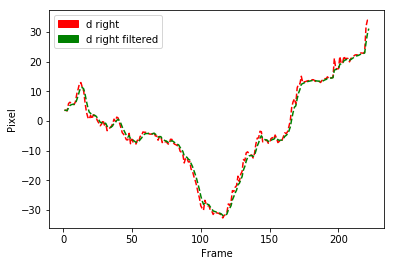

In [15]:
red_patch = mpatches.Patch(color='red', label='d right')
green_patch = mpatches.Patch(color='green', label='d right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_right, 'r--', frame, plot_d_right_filtered, 'g--')
plt.show()

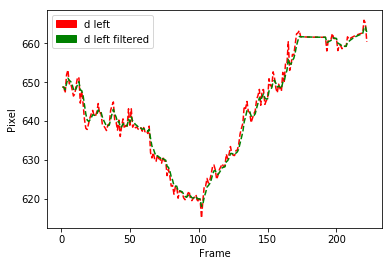

In [16]:
red_patch = mpatches.Patch(color='red', label='d left')
green_patch = mpatches.Patch(color='green', label='d left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_left, 'r--', frame, plot_d_left_filtered, 'g--')
plt.show()

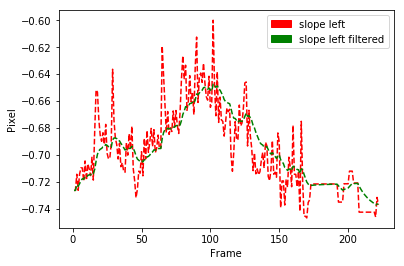

In [17]:
red_patch = mpatches.Patch(color='red', label='slope left')
green_patch = mpatches.Patch(color='green', label='slope left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_left, 'r--', frame, plot_slope_left_filtered, 'g--')
plt.show()

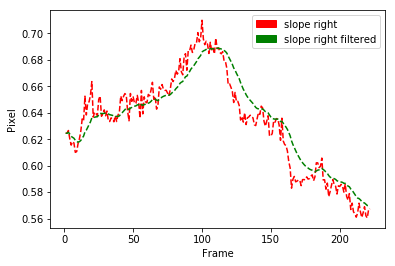

In [18]:
red_patch = mpatches.Patch(color='red', label='slope right')
green_patch = mpatches.Patch(color='green', label='slope right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_right, 'r--', frame, plot_slope_right_filtered, 'g--')
plt.show()

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,3)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

--------------------------------------------
right slope average:  0.682157650266
update right slope average:  0.5801000051283784
update right slope average:  0.5801000051283784
left slope average:  -0.613484295937
update left slope average:  -0.7247719220362957
update left slope average:  -0.7247719220362957
update d right mean:  0.5801000051283784
predict d right mean:  36.3808871147125
d_right:  44.4951798383
filtered_d_right:  36.3808871147125
update d left mean:  -0.7247719220362957
predict d left mean:  654.0965578547683
d_left:  640.491208199
filtered_d_left:  654.0965578547683
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:21, 31.55it/s]

--------------------------------------------
right slope average:  0.682157650266
update right slope average:  0.5898082306587948
update right slope average:  0.5898082306587948
left slope average:  -0.613484295937
update left slope average:  -0.714185695287132
update left slope average:  -0.714185695287132
update d right mean:  0.5898082306587948
predict d right mean:  36.96574213591714
d_right:  37.8790241394
filtered_d_right:  36.96574213591714
update d left mean:  -0.714185695287132
predict d left mean:  647.5500177670633
d_left:  637.327249679
filtered_d_left:  647.5500177670633
--------------------------------------------
right slope average:  0.672080254516
update right slope average:  0.5976343505086934
update right slope average:  0.5976343505086934
left slope average:  -0.61088398923
update left slope average:  -0.7043591285588008
update left slope average:  -0.7043591285588008
update d right mean:  0.5976343505086934
predict d right mean:  34.47475986948433
d_right:  30.5849

  2%|▏         | 12/682 [00:00<00:19, 34.35it/s]

--------------------------------------------
right slope average:  0.635964912281
update right slope average:  0.6252016730401814
update right slope average:  0.6252016730401814
left slope average:  -0.643049525249
update left slope average:  -0.6718677736923457
update left slope average:  -0.6718677736923457
update d right mean:  0.6252016730401814
predict d right mean:  10.592212455960473
d_right:  6.18716020553
filtered_d_right:  10.592212455960473
update d left mean:  -0.6718677736923457
predict d left mean:  631.5157826973419
d_left:  630.441009922
filtered_d_left:  631.5157826973419
--------------------------------------------
right slope average:  0.667279488791
update right slope average:  0.6292043219802625
update right slope average:  0.6292043219802625
left slope average:  -0.641951777904
update left slope average:  -0.6690220169272647
update left slope average:  -0.6690220169272647
update d right mean:  0.6292043219802625
predict d right mean:  8.118915739039442
d_right:  4

  3%|▎         | 20/682 [00:00<00:18, 34.92it/s]

630.5717961102225
--------------------------------------------
right slope average:  0.604726867336
update right slope average:  0.6351158203360922
update right slope average:  0.6351158203360922
left slope average:  -0.680304538348
update left slope average:  -0.668168676999062
update left slope average:  -0.668168676999062
update d right mean:  0.6351158203360922
predict d right mean:  -2.3488715169550374
d_right:  -2.62442564138
filtered_d_right:  -2.3488715169550374
update d left mean:  -0.668168676999062
predict d left mean:  631.5213122125595
d_left:  633.004031753
filtered_d_left:  631.5213122125595
--------------------------------------------
right slope average:  0.592809364548
update right slope average:  0.6310914220303638
update right slope average:  0.6310914220303638
left slope average:  -0.685029694772
update left slope average:  -0.6697725799990965
update left slope average:  -0.6697725799990965
update d right mean:  0.6310914220303638
predict d right mean:  -1.44683618

  4%|▍         | 29/682 [00:00<00:17, 38.37it/s]

--------------------------------------------
right slope average:  0.639077532541
update right slope average:  0.6268334958281038
update right slope average:  0.6268334958281038
left slope average:  -0.68687858741
update left slope average:  -0.6775141920473767
update left slope average:  -0.6775141920473767
update d right mean:  0.6268334958281038
predict d right mean:  2.2239161208416998
d_right:  2.19293413575
filtered_d_right:  2.2239161208416998
update d left mean:  -0.6775141920473767
predict d left mean:  633.8601386145871
d_left:  633.885162907
filtered_d_left:  633.8601386145871
--------------------------------------------
right slope average:  0.63631503558
update right slope average:  0.6277354265572004
update right slope average:  0.6277354265572004
left slope average:  -0.687578649524
update left slope average:  -0.678471572779519
update left slope average:  -0.678471572779519
update d right mean:  0.6277354265572004
predict d right mean:  2.492223318954065
d_right:  2.911

  6%|▌         | 40/682 [00:01<00:15, 42.79it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.576074332172
update right slope average:  0.6142937670486075
update right slope average:  0.6142937670486075
left slope average:  -0.714026572378
update left slope average:  -0.694360991032322
update left slope average:  -0.694360991032322
update d right mean:  0.6142937670486075
predict d right mean:  3.0426155094404272
d_right:  4.48301528684
filtered_d_right:  3.0426155094404272
update d left mean:  -0.694360991032322
predict d left mean:  640.5207069523184
d_left:  641.17737517
filtered_d_left:  640.5207069523184
Outlier slope... skipping
--------------------------------------------
right slope average:  0.577872340426
update right slope average:  0.6108291816829603
update right slope average:  0.6108291816829603
left slope average:  -0.717382073351
update left slope average:  -0.6965508696916066
update left slope average:  -0.6965508696

  7%|▋         | 45/682 [00:01<00:15, 41.05it/s]


left slope average:  -0.724231354642
update left slope average:  -0.7095039153441521
update left slope average:  -0.7095039153441521
update d right mean:  0.6070998336317279
predict d right mean:  8.122698674166262
d_right:  8.76672419708
filtered_d_right:  8.122698674166262
update d left mean:  -0.7095039153441521
predict d left mean:  641.199440321726
d_left:  641.162192875
filtered_d_left:  641.199440321726
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.620535714286
update right slope average:  0.6083779207305703
update right slope average:  0.6083779207305703
left slope average:  -0.706016423652
update left slope average:  -0.7091721679690703
update left slope average:  -0.7091721679690703
update d right mean:  0.6083779207305703
predict d right mean:  8.035023388465673
d_right:  7.89811379947
filtered_d_right:  8.035023388465673
update d left mean:  -0.7091721679690703
predict d left mean:  640.873975048470

  8%|▊         | 54/682 [00:01<00:18, 33.34it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.599619937814
update right slope average:  0.6065161434753387
update right slope average:  0.6065161434753387
left slope average:  -0.717072203121
update left slope average:  -0.712509909749
update left slope average:  -0.712509909749
update d right mean:  0.6065161434753387
predict d right mean:  12.383369745970613
d_right:  13.1626919992
filtered_d_right:  12.383369745970613
update d left mean:  -0.712509909749
predict d left mean:  642.1140835018448
d_left:  642.687117523
filtered_d_left:  642.1140835018448
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.60150674293
update right slope average:  0.606039624639306
update right slope average:  0.606039624639306
left slope average:  -0.724014336918
update left slope average:  -0.7136042674857479
update left slope average:  -0.7136042674857479
upda

  9%|▊         | 58/682 [00:01<00:20, 29.74it/s]


Outlier slope... skipping
--------------------------------------------
right slope average:  0.592592592593
update right slope average:  0.602494316723643
update right slope average:  0.602494316723643
left slope average:  -0.704795690918
update left slope average:  -0.7126361289873657
update left slope average:  -0.7126361289873657
update d right mean:  0.602494316723643
predict d right mean:  15.593992374607486
d_right:  16.310892916
filtered_d_right:  15.593992374607486
update d left mean:  -0.7126361289873657
predict d left mean:  642.0692567765436
d_left:  641.959320416
filtered_d_left:  642.0692567765436
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.58064516129
update right slope average:  0.6004159175178833
update right slope average:  0.6004159175178833
left slope average:  -0.71341208434
update left slope average:  -0.7127099416797513
update left slope average:  -0.7127099416797513
update d right mean:

 10%|▉         | 65/682 [00:01<00:23, 26.44it/s]

--------------------------------------------
right slope average:  0.60803127221
update right slope average:  0.6050344105300983
update right slope average:  0.6050344105300983
left slope average:  -0.713246596399
update left slope average:  -0.7131021924004414
update left slope average:  -0.7131021924004414
update d right mean:  0.6050344105300983
predict d right mean:  16.827459405381617
d_right:  17.297082587
filtered_d_right:  16.827459405381617
update d left mean:  -0.7131021924004414
predict d left mean:  644.2076956151244
d_left:  644.432728883
filtered_d_left:  644.2076956151244
--------------------------------------------
right slope average:  0.593888464477
update right slope average:  0.6039741532814591
update right slope average:  0.6039741532814591
left slope average:  -0.709610072248
update left slope average:  -0.7127700047434402
update left slope average:  -0.7127700047434402
update d right mean:  0.6039741532814591
predict d right mean:  16.861464604665066
d_right:  16

 10%|█         | 71/682 [00:02<00:25, 23.92it/s]


right slope average:  0.615635074146
update right slope average:  0.6060798120275803
update right slope average:  0.6060798120275803
left slope average:  -0.720076992754
update left slope average:  -0.7121142944813195
update left slope average:  -0.7121142944813195
update d right mean:  0.6060798120275803
predict d right mean:  16.49599476689257
d_right:  16.3279666699
filtered_d_right:  16.49599476689257
update d left mean:  -0.7121142944813195
predict d left mean:  642.9133560138332
d_left:  643.880659571
filtered_d_left:  642.9133560138332
--------------------------------------------
right slope average:  0.584347826087
update right slope average:  0.604012558560671
update right slope average:  0.604012558560671
left slope average:  -0.709754273504
update left slope average:  -0.7118897976700246
update left slope average:  -0.7118897976700246
update d right mean:  0.604012558560671
predict d right mean:  16.744514211476446
d_right:  17.1325904492
filtered_d_right:  16.7445142114764

 11%|█         | 75/682 [00:02<00:23, 26.08it/s]

--------------------------------------------
right slope average:  0.60653638814
update right slope average:  0.6030292047585079
update right slope average:  0.6030292047585079
left slope average:  -0.702384166648
update left slope average:  -0.7096912375802494
update left slope average:  -0.7096912375802494
update d right mean:  0.6030292047585079
predict d right mean:  19.51518212457038
d_right:  21.0027201672
filtered_d_right:  19.51518212457038
update d left mean:  -0.7096912375802494
predict d left mean:  644.4036834615966
d_left:  644.76507549
filtered_d_left:  644.4036834615966
--------------------------------------------
right slope average:  0.621552952156
update right slope average:  0.6047912747843708
update right slope average:  0.6047912747843708
left slope average:  -0.709479191983
update left slope average:  -0.7096710667593975
update left slope average:  -0.7096710667593975
update d right mean:  0.6047912747843708
predict d right mean:  19.411147993382546
d_right:  19.2

 12%|█▏        | 81/682 [00:02<00:24, 24.71it/s]


update right slope average:  0.6140720260854774
left slope average:  -0.704640948231
update left slope average:  -0.7068383636823006
update left slope average:  -0.7068383636823006
update d right mean:  0.6140720260854774
predict d right mean:  16.96338795584429
d_right:  15.3135375036
filtered_d_right:  16.96338795584429
update d left mean:  -0.7068383636823006
predict d left mean:  643.5431628310831
d_left:  642.451731105
filtered_d_left:  643.5431628310831
--------------------------------------------
right slope average:  0.643097643098
update right slope average:  0.6168330856389636
update right slope average:  0.6168330856389636
left slope average:  -0.711664997612
update left slope average:  -0.7072974968582204
update left slope average:  -0.7072974968582204
update d right mean:  0.6168330856389636
predict d right mean:  15.150024397269542
d_right:  12.3183614317
filtered_d_right:  15.150024397269542
update d left mean:  -0.7072974968582204
predict d left mean:  643.214679888596

 13%|█▎        | 88/682 [00:02<00:22, 26.07it/s]

--------------------------------------------
right slope average:  0.640585522747
update right slope average:  0.6253477250968534
update right slope average:  0.6253477250968534
left slope average:  -0.69344405301
update left slope average:  -0.7062944579749562
update left slope average:  -0.7062944579749562
update d right mean:  0.6253477250968534
predict d right mean:  8.787697888195947
d_right:  6.76335223531
filtered_d_right:  8.787697888195947
update d left mean:  -0.7062944579749562
predict d left mean:  641.450542780348
d_left:  640.743597106
filtered_d_left:  641.450542780348
--------------------------------------------
right slope average:  0.625897779805
update right slope average:  0.6254000490080195
update right slope average:  0.6254000490080195
left slope average:  -0.699412843951
update left slope average:  -0.7056398449778817
update left slope average:  -0.7056398449778817
update d right mean:  0.6254000490080195
predict d right mean:  7.895024544315389
d_right:  6.5010

 14%|█▍        | 94/682 [00:03<00:24, 23.70it/s]

--------------------------------------------
right slope average:  0.625570174113
update right slope average:  0.6285445363138922
update right slope average:  0.6285445363138922
left slope average:  -0.686245111138
update left slope average:  -0.7011472670989366
update left slope average:  -0.7011472670989366
update d right mean:  0.6285445363138922
predict d right mean:  5.6703771492028485
d_right:  5.4720347106
filtered_d_right:  5.6703771492028485
update d left mean:  -0.7011472670989366
predict d left mean:  639.7374907475639
d_left:  638.75223447
filtered_d_left:  639.7374907475639
--------------------------------------------
right slope average:  0.645198919015
update right slope average:  0.6301287831688076
update right slope average:  0.6301287831688076
left slope average:  -0.689932400321
update left slope average:  -0.7000804537717551
update left slope average:  -0.7000804537717551
update d right mean:  0.6301287831688076
predict d right mean:  5.515522310767639
d_right:  5.2

 15%|█▍        | 100/682 [00:03<00:22, 25.96it/s]

--------------------------------------------
right slope average:  0.636476426799
update right slope average:  0.63040382816592
update right slope average:  0.63040382816592
left slope average:  -0.687576819308
update left slope average:  -0.6950218723248189
update left slope average:  -0.6950218723248189
update d right mean:  0.63040382816592
predict d right mean:  6.750666814755908
d_right:  7.70889065891
filtered_d_right:  6.750666814755908
update d left mean:  -0.6950218723248189
predict d left mean:  640.9891918823854
d_left:  641.871714804
filtered_d_left:  640.9891918823854
--------------------------------------------
right slope average:  0.63705118411
update right slope average:  0.6310361573814249
update right slope average:  0.6310361573814249
left slope average:  -0.688702596237
update left slope average:  -0.6944207516800168
update left slope average:  -0.6944207516800168
update d right mean:  0.6310361573814249
predict d right mean:  6.5707401899496265
d_right:  6.2897752

 15%|█▌        | 103/682 [00:03<00:25, 22.96it/s]

--------------------------------------------
right slope average:  0.643237409022
update right slope average:  0.6361507513686703
update right slope average:  0.6361507513686703
left slope average:  -0.68802884025
update left slope average:  -0.6919993815585077
update left slope average:  -0.6919993815585077
update d right mean:  0.6361507513686703
predict d right mean:  3.955419262336698
d_right:  3.54729512802
filtered_d_right:  3.955419262336698
update d left mean:  -0.6919993815585077
predict d left mean:  640.264827506591
d_left:  639.613803954
filtered_d_left:  640.264827506591
--------------------------------------------
right slope average:  0.623516688297
update right slope average:  0.6349489371047403
update right slope average:  0.6349489371047403
left slope average:  -0.692780477228
update left slope average:  -0.6920736832230778
update left slope average:  -0.6920736832230778
update d right mean:  0.6349489371047403
predict d right mean:  3.5682678589731673
d_right:  2.963

 16%|█▌        | 109/682 [00:03<00:24, 23.51it/s]

--------------------------------------------
right slope average:  0.6
update right slope average:  0.631958038792668
update right slope average:  0.631958038792668
left slope average:  -0.683539863785
update left slope average:  -0.6903260322929566
update left slope average:  -0.6903260322929566
update d right mean:  0.631958038792668
predict d right mean:  1.5391209259749483
d_right:  0.432903976552
filtered_d_right:  1.5391209259749483
update d left mean:  -0.6903260322929566
predict d left mean:  638.2368567119677
d_left:  637.453961501
filtered_d_left:  638.2368567119677
--------------------------------------------
right slope average:  0.636904761905
update right slope average:  0.6324285954427256
update right slope average:  0.6324285954427256
left slope average:  -0.687813441077
update left slope average:  -0.6900870222495687
update left slope average:  -0.6900870222495687
update d right mean:  0.6324285954427256
predict d right mean:  2.2137286273390786
d_right:  3.26716418095

 17%|█▋        | 116/682 [00:04<00:22, 25.00it/s]

--------------------------------------------
right slope average:  0.62683206616
update right slope average:  0.634256629358811
update right slope average:  0.634256629358811
left slope average:  -0.680979673248
update left slope average:  -0.6881360730834462
update left slope average:  -0.6881360730834462
update d right mean:  0.634256629358811
predict d right mean:  3.6261249360960077
d_right:  4.89674837122
filtered_d_right:  3.6261249360960077
update d left mean:  -0.6881360730834462
predict d left mean:  638.1993456287839
d_left:  637.963987526
filtered_d_left:  638.1993456287839
--------------------------------------------
right slope average:  0.640167686165
update right slope average:  0.6348189181762334
update right slope average:  0.6348189181762334
left slope average:  -0.694323671498
update left slope average:  -0.6887246678997883
update left slope average:  -0.6887246678997883
update d right mean:  0.6348189181762334
predict d right mean:  3.486908234950189
d_right:  3.269

 17%|█▋        | 119/682 [00:04<00:25, 21.66it/s]

--------------------------------------------
right slope average:  0.622401836795
update right slope average:  0.6308028303550205
update right slope average:  0.6308028303550205
left slope average:  -0.698351682925
update left slope average:  -0.6907827605608853
update left slope average:  -0.6907827605608853
update d right mean:  0.6308028303550205
predict d right mean:  3.189555145547313
d_right:  3.80656072921
filtered_d_right:  3.189555145547313
update d left mean:  -0.6907827605608853
predict d left mean:  640.2762790175477
d_left:  640.572453483
filtered_d_left:  640.2762790175477
--------------------------------------------
right slope average:  0.630816170862
update right slope average:  0.6308040993697
update right slope average:  0.6308040993697
left slope average:  -0.691285115167
update left slope average:  -0.690830547003636
update left slope average:  -0.690830547003636
update d right mean:  0.6308040993697
predict d right mean:  2.9353140258790718
d_right:  2.53830309033

 18%|█▊        | 126/682 [00:04<00:23, 24.08it/s]

--------------------------------------------
right slope average:  0.619841269841
update right slope average:  0.6320873555955363
update right slope average:  0.6320873555955363
left slope average:  -0.69941479016
update left slope average:  -0.6926549568623427
update left slope average:  -0.6926549568623427
update d right mean:  0.6320873555955363
predict d right mean:  2.7519548204708237
d_right:  2.66012343645
filtered_d_right:  2.7519548204708237
update d left mean:  -0.6926549568623427
predict d left mean:  641.1420603359019
d_left:  641.473036627
filtered_d_left:  641.1420603359019
--------------------------------------------
right slope average:  0.629395916052
update right slope average:  0.6318313326189811
update right slope average:  0.6318313326189811
left slope average:  -0.707171577041
update left slope average:  -0.6940358492241402
update left slope average:  -0.6940358492241402
update d right mean:  0.6318313326189811
predict d right mean:  2.3759123712240613
d_right:  1

 19%|█▉        | 129/682 [00:04<00:22, 24.55it/s]

--------------------------------------------
right slope average:  0.620294339113
update right slope average:  0.6290715143111847
update right slope average:  0.6290715143111847
left slope average:  -0.704950273401
update left slope average:  -0.6994474176301895
update left slope average:  -0.6994474176301895
update d right mean:  0.6290715143111847
predict d right mean:  3.817889937872355
d_right:  4.37502411884
filtered_d_right:  3.817889937872355
update d left mean:  -0.6994474176301895
predict d left mean:  644.3232168543212
d_left:  645.745052422
filtered_d_left:  644.3232168543212
--------------------------------------------
right slope average:  0.620120481928
update right slope average:  0.6282200480541333
update right slope average:  0.6282200480541333
left slope average:  -0.694990956352
update left slope average:  -0.6990234970988215
update left slope average:  -0.6990234970988215
update d right mean:  0.6282200480541333
predict d right mean:  5.464685632842508
d_right:  8.0

 20%|█▉        | 135/682 [00:04<00:21, 25.91it/s]

--------------------------------------------
right slope average:  0.624640804598
update right slope average:  0.6239558550181793
update right slope average:  0.6239558550181793
left slope average:  -0.694565827737
update left slope average:  -0.6970935631868426
update left slope average:  -0.6970935631868426
update d right mean:  0.6239558550181793
predict d right mean:  7.662608329323793
d_right:  8.8669652264
filtered_d_right:  7.662608329323793
update d left mean:  -0.6970935631868426
predict d left mean:  643.7480341775977
d_left:  643.513491645
filtered_d_left:  643.7480341775977
--------------------------------------------
right slope average:  0.605404816389
update right slope average:  0.6221911889160505
update right slope average:  0.6221911889160505
left slope average:  -0.710298711441
update left slope average:  -0.6983497018841398
update left slope average:  -0.6983497018841398
update d right mean:  0.6221911889160505
predict d right mean:  7.894434456638631
d_right:  8.25

 21%|██        | 141/682 [00:05<00:23, 22.78it/s]

0.618457701608
update right slope average:  0.623105335705825
update right slope average:  0.623105335705825
left slope average:  -0.700904755105
update left slope average:  -0.6995304260059362
update left slope average:  -0.6995304260059362
update d right mean:  0.623105335705825
predict d right mean:  8.979436081524486
d_right:  9.29784504151
filtered_d_right:  8.979436081524486
update d left mean:  -0.6995304260059362
predict d left mean:  645.1294760244139
d_left:  645.693633465
filtered_d_left:  645.1294760244139
--------------------------------------------
right slope average:  0.637542225128
update right slope average:  0.6244786436856387
update right slope average:  0.6244786436856387
left slope average:  -0.700854441411
update left slope average:  -0.6996563728680147
update left slope average:  -0.6996563728680147
update d right mean:  0.6244786436856387
predict d right mean:  8.736628099604477
d_right:  8.35747061246
filtered_d_right:  8.736628099604477
update d left mean:  -

 21%|██        | 144/682 [00:05<00:25, 21.37it/s]


filtered_d_right:  7.356220097156495
update d left mean:  -0.6995142246649229
predict d left mean:  644.9189376442622
d_left:  644.927896771
filtered_d_left:  644.9189376442622
--------------------------------------------
right slope average:  0.608695652174
update right slope average:  0.6247464057957991
update right slope average:  0.6247464057957991
left slope average:  -0.705491207796
update left slope average:  -0.7000827847188669
update left slope average:  -0.7000827847188669
update d right mean:  0.6247464057957991
predict d right mean:  6.519535440003882
d_right:  5.21300816019
filtered_d_right:  6.519535440003882
update d left mean:  -0.7000827847188669
predict d left mean:  644.8592368702514
d_left:  644.766010959
filtered_d_left:  644.8592368702514
--------------------------------------------
right slope average:  0.616296296296
update right slope average:  0.6239425897889999
update right slope average:  0.6239425897889999
left slope average:  -0.708097625567
update left s

 22%|██▏       | 147/682 [00:05<00:24, 22.25it/s]

--------------------------------------------
right slope average:  0.625390869293
update right slope average:  0.6249186825678671
update right slope average:  0.6249186825678671
left slope average:  -0.707124278159
update left slope average:  -0.7028553152727458
update left slope average:  -0.7028553152727458
update d right mean:  0.6249186825678671
predict d right mean:  7.74748275949402
d_right:  7.36352668866
filtered_d_right:  7.74748275949402
update d left mean:  -0.7028553152727458
predict d left mean:  645.010298142435
d_left:  645.089132383
filtered_d_left:  645.010298142435
--------------------------------------------
right slope average:  0.607610474632
update right slope average:  0.6232722406384602
update right slope average:  0.6232722406384602
left slope average:  -0.706827287571
update left slope average:  -0.7032331488277158
update left slope average:  -0.7032331488277158
update d right mean:  0.6232722406384602
predict d right mean:  7.948181839161764
d_right:  8.26158

 22%|██▏       | 153/682 [00:05<00:26, 20.11it/s]

--------------------------------------------
right slope average:  0.64583511168
update right slope average:  0.6262386927907015
update right slope average:  0.6262386927907015
left slope average:  -0.699006725231
update left slope average:  -0.7021026235578987
update left slope average:  -0.7021026235578987
update d right mean:  0.6262386927907015
predict d right mean:  7.767062283092113
d_right:  6.74433261456
filtered_d_right:  7.767062283092113
update d left mean:  -0.7021026235578987
predict d left mean:  644.9061862289549
d_left:  644.973806454
filtered_d_left:  644.9061862289549
--------------------------------------------
right slope average:  0.627248677249
update right slope average:  0.6263347674834598
update right slope average:  0.6263347674834598
left slope average:  -0.700152097445
update left slope average:  -0.7019170799136139
update left slope average:  -0.7019170799136139
update d right mean:  0.6263347674834598
predict d right mean:  7.77272193381379
d_right:  7.781

 23%|██▎       | 159/682 [00:05<00:24, 21.37it/s]


right slope average:  0.59623564841
update right slope average:  0.6194758639652205
update right slope average:  0.6194758639652205
left slope average:  -0.687996714733
update left slope average:  -0.6982343424933508
update left slope average:  -0.6982343424933508
update d right mean:  0.6194758639652205
predict d right mean:  8.575205612448778
d_right:  10.3158166727
filtered_d_right:  8.575205612448778
update d left mean:  -0.6982343424933508
predict d left mean:  646.0453733839291
d_left:  646.975786917
filtered_d_left:  646.0453733839291
--------------------------------------------
right slope average:  0.580128205128
update right slope average:  0.6157329209885487
update right slope average:  0.6157329209885487
left slope average:  -0.694221468358
update left slope average:  -0.6978526181543039
update left slope average:  -0.6978526181543039
update d right mean:  0.6157329209885487
predict d right mean:  10.46889083773661
d_right:  13.4259803279
filtered_d_right:  10.468890837736

 24%|██▍       | 165/682 [00:06<00:22, 22.88it/s]

--------------------------------------------
right slope average:  0.594348431196
update right slope average:  0.6096617385796536
update right slope average:  0.6096617385796536
left slope average:  -0.688902149173
update left slope average:  -0.6957992366991173
update left slope average:  -0.6957992366991173
update d right mean:  0.6096617385796536
predict d right mean:  16.41097766117656
d_right:  18.187664128
filtered_d_right:  16.41097766117656
update d left mean:  -0.6957992366991173
predict d left mean:  650.1698226750506
d_left:  650.728846296
filtered_d_left:  650.1698226750506
--------------------------------------------
right slope average:  0.582283432148
update right slope average:  0.6070573793165616
update right slope average:  0.6070573793165616
left slope average:  -0.704739021086
update left slope average:  -0.696649632991338
update left slope average:  -0.696649632991338
update d right mean:  0.6070573793165616
predict d right mean:  16.971871637029555
d_right:  17.84

 25%|██▍       | 170/682 [00:06<00:20, 24.94it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.598373676402
update right slope average:  0.6019273643500357
update right slope average:  0.6019273643500357
left slope average:  -0.709086665718
update left slope average:  -0.6994470801616793
update left slope average:  -0.6994470801616793
update d right mean:  0.6019273643500357
predict d right mean:  18.286287005587667
d_right:  18.5939877066
filtered_d_right:  18.286287005587667
update d left mean:  -0.6994470801616793
predict d left mean:  651.4257527255845
d_left:  651.786928242
filtered_d_left:  651.4257527255845
--------------------------------------------
right slope average:  0.583895198878
update right slope average:  0.6002120560164919
update right slope average:  0.6002120560164919
left slope average:  -0.705325594121
update left slope average:  -0.7000062733434049
update left slope average:  -0.7000062733434049
update d right mean:  0.6002120560164919
predict d right mean:  18.

 26%|██▌       | 176/682 [00:06<00:23, 21.40it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.606466932048
update right slope average:  0.5970983376431234
update right slope average:  0.5970983376431234
left slope average:  -0.713347222922
update left slope average:  -0.7044072768320814
update left slope average:  -0.7044072768320814
update d right mean:  0.5970983376431234
predict d right mean:  20.533726543550316
d_right:  19.9517441941
filtered_d_right:  20.533726543550316
update d left mean:  -0.7044072768320814
predict d left mean:  653.5823666531799
d_left:  653.71861086
filtered_d_left:  653.5823666531799
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.588519465757
update right slope average:  0.596282273124374
update right slope average:  0.596282273124374
left slope average:  -0.715472541507
update left slope average:  -0.7054598592708904
update left slope average:  -0.705459859

 26%|██▌       | 179/682 [00:06<00:24, 20.83it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.572233407106
update right slope average:  0.5933450017497823
update right slope average:  0.5933450017497823
left slope average:  -0.726332140579
update left slope average:  -0.7122624381360435
update left slope average:  -0.7122624381360435
update d right mean:  0.5933450017497823
predict d right mean:  18.474942418294084
d_right:  18.0529647451
filtered_d_right:  18.474942418294084
update d left mean:  -0.7122624381360435
predict d left mean:  655.4940725304933
d_left:  655.992373861
filtered_d_left:  655.4940725304933
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.576938726072
update right slope average:  0.5917843560560573
update right slope average:  0.591784356

 27%|██▋       | 182/682 [00:07<00:26, 18.87it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.551724137931
update right slope average:  0.5842379056287601
update right slope average:  0.5842379056287601
left slope average:  -0.748387096774
update left slope average:  -0.7198038016792043
update left slope average:  -0.7198038016792043
update d right mean:  0.5842379056287601
predict d right mean:  22.760715419611195
d_right:  24.3227586136
filtered_d_right:  22.760715419611195
update d left mean:  -0.7198038016792043
predict d left mean:  658.7595419372649
d_left:  660.09809943
filtered_d_left:  658.7595419372649
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.551724137931
update right slope average: 

 28%|██▊       | 189/682 [00:07<00:23, 20.78it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.559204440333
update right slope average:  0.575590906405552
update right slope average:  0.575590906405552
left slope average:  -0.731500974659
update left slope average:  -0.7248343666162839
update left slope average:  -0.7248343666162839
update d right mean:  0.575590906405552
predict d right mean:  27.48302723060829
d_right:  28.0328545724
filtered_d_right:  27.48302723060829
update d left mean:  -0.7248343666162839
predict d left mean:  660.0050640815913
d_left:  660.20004439
filtered_d_left:  660.0050640815913
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier sl

 28%|██▊       | 192/682 [00:07<00:24, 20.28it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.568740262819
update right slope average:  0.5745370790459301
update right slope average:  0.5745370790459301
left slope average:  -0.741379310345
update left slope average:  -0.7304007196611331
update left slope average:  -0.7304007196611331
update d right mean:  0.5745370790459301
predict d right mean:  30.65373027323354
d_right:  30.8467724872
filtered_d_right:  30.65373027323354
update d left mean:  -0.7304007196611331
predict d left mean:  661.6915933173608
d_left:  662.01198582
filtered_d_left:  661.6915933173608
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier 

 29%|██▉       | 198/682 [00:07<00:23, 20.31it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.575757575758
update right slope average:  0.5733438706127553
update right slope average:  0.5733438706127553
left slope average:  -0.741379310345
update left slope average:  -0.7340189156798996
update left slope average:  -0.7340189156798996
update d right mean:  0.5733438706127553
predict d right mean:  30.89551207536327
d_right:  30.8149564004
filtered_d_right:  30.89551207536327
update d left mean:  -0.7340189156798996
predict d left mean:  662.3334797478391
d_left:  662.547566377
filtered_d_left:  662.3334797478391
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections 

 29%|██▉       | 201/682 [00:07<00:24, 19.83it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.561536579974
update right slope average:  0.5704007630062419
update right slope average:  0.5704007630062419
left slope average:  -0.741379310345
update left slope average:  -0.7369140761975119
update left slope average:  -0.7369140761975119
update d right mean:  0.5704007630062419
predict d right mean:  31.49427904316406
d_right:  31.7906694952
filtered_d_right:  31.49427904316406
update d left mean:  -0.7369140761975119
predict d left mean:  662.845638520889
d_left:  662.97517144
filtered_d_left:  662.845638520889
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier sl

 31%|███       | 211/682 [00:08<00:19, 24.26it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.573418803419
update right slope average:  0.5734248801870976
update right slope average:  0.5734248801870976
left slope average:  -0.730528359993
update left slope average:  -0.7381469270894204
update left slope average:  -0.7381469270894204
update d right mean:  0.5734248801870976
predict d right mean:  39.76387559124624
d_right:  40.5895926212
filtered_d_right:  39.76387559124624
update d left mean:  -0.7381469270894204
predict d left mean:  662.6858494147448
d_left:  663.144162103
filtered_d_left:  662.6858494147448
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.566666666667
update right slope average:  0.5727820056532931
update right slope average:  0.5727820056532931
left slope average:  -0.725666145855
update left slope average:  -0.7369

 31%|███▏      | 214/682 [00:08<00:18, 24.84it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.575182599479
update right slope average:  0.57602952867879
update right slope average:  0.57602952867879
left slope average:  -0.722675026123
update left slope average:  -0.73282352072604
update left slope average:  -0.73282352072604
update d right mean:  0.57602952867879
predict d right mean:  39.492802535512126
d_right:  39.041208403
filtered_d_right:  39.492802535512126
update d left mean:  -0.73282352072604
predict d left mean:  658.138690237755
d_left:  657.497791241
filtered_d_left:  658.138690237755
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.570264550265
update right slope average:  0.5754811355569623
update right slope average:  0.5754811355569623
left slope average:  -0.72476157672
update left slope average:  -0.7320566289315477
update left slope average: 

 32%|███▏      | 220/682 [00:08<00:19, 23.61it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.587121212121
update right slope average:  0.5786229543701881
update right slope average:  0.5786229543701881
left slope average:  -0.703392831846
update left slope average:  -0.720981379014861
update left slope average:  -0.720981379014861
update d right mean:  0.5786229543701881
predict d right mean:  40.548980943457025
d_right:  40.5731454444
filtered_d_right:  40.548980943457025
update d left mean:  -0.720981379014861
predict d left mean:  652.9876306230154
d_left:  651.225758698
filtered_d_left:  652.9876306230154
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.574175824176
update right slope average:  0.5781999214574476
update right slope average:  0.5781999214574476
left slope average:  -0.703642891088
update lef

 33%|███▎      | 227/682 [00:08<00:17, 26.37it/s]


Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.587718967079
update right slope average:  0.580415245294272
update right slope average:  0.580415245294272
left slope average:  -0.704229295609
update left slope average:  -0.7182092037837537
update left slope average:  -0.7182092037837537
update d right mean:  0.580415245294272
predict d right mean:  37.949435646240104
d_right:  37.0158435589
filtered_d_right:  37.949435646240104
update d left mean:  -0.7182092037837537
predict d left mean:  651.9992224741127
d_left:  649.790325975
filtered_d_left:  651.9992224741127
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.587397194001
update right slope average:  0.5810794026202125
update right slope average:  0.5810794026202125
left slope average:  -0.719616113454
update left slope average:  -0.7183430359563934
update left slope average:  -0.71834303

 34%|███▎      | 230/682 [00:09<00:17, 25.18it/s]

--------------------------------------------
right slope average:  0.621474171064
update right slope average:  0.5905084761260253
update right slope average:  0.5905084761260253
left slope average:  -0.722015429327
update left slope average:  -0.7157023957393996
update left slope average:  -0.7157023957393996
update d right mean:  0.5905084761260253
predict d right mean:  32.64610376101598
d_right:  31.3268632962
filtered_d_right:  32.64610376101598
update d left mean:  -0.7157023957393996
predict d left mean:  651.9103403235904
d_left:  654.358789337
filtered_d_left:  651.9103403235904
Outlier slope... skipping
--------------------------------------------
right slope average:  0.591666666667
update right slope average:  0.5906186489108332
update right slope average:  0.5906186489108332
left slope average:  -0.715278551883
update left slope average:  -0.7156620776255977
update left slope average:  -0.7156620776255977
update d right mean:  0.5906186489108332
predict d right mean:  30.58

 35%|███▍      | 237/682 [00:09<00:17, 25.41it/s]

--------------------------------------------
right slope average:  0.602631578947
update right slope average:  0.5957287080385113
update right slope average:  0.5957287080385113
left slope average:  -0.708347944595
update left slope average:  -0.7142717976865814
update left slope average:  -0.7142717976865814
update d right mean:  0.5957287080385113
predict d right mean:  27.24169274876321
d_right:  26.1907262552
filtered_d_right:  27.24169274876321
update d left mean:  -0.7142717976865814
predict d left mean:  650.5528688817035
d_left:  649.952976227
filtered_d_left:  650.5528688817035
--------------------------------------------
right slope average:  0.606792936061
update right slope average:  0.5967811918658583
update right slope average:  0.5967811918658583
left slope average:  -0.711432598931
update left slope average:  -0.7140017191264649
update left slope average:  -0.7140017191264649
update d right mean:  0.5967811918658583
predict d right mean:  27.10364579064963
d_right:  26.

 36%|███▌      | 243/682 [00:09<00:19, 22.73it/s]

--------------------------------------------
right slope average:  0.617553688142
update right slope average:  0.6016203784606988
update right slope average:  0.6016203784606988
left slope average:  -0.706662686766
update left slope average:  -0.7108499597977612
update left slope average:  -0.7108499597977612
update d right mean:  0.6016203784606988
predict d right mean:  22.23310446709983
d_right:  22.0175871883
filtered_d_right:  22.23310446709983
update d left mean:  -0.7108499597977612
predict d left mean:  648.0149060169717
d_left:  647.716908327
filtered_d_left:  648.0149060169717
Outlier slope... skipping
--------------------------------------------
right slope average:  0.604761786244
update right slope average:  0.6019192046309375
update right slope average:  0.6019192046309375
left slope average:  -0.710962677434
update left slope average:  -0.7108606820541175
update left slope average:  -0.7108606820541175
update d right mean:  0.6019192046309375
predict d right mean:  20.65

 37%|███▋      | 249/682 [00:09<00:18, 23.82it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.607142857143
update right slope average:  0.5961388761201131
update right slope average:  0.5961388761201131
left slope average:  -0.699845765936
update left slope average:  -0.7080616145474683
update left slope average:  -0.7080616145474683
update d right mean:  0.5961388761201131
predict d right mean:  25.74486629622477
d_right:  28.6050909563
filtered_d_right:  25.74486629622477
update d left mean:  -0.7080616145474683
predict d left mean:  648.7159899445443
d_left:  649.036407964
filtered_d_left:  648.7159899445443
--------------------------------------------
right slope average:  0.590909090909
update right slope average:  0.5956413932099817
update right slope average:  0.5956413932099817
left slope average:  -0.700542114457
update left slope average:  -0.7073463226880881
update left slope average:  -0.7073463226880881
update d right mean:  0.5956413932099817
predict d right mean:  26.50

 37%|███▋      | 252/682 [00:10<00:21, 19.66it/s]

 0.5948754340898573
update right slope average:  0.5948754340898573
left slope average:  -0.711561543958
update left slope average:  -0.706295135771896
update left slope average:  -0.706295135771896
update d right mean:  0.5948754340898573
predict d right mean:  27.88193783054652
d_right:  27.9802917885
filtered_d_right:  27.88193783054652
update d left mean:  -0.706295135771896
predict d left mean:  648.9744095969776
d_left:  650.001612451
filtered_d_left:  648.9744095969776
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.600385467246
update right slope average:  0.5953995755638949
update right slope average:  0.5953995755638949
left slope average:  -0.702566783
update left slope average:  -0.7059404765053927
update left slope average:  -0.7059404765053927
update d right mean:  0.5953995755638949
predict d right mean:  27.782585209576578
d_right:  27.6274408448
filtered_d_right:  27.7825

 38%|███▊      | 256/682 [00:10<00:19, 21.46it/s]

--------------------------------------------
right slope average:  0.591671873445
update right slope average:  0.5952025553563608
update right slope average:  0.5952025553563608
left slope average:  -0.71488198091
update left slope average:  -0.7060016695408277
update left slope average:  -0.7060016695408277
update d right mean:  0.5952025553563608
predict d right mean:  28.342752927242895
d_right:  29.2699063271
filtered_d_right:  28.342752927242895
update d left mean:  -0.7060016695408277
predict d left mean:  648.6282258108882
d_left:  649.333406899
filtered_d_left:  648.6282258108882
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.602003506169
update right slope average:  0.5958494952717518
update right slope average:  0.5958494952717518
left slope average:  -0.697906805033
update left slope average:  -0.70523164618614
update left slope average:  -0.705231646

 38%|███▊      | 259/682 [00:10<00:21, 19.93it/s]


Outlier slope... skipping
--------------------------------------------
right slope average:  0.586080586081
update right slope average:  0.5947234099896839
update right slope average:  0.5947234099896839
left slope average:  -0.721012658228
update left slope average:  -0.7084919872615412
update left slope average:  -0.7084919872615412
update d right mean:  0.5947234099896839
predict d right mean:  27.44076362431995
d_right:  26.8326206729
filtered_d_right:  27.44076362431995
update d left mean:  -0.7084919872615412
predict d left mean:  647.1182366086529
d_left:  646.816509108
filtered_d_left:  647.1182366086529
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.60303030303
update right slope average:  0.5955136025420068
update right slope average:  0.5955136025420068
left slope average:  -0.718149006502
update left slope average:  -0.7094106104632798
update left slope average:  -0.7094106104632798
update d right me

 39%|███▉      | 265/682 [00:10<00:22, 18.79it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.601503759398
update right slope average:  0.5977387826052286
update right slope average:  0.5977387826052286
left slope average:  -0.724191125726
update left slope average:  -0.7109641887263525
update left slope average:  -0.7109641887263525
update d right mean:  0.5977387826052286
predict d right mean:  26.255640333875565
d_right:  25.7912728719
filtered_d_right:  26.255640333875565
update d left mean:  -0.7109641887263525
predict d left mean:  649.0726194431434
d_left:  650.872342073
filtered_d_left:  649.0726194431434
--------------------------------------------
right slope average:  0.604627931933
update right slope average:  0.5983941123974659
update right slope average:  0.5983941123974659
left slope average:  -0.718085578209
update left slope average:  -0.7116416103452263
update left slope average:  -0.7116416103452263
update d right mean:  0.5983941123974659
predict d right mean:  25.

 39%|███▉      | 268/682 [00:10<00:19, 20.83it/s]

--------------------------------------------
right slope average:  0.606337732349
update right slope average:  0.6018782544954027
update right slope average:  0.6018782544954027
left slope average:  -0.704653563658
update left slope average:  -0.7117698251118172
update left slope average:  -0.7117698251118172
update d right mean:  0.6018782544954027
predict d right mean:  22.417560901207377
d_right:  21.6106999428
filtered_d_right:  22.417560901207377
update d left mean:  -0.7117698251118172
predict d left mean:  650.2119924803669
d_left:  648.953789644
filtered_d_left:  650.2119924803669
--------------------------------------------
right slope average:  0.595454545455
update right slope average:  0.6012671996741171
update right slope average:  0.6012671996741171
left slope average:  -0.714087319015
update left slope average:  -0.7119902765385154
update left slope average:  -0.7119902765385154
update d right mean:  0.6012671996741171
predict d right mean:  21.902758512029116
d_right:  

 40%|████      | 274/682 [00:11<00:21, 19.24it/s]

--------------------------------------------
right slope average:  0.573027573028
update right slope average:  0.5972442517277587
update right slope average:  0.5972442517277587
left slope average:  -0.717170163016
update left slope average:  -0.7123447089433264
update left slope average:  -0.7123447089433264
update d right mean:  0.5972442517277587
predict d right mean:  21.36236562171653
d_right:  21.1784456351
filtered_d_right:  21.36236562171653
update d left mean:  -0.7123447089433264
predict d left mean:  652.7962093123224
d_left:  654.744755672
filtered_d_left:  652.7962093123224
--------------------------------------------
right slope average:  0.584387834388
update right slope average:  0.5960212860314524
update right slope average:  0.5960212860314524
left slope average:  -0.710791589961
update left slope average:  -0.7121969686213051
update left slope average:  -0.7121969686213051
update d right mean:  0.5960212860314524
predict d right mean:  22.485989002192724
d_right:  24

 41%|████      | 277/682 [00:11<00:21, 18.94it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.586880587176
update right slope average:  0.5944991520962238
update right slope average:  0.5944991520962238
left slope average:  -0.714476438255
update left slope average:  -0.7131852009149808
update left slope average:  -0.7131852009149808
update d right mean:  0.5944991520962238
predict d right mean:  23.375760828131938
d_right:  24.1409048205
filtered_d_right:  23.375760828131938
update d left mean:  -0.7131852009149808
predict d left mean:  653.7305597897074
d_left:  653.79385684
filtered_d_left:  653.7305597897074
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.573232323232
update right slope average:  0.5924761466599429
update right slope average:  0.5924761466599429
left slope average:  -0.717764883294
update left slope average:  -0.7136208428439433
update left slope average:  -0.7136208428439433
update d right m

 41%|████▏     | 283/682 [00:11<00:20, 19.35it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.586505448574
update right slope average:  0.5912749160036804
update right slope average:  0.5912749160036804
left slope average:  -0.716896972168
update left slope average:  -0.7137079281733859
update left slope average:  -0.7137079281733859
update d right mean:  0.5912749160036804
predict d right mean:  26.09997552092389
d_right:  28.3892185587
filtered_d_right:  26.09997552092389
update d left mean:  -0.7137079281733859
predict d left mean:  654.3591140250229
d_left:  654.953054405
filtered_d_left:  654.3591140250229
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.555555555556
update right slope average:  0.5878771146281447
update right slope average:  0.5878771146281447
left slope average:  -0.733104013615
update le

 42%|████▏     | 286/682 [00:11<00:19, 19.83it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.573999100315
update right slope average:  0.5837854106363576
update right slope average:  0.5837854106363576
left slope average:  -0.700816199687
update left slope average:  -0.7140566154464482
update left slope average:  -0.7140566154464482
update d right mean:  0.5837854106363576
predict d right mean:  33.226154619211606
d_right:  35.1755589803
filtered_d_right:  33.226154619211606
update d left mean:  -0.7140566154464482
predict d left mean:  653.1761825888134
d_left:  650.094767814
filtered_d_left:  653.1761825888134
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.569219858156
update right slope average:  0.5823998635931799
update right s

 43%|████▎     | 292/682 [00:12<00:18, 21.41it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.591332673586
update right slope average:  0.5854993670975499
update right slope average:  0.5854993670975499
left slope average:  -0.712810858612
update left slope average:  -0.7148562124789017
update left slope average:  -0.7148562124789017
update d right mean:  0.5854993670975499
predict d right mean:  37.21301082968726
d_right:  39.3430549303
filtered_d_right:  37.21301082968726
update d left mean:  -0.7148562124789017
predict d left mean:  655.1587505638132
d_left:  656.42065466
filtered_d_left:  655.1587505638132
Outlier slope... skipping
--------------------------------------------
right slope average:  0.585440711895
update right slope average:  0.5854937875259738
update right slope average:  0.5854937875259738
left slope average:  -0.71524454109
update left slope average:  -0.7148931522076923
update left slo

 44%|████▎     | 298/682 [00:12<00:18, 20.43it/s]

0.5850540894283243
update right slope average:  0.5850540894283243
left slope average:  -0.711674454939
update left slope average:  -0.7141343144089639
update left slope average:  -0.7141343144089639
update d right mean:  0.5850540894283243
predict d right mean:  36.57243059627164
d_right:  35.5470285313
filtered_d_right:  36.57243059627164
update d left mean:  -0.7141343144089639
predict d left mean:  655.5728096221734
d_left:  656.109482176
filtered_d_left:  655.5728096221734
Outlier slope... skipping
--------------------------------------------
right slope average:  0.615384615385
update right slope average:  0.5879392783433015
update right slope average:  0.5879392783433015
left slope average:  -0.723384550966
update left slope average:  -0.7150142424397182
update left slope average:  -0.7150142424397182
update d right mean:  0.5879392783433015
predict d right mean:  36.96897112670357
d_right:  37.5881901074
filtered_d_right:  36.96897112670357
update d left mean:  -0.7150142424397

 44%|████▍     | 301/682 [00:12<00:17, 22.23it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.603741496599
update right slope average:  0.5916537224741026
update right slope average:  0.5916537224741026
left slope average:  -0.724193398103
update left slope average:  -0.7173227787777865
update left slope average:  -0.7173227787777865
update d right mean:  0.5916537224741026
predict d right mean:  33.80343851360167
d_right:  33.2514584939
filtered_d_right:  33.80343851360167
update d left mean:  -0.7173227787777865
predict d left mean:  655.6322547428255
d_left:  656.000376284
filtered_d_left:  655.6322547428255
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.596714010592
update right slope average:  0.592135081986495
update right slope average:  0.592135081986495
left slope average:  -0.703900146326
update left slope average:  -0.7160459519131115
update left slope average:  -0.7160459519

 45%|████▌     | 308/682 [00:12<00:15, 23.84it/s]

update right slope average:  0.5968822521574813
update right slope average:  0.5968822521574813
left slope average:  -0.704003562823
update left slope average:  -0.7139554818322436
update left slope average:  -0.7139554818322436
update d right mean:  0.5968822521574813
predict d right mean:  30.810267345425
d_right:  28.1451265502
filtered_d_right:  30.810267345425
update d left mean:  -0.7139554818322436
predict d left mean:  650.5153014168486
d_left:  649.178553855
filtered_d_left:  650.5153014168486
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.633779264214
update right slope average:  0.6003920775503806
update right slope average:  0.6003920775503806
left slope average:  -0.705322183804
update left slope average:  -0.7131342400309183
update left slope average:  -0.7131342400309183
update d right mean:  0.6003920775503806
predict d right mean:  27.748351389400554
d_right:  22.9670079157
filtered_d_right:  27.

 46%|████▌     | 314/682 [00:12<00:15, 23.97it/s]

 -0.7144078992200126
update d right mean:  0.6026266187892528
predict d right mean:  23.033900362193265
d_right:  22.0118968294
filtered_d_right:  23.033900362193265
update d left mean:  -0.7144078992200126
predict d left mean:  650.5196384839771
d_left:  651.708646102
filtered_d_left:  650.5196384839771
--------------------------------------------
right slope average:  0.62625017801
update right slope average:  0.6048738080168405
update right slope average:  0.6048738080168405
left slope average:  -0.714767933895
update left slope average:  -0.7144421474903375
update left slope average:  -0.7144421474903375
update d right mean:  0.6048738080168405
predict d right mean:  22.212707395237857
d_right:  20.9303712078
filtered_d_right:  22.212707395237857
update d left mean:  -0.7144421474903375
predict d left mean:  650.3009906671847
d_left:  649.959560554
filtered_d_left:  650.3009906671847
--------------------------------------------
right slope average:  0.616732617298
update right slop

 47%|████▋     | 320/682 [00:13<00:15, 23.24it/s]

--------------------------------------------
right slope average:  0.618660285681
update right slope average:  0.6102262153430639
update right slope average:  0.6102262153430639
left slope average:  -0.714974100035
update left slope average:  -0.7139874178526043
update left slope average:  -0.7139874178526043
update d right mean:  0.6102262153430639
predict d right mean:  17.782476942199256
d_right:  16.2999945172
filtered_d_right:  17.782476942199256
update d left mean:  -0.7139874178526043
predict d left mean:  649.797593751907
d_left:  650.39264038
filtered_d_left:  649.797593751907
--------------------------------------------
right slope average:  0.598933190297
update right slope average:  0.6091519672167612
update right slope average:  0.6091519672167612
left slope average:  -0.716764921983
update left slope average:  -0.7142516277163075
update left slope average:  -0.7142516277163075
update d right mean:  0.6091519672167612
predict d right mean:  17.764391481514522
d_right:  17.

 47%|████▋     | 323/682 [00:13<00:15, 23.36it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.593452779405
update right slope average:  0.6030709625956017
update right slope average:  0.6030709625956017
left slope average:  -0.70260874402
update left slope average:  -0.7139186353998646
update left slope average:  -0.7139186353998646
update d right mean:  0.6030709625956017
predict d right mean:  21.36480145252679
d_right:  20.6275289862
filtered_d_right:  21.36480145252679
update d left mean:  -0.7139186353998646
predict d left mean:  648.8856100675388
d_left:  645.924305844
filtered_d_left:  648.8856100675388
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.588968957871
update right slope average:  0.6017295104965558
update right slope average:  0.6017295104965558
left slope average:  -0.715765981189
update left slope average:  -0.7140943640239337
update left sl

 48%|████▊     | 329/682 [00:13<00:14, 24.16it/s]

--------------------------------------------
right slope average:  0.580555555556
update right slope average:  0.596684305464598
update right slope average:  0.596684305464598
left slope average:  -0.712726139374
update left slope average:  -0.7144051392138104
update left slope average:  -0.7144051392138104
update d right mean:  0.596684305464598
predict d right mean:  25.3043281531134
d_right:  27.5447252005
filtered_d_right:  25.3043281531134
update d left mean:  -0.7144051392138104
predict d left mean:  650.5658837115412
d_left:  652.254531915
filtered_d_left:  650.5658837115412
--------------------------------------------
right slope average:  0.612144377615
update right slope average:  0.5981549436216221
update right slope average:  0.5981549436216221
left slope average:  -0.715761704575
update left slope average:  -0.7145341823879731
update left slope average:  -0.7145341823879731
update d right mean:  0.5981549436216221
predict d right mean:  26.10831035497958
d_right:  27.36377

 49%|████▊     | 332/682 [00:13<00:15, 22.00it/s]

right slope average:  0.582010582011
update right slope average:  0.6007581712255848
update right slope average:  0.6007581712255848
left slope average:  -0.710706816467
update left slope average:  -0.7143645693191936
update left slope average:  -0.7143645693191936
update d right mean:  0.6007581712255848
predict d right mean:  23.75908548444112
d_right:  23.1990776636
filtered_d_right:  23.75908548444112
update d left mean:  -0.7143645693191936
predict d left mean:  648.6818387580975
d_left:  646.769644198
filtered_d_left:  648.6818387580975
--------------------------------------------
right slope average:  0.610344827586
update right slope average:  0.6016701011638663
update right slope average:  0.6016701011638663
left slope average:  -0.7010313753
update left slope average:  -0.713096250278515
update left slope average:  -0.713096250278515
update d right mean:  0.6016701011638663
predict d right mean:  23.36190098875634
d_right:  22.7416764223
filtered_d_right:  23.36190098875634
u

 50%|████▉     | 338/682 [00:14<00:14, 23.72it/s]

646.7650228600086
d_left:  646.199783755
filtered_d_left:  646.7650228600086
--------------------------------------------
right slope average:  0.634187230709
update right slope average:  0.6068899506712729
update right slope average:  0.6068899506712729
left slope average:  -0.69165649653
update left slope average:  -0.7084155641593806
update left slope average:  -0.7084155641593806
update d right mean:  0.6068899506712729
predict d right mean:  23.081400851973935
d_right:  22.5237329986
filtered_d_right:  23.081400851973935
update d left mean:  -0.7084155641593806
predict d left mean:  646.7527857568223
d_left:  646.733676874
filtered_d_left:  646.7527857568223
--------------------------------------------
right slope average:  0.608208740241
update right slope average:  0.6070154004262303
update right slope average:  0.6070154004262303
left slope average:  -0.687220963086
update left slope average:  -0.7063994293860607
update left slope average:  -0.7063994293860607
update d right me

 50%|█████     | 344/682 [00:14<00:14, 23.41it/s]

--------------------------------------------
right slope average:  0.598220455925
update right slope average:  0.6063045156711891
update right slope average:  0.6063045156711891
left slope average:  -0.684060678885
update left slope average:  -0.6979786181317142
update left slope average:  -0.6979786181317142
update d right mean:  0.6063045156711891
predict d right mean:  22.827609967177928
d_right:  23.4615536185
filtered_d_right:  22.827609967177928
update d left mean:  -0.6979786181317142
predict d left mean:  643.3716972477367
d_left:  642.453157802
filtered_d_left:  643.3716972477367
--------------------------------------------
right slope average:  0.600288600289
update right slope average:  0.6057322521898272
update right slope average:  0.6057322521898272
left slope average:  -0.68653307185
update left slope average:  -0.6968898614347236
update left slope average:  -0.6968898614347236
update d right mean:  0.6057322521898272
predict d right mean:  22.144154308674057
d_right:  2

 51%|█████     | 347/682 [00:14<00:15, 21.72it/s]

--------------------------------------------
right slope average:  0.595314505777
update right slope average:  0.6070001795590243
update right slope average:  0.6070001795590243
left slope average:  -0.684428806001
update left slope average:  -0.6923678774791093
update left slope average:  -0.6923678774791093
update d right mean:  0.6070001795590243
predict d right mean:  21.04782120435775
d_right:  21.151138449
filtered_d_right:  21.04782120435775
update d left mean:  -0.6923678774791093
predict d left mean:  641.2288348879317
d_left:  640.764570509
filtered_d_left:  641.2288348879317
--------------------------------------------
right slope average:  0.625387596899
update right slope average:  0.6087492811987868
update right slope average:  0.6087492811987868
left slope average:  -0.685132511626
update left slope average:  -0.6916796138668715
update left slope average:  -0.6916796138668715
update d right mean:  0.6087492811987868
predict d right mean:  20.486853617925274
d_right:  19.

 52%|█████▏    | 356/682 [00:14<00:13, 23.98it/s]

--------------------------------------------
right slope average:  0.609056226724
update right slope average:  0.6105002989078667
update right slope average:  0.6105002989078667
left slope average:  -0.688001597895
update left slope average:  -0.690399817540748
update left slope average:  -0.690399817540748
update d right mean:  0.6105002989078667
predict d right mean:  19.91255200159273
d_right:  18.2230456965
filtered_d_right:  19.91255200159273
update d left mean:  -0.690399817540748
predict d left mean:  641.9750640770395
d_left:  642.053342571
filtered_d_left:  641.9750640770395
--------------------------------------------
right slope average:  0.619285914422
update right slope average:  0.6113360298981106
update right slope average:  0.6113360298981106
left slope average:  -0.688826709254
update left slope average:  -0.6902501757376948
update left slope average:  -0.6902501757376948
update d right mean:  0.6113360298981106
predict d right mean:  19.388293974883616
d_right:  18.56

 53%|█████▎    | 359/682 [00:14<00:14, 22.82it/s]

--------------------------------------------
right slope average:  0.626293359559
update right slope average:  0.6088275271085893
update right slope average:  0.6088275271085893
left slope average:  -0.683968129042
update left slope average:  -0.6904074764500279
update left slope average:  -0.6904074764500279
update d right mean:  0.6088275271085893
predict d right mean:  19.674478303316928
d_right:  19.4122659547
filtered_d_right:  19.674478303316928
update d left mean:  -0.6904074764500279
predict d left mean:  640.7281615852554
d_left:  640.149138883
filtered_d_left:  640.7281615852554
--------------------------------------------
right slope average:  0.609161793372
update right slope average:  0.6088593241608448
update right slope average:  0.6088593241608448
left slope average:  -0.68357108212
update left slope average:  -0.6897571649728119
update left slope average:  -0.6897571649728119
update d right mean:  0.6088593241608448
predict d right mean:  20.358989848254378
d_right:  2

 54%|█████▎    | 365/682 [00:15<00:14, 22.07it/s]

--------------------------------------------
right slope average:  0.618295770646
update right slope average:  0.6113391899811745
update right slope average:  0.6113391899811745
left slope average:  -0.69098373987
update left slope average:  -0.6891807999725879
update left slope average:  -0.6891807999725879
update d right mean:  0.6113391899811745
predict d right mean:  19.2979720587925
d_right:  19.1107975669
filtered_d_right:  19.2979720587925
update d left mean:  -0.6891807999725879
predict d left mean:  640.0963362899306
d_left:  640.821627191
filtered_d_left:  640.0963362899306
--------------------------------------------
right slope average:  0.630058063752
update right slope average:  0.6131198213880023
update right slope average:  0.6131198213880023
left slope average:  -0.695624811652
update left slope average:  -0.6897937860808232
update left slope average:  -0.6897937860808232
update d right mean:  0.6131198213880023
predict d right mean:  18.45599137760203
d_right:  17.141

 54%|█████▍    | 371/682 [00:15<00:13, 23.71it/s]


d_left:  643.575186152
filtered_d_left:  642.7640695451362
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.569444444444
update right slope average:  0.6080451574841552
update right slope average:  0.6080451574841552
left slope average:  -0.710605878079
update left slope average:  -0.6965439836310802
update left slope average:  -0.6965439836310802
update d right mean:  0.6080451574841552
predict d right mean:  19.701193410644322
d_right:  21.4593909525
filtered_d_right:  19.701193410644322
update d left mean:  -0.6965439836310802
predict d left mean:  643.0253618402585
d_left:  643.433383559
filtered_d_left:  643.0253618402585
Outlier slope... skipping
--------------------------------------------
right slope average:  0.586206896552
update right slope average:  0.6059677946169426
update right slope average:  0.6059677946169426
left slope average:  -0.716828143675
update left slope average:  -0.6984735127725268
upd

 55%|█████▍    | 374/682 [00:15<00:13, 23.60it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.598285238624
update right slope average:  0.6023860110721565
update right slope average:  0.6023860110721565
left slope average:  -0.705748663102
update left slope average:  -0.7029111579840853
update left slope average:  -0.7029111579840853
update d right mean:  0.6023860110721565
predict d right mean:  23.67431187204203
d_right:  23.7455669027
filtered_d_right:  23.67431187204203
update d left mean:  -0.7029111579840853
predict d left mean:  643.79197770842
d_left:  643.413904973
filtered_d_left:  643.79197770842
--------------------------------------------
right slope average:  0.616692789969
update right slope average:  0.6037469422983636
update right slope average:  0.6037469422983636
left slope average:  -0.719309930774
update left slope average:  -0.704471089966135
update left slope average:  -0.704471089966135
update d right mean:  0.6037469422983636
predict 

 56%|█████▌    | 380/682 [00:15<00:13, 22.67it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.588374599393
update right slope average:  0.6017565030504691
update right slope average:  0.6017565030504691
left slope average:  -0.713100322218
update left slope average:  -0.7070997337556529
update left slope average:  -0.7070997337556529
update d right mean:  0.6017565030504691
predict d right mean:  25.455274437805464
d_right:  25.2351284093
filtered_d_right:  25.455274437805464
update d left mean:  -0.7070997337556529
predict d left mean:  644.4429478525591
d_left:  644.209037472
filtered_d_left:  644.4429478525591
Outlier slope... skipping
--------------------------------------------
right slope average:  0.60806103396
update right slope average:  0.6023562210612755
update right slope average:  0.6023562210612755
left slope average:  -0.71306258889
update left slope average:  -0.7076669498850459
update left slope average:  -0.7076669498850459
update d right mean:  0.6023562210612755
pr

 57%|█████▋    | 386/682 [00:16<00:12, 23.85it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.603800439095
update right slope average:  0.5970413969631819
update right slope average:  0.5970413969631819
left slope average:  -0.696035394074
update left slope average:  -0.7058429946095464
update left slope average:  -0.7058429946095464
update d right mean:  0.5970413969631819
predict d right mean:  28.71918284196964
d_right:  30.7400535878
filtered_d_right:  28.71918284196964
update d left mean:  -0.7058429946095464
predict d left mean:  642.6545838322394
d_left:  642.160105513
filtered_d_left:  642.6545838322394
Outlier slope... skipping
--------------------------------------------
right slope average:  0.588358746915
update right slope average:  0.5962154605548693
update right slope average:  0.5962154605548693
left slope average:  -0.699569014215
update left slope average:  -0.7052461827140414
update left slope average:  -0.7052461827140414
update d right mean:  0.5962154605548693
pr

 57%|█████▋    | 392/682 [00:16<00:12, 22.82it/s]

-0.7043668757830422
predict d left mean:  643.0628087764798
d_left:  643.191461882
filtered_d_left:  643.0628087764798
--------------------------------------------
right slope average:  0.624061344098
update right slope average:  0.6051191899025824
update right slope average:  0.6051191899025824
left slope average:  -0.692940634685
update left slope average:  -0.7032799554901348
update left slope average:  -0.7032799554901348
update d right mean:  0.6051191899025824
predict d right mean:  26.642900885638603
d_right:  24.781748841
filtered_d_right:  26.642900885638603
update d left mean:  -0.7032799554901348
predict d left mean:  642.5428860845012
d_left:  641.730999342
filtered_d_left:  642.5428860845012
--------------------------------------------
right slope average:  0.603329797362
update right slope average:  0.6049489740767453
update right slope average:  0.6049489740767453
left slope average:  -0.69039140352
update left slope average:  -0.7020539329896568
update left slope averag

 58%|█████▊    | 395/682 [00:16<00:12, 23.56it/s]

--------------------------------------------
right slope average:  0.639784946237
update right slope average:  0.6081194730245745
update right slope average:  0.6081194730245745
left slope average:  -0.702046130056
update left slope average:  -0.6989087439260504
update left slope average:  -0.6989087439260504
update d right mean:  0.6081194730245745
predict d right mean:  24.666820954102715
d_right:  23.2904953948
filtered_d_right:  24.666820954102715
update d left mean:  -0.6989087439260504
predict d left mean:  640.8621741745948
d_left:  641.131750173
filtered_d_left:  640.8621741745948
--------------------------------------------
right slope average:  0.612634408602
update right slope average:  0.6085489559191024
update right slope average:  0.6085489559191024
left slope average:  -0.688997297217
update left slope average:  -0.6979659183312197
update left slope average:  -0.6979659183312197
update d right mean:  0.6085489559191024
predict d right mean:  24.486564471146348
d_right:  

 59%|█████▉    | 401/682 [00:16<00:11, 23.69it/s]

--------------------------------------------
right slope average:  0.635615433897
update right slope average:  0.6146528392576582
update right slope average:  0.6146528392576582
left slope average:  -0.68825514763
update left slope average:  -0.6946616467193429
update left slope average:  -0.6946616467193429
update d right mean:  0.6146528392576582
predict d right mean:  22.109861820079615
d_right:  21.60338782
filtered_d_right:  22.109861820079615
update d left mean:  -0.6946616467193429
predict d left mean:  638.9591108296065
d_left:  637.951962014
filtered_d_left:  638.9591108296065
--------------------------------------------
right slope average:  0.64014668754
update right slope average:  0.6170779395862575
update right slope average:  0.6170779395862575
left slope average:  -0.68866332002
update left slope average:  -0.6940910563600946
update left slope average:  -0.6940910563600946
update d right mean:  0.6170779395862575
predict d right mean:  22.02684456643296
d_right:  21.897

 59%|█████▉    | 404/682 [00:16<00:12, 21.40it/s]

--------------------------------------------
right slope average:  0.587121212121
update right slope average:  0.6174084720105738
update right slope average:  0.6174084720105738
left slope average:  -0.664823529505
update left slope average:  -0.6870278747913142
update left slope average:  -0.6870278747913142
update d right mean:  0.6174084720105738
predict d right mean:  19.144199642569344
d_right:  18.3008608178
filtered_d_right:  19.144199642569344
update d left mean:  -0.6870278747913142
predict d left mean:  637.5188948352854
d_left:  636.795390312
filtered_d_left:  637.5188948352854
--------------------------------------------
right slope average:  0.6325
update right slope average:  0.6188440524330138
update right slope average:  0.6188440524330138
left slope average:  -0.667912413832
update left slope average:  -0.6852095180591289
update left slope average:  -0.6852095180591289
update d right mean:  0.6188440524330138
predict d right mean:  18.809449735930123
d_right:  18.28672

 60%|██████    | 410/682 [00:17<00:11, 23.00it/s]

--------------------------------------------
right slope average:  0.656954887218
update right slope average:  0.6240925391029624
update right slope average:  0.6240925391029624
left slope average:  -0.682812898368
update left slope average:  -0.684457755702226
update left slope average:  -0.684457755702226
update d right mean:  0.6240925391029624
predict d right mean:  17.203543875107265
d_right:  16.1216471561
filtered_d_right:  17.203543875107265
update d left mean:  -0.684457755702226
predict d left mean:  636.4275123663082
d_left:  635.659487131
filtered_d_left:  636.4275123663082
--------------------------------------------
right slope average:  0.65242669363
update right slope average:  0.626787823341497
update right slope average:  0.626787823341497
left slope average:  -0.67381990232
update left slope average:  -0.6834458307292776
update left slope average:  -0.6834458307292776
update d right mean:  0.626787823341497
predict d right mean:  15.867176493846305
d_right:  13.78036

 61%|██████    | 414/682 [00:17<00:12, 22.08it/s]

--------------------------------------------
right slope average:  0.644474637681
update right slope average:  0.6368173777051497
update right slope average:  0.6368173777051497
left slope average:  -0.671451800443
update left slope average:  -0.6807032482095949
update left slope average:  -0.6807032482095949
update d right mean:  0.6368173777051497
predict d right mean:  7.280488616881392
d_right:  4.11652466713
filtered_d_right:  7.280488616881392
update d left mean:  -0.6807032482095949
predict d left mean:  634.2177035363287
d_left:  634.005047942
filtered_d_left:  634.2177035363287
--------------------------------------------
right slope average:  0.637275985663
update right slope average:  0.6368610027513641
update right slope average:  0.6368610027513641
left slope average:  -0.685340295539
update left slope average:  -0.6811443469749403
update left slope average:  -0.6811443469749403
update d right mean:  0.6368610027513641
predict d right mean:  5.5999027925643095
d_right:  2.

 62%|██████▏   | 420/682 [00:17<00:11, 23.05it/s]

635.269773695
filtered_d_left:  634.7751586631986
--------------------------------------------
right slope average:  0.583426028921
update right slope average:  0.6280747375169669
update right slope average:  0.6280747375169669
left slope average:  -0.686164166578
update left slope average:  -0.6823490120749497
update left slope average:  -0.6823490120749497
update d right mean:  0.6280747375169669
predict d right mean:  6.594871420008963
d_right:  8.8472695961
filtered_d_right:  6.594871420008963
update d left mean:  -0.6823490120749497
predict d left mean:  635.508907583208
d_left:  636.654695273
filtered_d_left:  635.508907583208
Outlier slope... skipping
--------------------------------------------
right slope average:  0.645161290323
update right slope average:  0.62970009451938
update right slope average:  0.62970009451938
left slope average:  -0.683002471495
update left slope average:  -0.6824111723512569
update left slope average:  -0.6824111723512569
update d right mean:  0.62

 63%|██████▎   | 427/682 [00:17<00:10, 24.55it/s]


right slope average:  0.636320731767
update right slope average:  0.6277719165013482
update right slope average:  0.6277719165013482
left slope average:  -0.676341174618
update left slope average:  -0.6823333582067735
update left slope average:  -0.6823333582067735
update d right mean:  0.6277719165013482
predict d right mean:  10.847432168837804
d_right:  10.9381345399
filtered_d_right:  10.847432168837804
update d left mean:  -0.6823333582067735
predict d left mean:  636.8362536442831
d_left:  636.593674701
filtered_d_left:  636.8362536442831
--------------------------------------------
right slope average:  0.628502787383
update right slope average:  0.6278414405369589
update right slope average:  0.6278414405369589
left slope average:  -0.671666861593
update left slope average:  -0.6813187085486999
update left slope average:  -0.6813187085486999
update d right mean:  0.6278414405369589
predict d right mean:  10.373115772393337
d_right:  9.63244566936
filtered_d_right:  10.37311577

 63%|██████▎   | 430/682 [00:17<00:09, 25.27it/s]

right slope average:  0.667487684729
update right slope average:  0.6324030841351941
update right slope average:  0.6324030841351941
left slope average:  -0.682927477449
update left slope average:  -0.6825177530664359
update left slope average:  -0.6825177530664359
update d right mean:  0.6324030841351941
predict d right mean:  8.766193798430132
d_right:  6.6726842154
filtered_d_right:  8.766193798430132
update d left mean:  -0.6825177530664359
predict d left mean:  637.4205139816079
d_left:  637.537843673
filtered_d_left:  637.4205139816079
--------------------------------------------
right slope average:  0.631404174573
update right slope average:  0.632308062941038
update right slope average:  0.632308062941038
left slope average:  -0.693140336551
update left slope average:  -0.6835282254915697
update left slope average:  -0.6835282254915697
update d right mean:  0.632308062941038
predict d right mean:  7.850331222119601
d_right:  6.42016343994
filtered_d_right:  7.850331222119601
u

 64%|██████▍   | 436/682 [00:18<00:10, 23.05it/s]

--------------------------------------------
right slope average:  0.651215086702
update right slope average:  0.6338582856609402
update right slope average:  0.6338582856609402
left slope average:  -0.692365369773
update left slope average:  -0.6851483302967487
update left slope average:  -0.6851483302967487
update d right mean:  0.6338582856609402
predict d right mean:  6.151763837417807
d_right:  5.14959489106
filtered_d_right:  6.151763837417807
update d left mean:  -0.6851483302967487
predict d left mean:  637.5433746677622
d_left:  637.077173694
filtered_d_left:  637.5433746677622
--------------------------------------------
right slope average:  0.66142165493
update right slope average:  0.6364802490119187
update right slope average:  0.6364802490119187
left slope average:  -0.692881420228
update left slope average:  -0.685883939873078
update left slope average:  -0.685883939873078
update d right mean:  0.6364802490119187
predict d right mean:  5.193186294062352
d_right:  3.6963

 65%|██████▍   | 442/682 [00:18<00:10, 23.95it/s]


update left slope average:  -0.686038503439953
update left slope average:  -0.686038503439953
update d right mean:  0.6374692781945984
predict d right mean:  2.418524785584681
d_right:  1.21350955574
filtered_d_right:  2.418524785584681
update d left mean:  -0.686038503439953
predict d left mean:  637.0072071011011
d_left:  636.958344348
filtered_d_left:  637.0072071011011
--------------------------------------------
right slope average:  0.62311373112
update right slope average:  0.6361037078992224
update right slope average:  0.6361037078992224
left slope average:  -0.686860746393
update left slope average:  -0.6861167192366725
update left slope average:  -0.6861167192366725
update d right mean:  0.6361037078992224
predict d right mean:  2.6252384876561883
d_right:  2.94803285057
filtered_d_right:  2.6252384876561883
update d left mean:  -0.6861167192366725
predict d left mean:  637.0773482521727
d_left:  637.186877364
filtered_d_left:  637.0773482521727
----------------------------

 65%|██████▌   | 445/682 [00:18<00:09, 24.23it/s]

update right slope average:  0.6266663811776721
update right slope average:  0.6266663811776721
left slope average:  -0.680301607588
update left slope average:  -0.6846939946465808
update left slope average:  -0.6846939946465808
update d right mean:  0.6266663811776721
predict d right mean:  7.601450467555427
d_right:  9.34906108633
filtered_d_right:  7.601450467555427
update d left mean:  -0.6846939946465808
predict d left mean:  633.7973509647936
d_left:  633.110747482
filtered_d_left:  633.7973509647936
Outlier slope... skipping
--------------------------------------------
right slope average:  0.626455026455
update right slope average:  0.6266462760761721
update right slope average:  0.6266462760761721
left slope average:  -0.682126262582
update left slope average:  -0.6844497393342669
update left slope average:  -0.6844497393342669
update d right mean:  0.6266462760761721
predict d right mean:  8.397795586721703
d_right:  9.64133054752
filtered_d_right:  8.397795586721703
update d

 66%|██████▌   | 451/682 [00:18<00:10, 23.02it/s]

--------------------------------------------
right slope average:  0.632475139788
update right slope average:  0.624666229504233
update right slope average:  0.624666229504233
left slope average:  -0.683203261415
update left slope average:  -0.6829115555536116
update left slope average:  -0.6829115555536116
update d right mean:  0.624666229504233
predict d right mean:  11.239016919848746
d_right:  10.7933022978
filtered_d_right:  11.239016919848746
update d left mean:  -0.6829115555536116
predict d left mean:  633.4803064622715
d_left:  632.002644844
filtered_d_left:  633.4803064622715
--------------------------------------------
right slope average:  0.645205843265
update right slope average:  0.6266200586605272
update right slope average:  0.6266200586605272
left slope average:  -0.687673067513
update left slope average:  -0.6833644940072034
update left slope average:  -0.6833644940072034
update d right mean:  0.6266200586605272
predict d right mean:  10.617005802887071
d_right:  9.6

 67%|██████▋   | 458/682 [00:19<00:09, 23.80it/s]

--------------------------------------------
right slope average:  0.600790513834
update right slope average:  0.6254258732837449
update right slope average:  0.6254258732837449
left slope average:  -0.696622607365
update left slope average:  -0.6852414191628776
update left slope average:  -0.6852414191628776
update d right mean:  0.6254258732837449
predict d right mean:  8.35189578598225
d_right:  7.46865591412
filtered_d_right:  8.35189578598225
update d left mean:  -0.6852414191628776
predict d left mean:  633.5933349896227
d_left:  634.18438037
filtered_d_left:  633.5933349896227
--------------------------------------------
right slope average:  0.615384615385
update right slope average:  0.6244706994095844
update right slope average:  0.6244706994095844
left slope average:  -0.686822655396
update left slope average:  -0.685391834136131
update left slope average:  -0.685391834136131
update d right mean:  0.6244706994095844
predict d right mean:  8.361555596354172
d_right:  8.376639

 68%|██████▊   | 461/682 [00:19<00:10, 21.69it/s]

--------------------------------------------
right slope average:  0.621218745159
update right slope average:  0.6250067416865497
update right slope average:  0.6250067416865497
left slope average:  -0.657194495904
update left slope average:  -0.6769235364174097
update left slope average:  -0.6769235364174097
update d right mean:  0.6250067416865497
predict d right mean:  10.015927111679504
d_right:  11.2143662183
filtered_d_right:  10.015927111679504
update d left mean:  -0.6769235364174097
predict d left mean:  631.5809819487403
d_left:  630.421929504
filtered_d_left:  631.5809819487403
--------------------------------------------
right slope average:  0.630325697063
update right slope average:  0.6255127069017214
update right slope average:  0.6255127069017214
left slope average:  -0.662335376083
update left slope average:  -0.6755358388038526
update left slope average:  -0.6755358388038526
update d right mean:  0.6255127069017214
predict d right mean:  10.059150584407927
d_right:  

 68%|██████▊   | 467/682 [00:19<00:09, 22.69it/s]

--------------------------------------------
right slope average:  0.641974214693
update right slope average:  0.6283118052972726
update right slope average:  0.6283118052972726
left slope average:  -0.68434786527
update left slope average:  -0.676468546634448
update left slope average:  -0.676468546634448
update d right mean:  0.6283118052972726
predict d right mean:  9.314615075300374
d_right:  9.27320770494
filtered_d_right:  9.314615075300374
update d left mean:  -0.676468546634448
predict d left mean:  630.9254241708389
d_left:  631.761610266
filtered_d_left:  630.9254241708389
--------------------------------------------
right slope average:  0.61553030303
update right slope average:  0.6270959658914357
update right slope average:  0.6270959658914357
left slope average:  -0.688047425383
update left slope average:  -0.6775699865718875
update left slope average:  -0.6775699865718875
update d right mean:  0.6270959658914357
predict d right mean:  9.094279407923436
d_right:  8.750213

 69%|██████▉   | 470/682 [00:19<00:09, 23.18it/s]

--------------------------------------------
right slope average:  0.620723362659
update right slope average:  0.6215067774274788
update right slope average:  0.6215067774274788
left slope average:  -0.673290519408
update left slope average:  -0.6763484633452453
update left slope average:  -0.6763484633452453
update d right mean:  0.6215067774274788
predict d right mean:  10.684398837121048
d_right:  11.4392903429
filtered_d_right:  10.684398837121048
update d left mean:  -0.6763484633452453
predict d left mean:  632.9978673800083
d_left:  632.310138097
filtered_d_left:  632.9978673800083
--------------------------------------------
right slope average:  0.622568865603
update right slope average:  0.6216078084822957
update right slope average:  0.6216078084822957
left slope average:  -0.67406860176
update left slope average:  -0.6761315916898376
update left slope average:  -0.6761315916898376
update d right mean:  0.6216078084822957
predict d right mean:  11.243529799301008
d_right:  1

 70%|██████▉   | 476/682 [00:19<00:08, 24.52it/s]

--------------------------------------------
right slope average:  0.623647186147
update right slope average:  0.622408540665666
update right slope average:  0.622408540665666
left slope average:  -0.66649331235
update left slope average:  -0.6746485369455488
update left slope average:  -0.6746485369455488
update d right mean:  0.622408540665666
predict d right mean:  12.554723019844097
d_right:  13.4307517792
filtered_d_right:  12.554723019844097
update d left mean:  -0.6746485369455488
predict d left mean:  634.9053535129758
d_left:  635.452602115
filtered_d_left:  634.9053535129758
--------------------------------------------
right slope average:  0.615352954836
update right slope average:  0.6217373786141215
update right slope average:  0.6217373786141215
left slope average:  -0.665791787489
update left slope average:  -0.6738060393446088
update left slope average:  -0.6738060393446088
update d right mean:  0.6217373786141215
predict d right mean:  12.767698738396241
d_right:  13.1

 71%|███████   | 482/682 [00:20<00:09, 22.14it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.592592592593
update right slope average:  0.614519545920319
update right slope average:  0.614519545920319
left slope average:  -0.686377781055
update left slope average:  -0.6757503009813264
update left slope average:  -0.6757503009813264
update d right mean:  0.614519545920319
predict d right mean:  17.83732433299363
d_right:  21.0536104045
filtered_d_right:  17.83732433299363
update d left mean:  -0.6757503009813264
predict d left mean:  636.0944194633981
d_left:  637.171623915
filtered_d_left:  636.0944194633981
Outlier slope... skipping
--------------------------------------------
right slope average:  0.612903225806
update right slope average:  0.6143657935956047
update right slope average:  0.6143657935956047
left slope average:  -0.686003889804
update left slope average:  -0.6767256728180135
update left slope average:  -0.6767256728180135
update d right mean:  0.6143657935956047
predi

 72%|███████▏  | 488/682 [00:20<00:08, 23.66it/s]

--------------------------------------------
right slope average:  0.609738356881
update right slope average:  0.6165789326166574
update right slope average:  0.6165789326166574
left slope average:  -0.684293902197
update left slope average:  -0.6789705458552956
update left slope average:  -0.6789705458552956
update d right mean:  0.6165789326166574
predict d right mean:  16.84626005179614
d_right:  16.8480357938
filtered_d_right:  16.84626005179614
update d left mean:  -0.6789705458552956
predict d left mean:  637.7319460010775
d_left:  638.127584492
filtered_d_left:  637.7319460010775
--------------------------------------------
right slope average:  0.63287250384
update right slope average:  0.6181288573079547
update right slope average:  0.6181288573079547
left slope average:  -0.674202327201
update left slope average:  -0.6785169694278809
update left slope average:  -0.6785169694278809
update d right mean:  0.6181288573079547
predict d right mean:  17.538571584521627
d_right:  18.

 72%|███████▏  | 491/682 [00:20<00:08, 23.82it/s]

--------------------------------------------
right slope average:  0.626165501166
update right slope average:  0.6226849877628642
update right slope average:  0.6226849877628642
left slope average:  -0.687295295844
update left slope average:  -0.6825119277023116
update left slope average:  -0.6825119277023116
update d right mean:  0.6226849877628642
predict d right mean:  12.494752383595811
d_right:  11.0114256077
filtered_d_right:  12.494752383595811
update d left mean:  -0.6825119277023116
predict d left mean:  636.7188232482421
d_left:  635.97429372
filtered_d_left:  636.7188232482421
--------------------------------------------
right slope average:  0.592809364548
update right slope average:  0.6198430714357175
update right slope average:  0.6198430714357175
left slope average:  -0.688967568967
update left slope average:  -0.6831260200739373
update left slope average:  -0.6831260200739373
update d right mean:  0.6198430714357175
predict d right mean:  12.890105455312174
d_right:  1

 73%|███████▎  | 498/682 [00:20<00:08, 22.99it/s]

--------------------------------------------
right slope average:  0.616334283001
update right slope average:  0.6199309561627016
update right slope average:  0.6199309561627016
left slope average:  -0.687471472712
update left slope average:  -0.6851480832291222
update left slope average:  -0.6851480832291222
update d right mean:  0.6199309561627016
predict d right mean:  12.517076736997463
d_right:  11.8401757915
filtered_d_right:  12.517076736997463
update d left mean:  -0.6851480832291222
predict d left mean:  636.8457531734155
d_left:  636.369564333
filtered_d_left:  636.8457531734155
--------------------------------------------
right slope average:  0.67806252936
update right slope average:  0.6254607175271927
update right slope average:  0.6254607175271927
left slope average:  -0.702903164046
update left slope average:  -0.6868370339064505
update left slope average:  -0.6868370339064505
update d right mean:  0.6254607175271927
predict d right mean:  11.550658571224167
d_right:  1

 73%|███████▎  | 501/682 [00:21<00:07, 23.73it/s]

--------------------------------------------
right slope average:  0.619646911594
update right slope average:  0.6284184165526353
update right slope average:  0.6284184165526353
left slope average:  -0.69245071368
update left slope average:  -0.6886574494950882
update left slope average:  -0.6886574494950882
update d right mean:  0.6284184165526353
predict d right mean:  6.601006165430055
d_right:  4.93707643299
filtered_d_right:  6.601006165430055
update d left mean:  -0.6886574494950882
predict d left mean:  638.6980586246507
d_left:  639.028138068
filtered_d_left:  638.6980586246507
--------------------------------------------
right slope average:  0.644205679711
update right slope average:  0.6299201787287404
update right slope average:  0.6299201787287404
left slope average:  -0.703875712823
update left slope average:  -0.6901050856067118
update left slope average:  -0.6901050856067118
update d right mean:  0.6299201787287404
predict d right mean:  5.947687623230332
d_right:  4.92

 74%|███████▍  | 507/682 [00:21<00:07, 22.20it/s]

--------------------------------------------
right slope average:  0.597783251232
update right slope average:  0.6203928035391698
update right slope average:  0.6203928035391698
left slope average:  -0.686170362145
update left slope average:  -0.6904910997368233
update left slope average:  -0.6904910997368233
update d right mean:  0.6203928035391698
predict d right mean:  8.250527787622957
d_right:  11.0990859927
filtered_d_right:  8.250527787622957
update d left mean:  -0.6904910997368233
predict d left mean:  640.1214282005108
d_left:  639.797674325
filtered_d_left:  640.1214282005108
--------------------------------------------
right slope average:  0.602346999406
update right slope average:  0.6186761978290541
update right slope average:  0.6186761978290541
left slope average:  -0.688896911099
update left slope average:  -0.6903394526670117
update left slope average:  -0.6903394526670117
update d right mean:  0.6186761978290541
predict d right mean:  10.128412568302817
d_right:  13

 75%|███████▌  | 513/682 [00:21<00:07, 23.24it/s]

--------------------------------------------
right slope average:  0.613624973423
update right slope average:  0.6149816661414271
update right slope average:  0.6149816661414271
left slope average:  -0.683326085026
update left slope average:  -0.689165679888296
update left slope average:  -0.689165679888296
update d right mean:  0.6149816661414271
predict d right mean:  14.54100672837017
d_right:  16.5739913888
filtered_d_right:  14.54100672837017
update d left mean:  -0.689165679888296
predict d left mean:  639.3300109445466
d_left:  639.235943605
filtered_d_left:  639.3300109445466
--------------------------------------------
right slope average:  0.629454253612
update right slope average:  0.6163583698952636
update right slope average:  0.6163583698952636
left slope average:  -0.669365613716
update left slope average:  -0.6872822001386445
update left slope average:  -0.6872822001386445
update d right mean:  0.6163583698952636
predict d right mean:  16.012858027764956
d_right:  18.31

 76%|███████▌  | 516/682 [00:21<00:06, 23.78it/s]

--------------------------------------------
right slope average:  0.622762824937
update right slope average:  0.6180555201099661
update right slope average:  0.6180555201099661
left slope average:  -0.680476998492
update left slope average:  -0.684348814992093
update left slope average:  -0.684348814992093
update d right mean:  0.6180555201099661
predict d right mean:  17.246146466291023
d_right:  16.5083565998
filtered_d_right:  17.246146466291023
update d left mean:  -0.684348814992093
predict d left mean:  637.436357275871
d_left:  636.836997862
filtered_d_left:  637.436357275871
--------------------------------------------
right slope average:  0.582125603865
update right slope average:  0.6146376896306599
update right slope average:  0.6146376896306599
left slope average:  -0.681599945008
update left slope average:  -0.6840873289493135
update left slope average:  -0.6840873289493135
update d right mean:  0.6146376896306599
predict d right mean:  17.8552683235497
d_right:  18.8064

 77%|███████▋  | 522/682 [00:21<00:07, 22.72it/s]

--------------------------------------------
right slope average:  0.606818181818
update right slope average:  0.6133166531365658
update right slope average:  0.6133166531365658
left slope average:  -0.681929301729
update left slope average:  -0.6851761646347942
update left slope average:  -0.6851761646347942
update d right mean:  0.6133166531365658
predict d right mean:  18.64228445366257
d_right:  18.9571793607
filtered_d_right:  18.64228445366257
update d left mean:  -0.6851761646347942
predict d left mean:  637.0711036804411
d_left:  636.720745381
filtered_d_left:  637.0711036804411
--------------------------------------------
right slope average:  0.626176238817
update right slope average:  0.6145399202210197
update right slope average:  0.6145399202210197
left slope average:  -0.685133540854
update left slope average:  -0.6851721100510012
update left slope average:  -0.6851721100510012
update d right mean:  0.6145399202210197
predict d right mean:  18.06903597624217
d_right:  17.

 77%|███████▋  | 525/682 [00:22<00:07, 22.32it/s]

--------------------------------------------
right slope average:  0.611351909185
update right slope average:  0.6146674559662646
update right slope average:  0.6146674559662646
left slope average:  -0.683486873875
update left slope average:  -0.6844960758186217
update left slope average:  -0.6844960758186217
update d right mean:  0.6146674559662646
predict d right mean:  16.764501939467493
d_right:  15.8039432478
filtered_d_right:  16.764501939467493
update d left mean:  -0.6844960758186217
predict d left mean:  636.9427613710943
d_left:  637.266909621
filtered_d_left:  636.9427613710943
--------------------------------------------
right slope average:  0.622534581755
update right slope average:  0.6154158156930545
update right slope average:  0.6154158156930545
left slope average:  -0.667916813399
update left slope average:  -0.6829189747746065
update left slope average:  -0.6829189747746065
update d right mean:  0.6154158156930545
predict d right mean:  17.215430111772385
d_right:  

 78%|███████▊  | 532/682 [00:22<00:06, 22.13it/s]

--------------------------------------------
right slope average:  0.651654411765
update right slope average:  0.618830819215312
update right slope average:  0.618830819215312
left slope average:  -0.684882837017
update left slope average:  -0.6797758787411418
update left slope average:  -0.6797758787411418
update d right mean:  0.618830819215312
predict d right mean:  15.359851895077183
d_right:  13.4313845442
filtered_d_right:  15.359851895077183
update d left mean:  -0.6797758787411418
predict d left mean:  638.0746580028306
d_left:  639.053561349
filtered_d_left:  638.0746580028306
--------------------------------------------
right slope average:  0.633927160243
update right slope average:  0.6202668574776364
update right slope average:  0.6202668574776364
left slope average:  -0.686217401156
update left slope average:  -0.6803886280582856
update left slope average:  -0.6803886280582856
update d right mean:  0.6202668574776364
predict d right mean:  14.515132351074113
d_right:  13.

 79%|███████▉  | 538/682 [00:22<00:06, 22.89it/s]

--------------------------------------------
right slope average:  0.623453735774
update right slope average:  0.6233983477199776
update right slope average:  0.6233983477199776
left slope average:  -0.682371724491
update left slope average:  -0.6810169115364
update left slope average:  -0.6810169115364
update d right mean:  0.6233983477199776
predict d right mean:  11.100921961680331
d_right:  9.9977582483
filtered_d_right:  11.100921961680331
update d left mean:  -0.6810169115364
predict d left mean:  639.1557635836497
d_left:  639.2732502
filtered_d_left:  639.1557635836497
--------------------------------------------
right slope average:  0.62064690027
update right slope average:  0.6231366164959434
update right slope average:  0.6231366164959434
left slope average:  -0.685369303712
update left slope average:  -0.6814309325025005
update left slope average:  -0.6814309325025005
update d right mean:  0.6231366164959434
predict d right mean:  11.165493266165567
d_right:  11.2663247683

 80%|███████▉  | 544/682 [00:22<00:05, 23.29it/s]

--------------------------------------------
right slope average:  0.600644122383
update right slope average:  0.6209379561211069
update right slope average:  0.6209379561211069
left slope average:  -0.67669347464
update left slope average:  -0.6832908508278627
update left slope average:  -0.6832908508278627
update d right mean:  0.6209379561211069
predict d right mean:  10.931482454081975
d_right:  11.6105091738
filtered_d_right:  10.931482454081975
update d left mean:  -0.6832908508278627
predict d left mean:  641.6550474694337
d_left:  640.805004117
filtered_d_left:  641.6550474694337
--------------------------------------------
right slope average:  0.621428571429
update right slope average:  0.620984625863948
update right slope average:  0.620984625863948
left slope average:  -0.682342559698
update left slope average:  -0.6832006447081499
update left slope average:  -0.6832006447081499
update d right mean:  0.620984625863948
predict d right mean:  11.198239090035223
d_right:  11.6

 80%|████████  | 547/682 [00:23<00:05, 22.86it/s]

--------------------------------------------
right slope average:  0.598756798757
update right slope average:  0.6216621909132993
update right slope average:  0.6216621909132993
left slope average:  -0.698123344585
update left slope average:  -0.686150903079629
update left slope average:  -0.686150903079629
update d right mean:  0.6216621909132993
predict d right mean:  8.415973357912948
d_right:  8.18985293817
filtered_d_right:  8.415973357912948
update d left mean:  -0.686150903079629
predict d left mean:  642.4822644991079
d_left:  643.669307759
filtered_d_left:  642.4822644991079
--------------------------------------------
right slope average:  0.62131354919
update right slope average:  0.6216290263965579
update right slope average:  0.6216290263965579
left slope average:  -0.691924487671
update left slope average:  -0.6867001148633436
update left slope average:  -0.6867001148633436
update d right mean:  0.6216290263965579
predict d right mean:  8.805559358834484
d_right:  9.41391

 81%|████████  | 554/682 [00:23<00:05, 24.79it/s]

right slope average:  0.619246031746
update right slope average:  0.6200785339267604
update right slope average:  0.6200785339267604
left slope average:  -0.696500146152
update left slope average:  -0.6889455642702862
update left slope average:  -0.6889455642702862
update d right mean:  0.6200785339267604
predict d right mean:  8.36981741198511
d_right:  7.55920164504
filtered_d_right:  8.36981741198511
update d left mean:  -0.6889455642702862
predict d left mean:  642.5162172175694
d_left:  642.589315244
filtered_d_left:  642.5162172175694
--------------------------------------------
right slope average:  0.613636363636
update right slope average:  0.6194657229805528
update right slope average:  0.6194657229805528
left slope average:  -0.695583395924
update left slope average:  -0.6895769874883853
update left slope average:  -0.6895769874883853
update d right mean:  0.6194657229805528
predict d right mean:  9.088897703535636
d_right:  10.2117795554
filtered_d_right:  9.088897703535636

 82%|████████▏ | 557/682 [00:23<00:05, 24.55it/s]

--------------------------------------------
right slope average:  0.606818181818
update right slope average:  0.614512523462181
update right slope average:  0.614512523462181
left slope average:  -0.707552753823
update left slope average:  -0.694812937843623
update left slope average:  -0.694812937843623
update d right mean:  0.614512523462181
predict d right mean:  13.426834498820748
d_right:  12.594638162
filtered_d_right:  13.426834498820748
update d left mean:  -0.694812937843623
predict d left mean:  645.5016436363933
d_left:  645.873915635
filtered_d_left:  645.5016436363933
--------------------------------------------
right slope average:  0.61713836478
update right slope average:  0.6147623064126387
update right slope average:  0.6147623064126387
left slope average:  -0.703835224366
update left slope average:  -0.695671182145073
update left slope average:  -0.695671182145073
update d right mean:  0.6147623064126387
predict d right mean:  13.40318174847709
d_right:  13.36624672

 83%|████████▎ | 563/682 [00:23<00:05, 20.27it/s]

--------------------------------------------
right slope average:  0.610364511141
update right slope average:  0.6126366815679852
update right slope average:  0.6126366815679852
left slope average:  -0.701817450001
update left slope average:  -0.6973969784566717
update left slope average:  -0.6973969784566717
update d right mean:  0.6126366815679852
predict d right mean:  12.455011248001975
d_right:  12.1189647082
filtered_d_right:  12.455011248001975
update d left mean:  -0.6973969784566717
predict d left mean:  645.6735015539937
d_left:  645.985827752
filtered_d_left:  645.6735015539937
--------------------------------------------
right slope average:  0.610894131642
update right slope average:  0.6124709216422003
update right slope average:  0.6124709216422003
left slope average:  -0.704644907214
update left slope average:  -0.6980864371141713
update left slope average:  -0.6980864371141713
update d right mean:  0.6124709216422003
predict d right mean:  12.252850101109988
d_right:  

 83%|████████▎ | 566/682 [00:23<00:05, 22.17it/s]


right slope average:  0.562608695652
update right slope average:  0.6069485731545526
update right slope average:  0.6069485731545526
left slope average:  -0.71634290919
update left slope average:  -0.7010282023762147
update left slope average:  -0.7010282023762147
update d right mean:  0.6069485731545526
predict d right mean:  13.484357326964798
d_right:  14.491278967
filtered_d_right:  13.484357326964798
update d left mean:  -0.7010282023762147
predict d left mean:  648.4794047739689
d_left:  650.492931929
filtered_d_left:  648.4794047739689
--------------------------------------------
right slope average:  0.593406593407
update right slope average:  0.6056603933876747
update right slope average:  0.6056603933876747
left slope average:  -0.713494815092
update left slope average:  -0.7022140879381084
update left slope average:  -0.7022140879381084
update d right mean:  0.6056603933876747
predict d right mean:  14.182478586794383
d_right:  15.2726318038
filtered_d_right:  14.1824785867

 83%|████████▎ | 569/682 [00:24<00:05, 19.01it/s]


filtered_d_left:  650.0051039792517
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.631142506143
update right slope average:  0.6043794858263872
update right slope average:  0.6043794858263872
left slope average:  -0.701931401931
update left slope average:  -0.7054883469712377
update left slope average:  -0.7054883469712377
update d right mean:  0.6043794858263872
predict d right mean:  16.994670060599205
d_right:  17.9719470276
filtered_d_right:  16.994670060599205
update d left mean:  -0.7054883469712377
predict d left mean:  649.4339587819235
d_left:  648.542085393
filtered_d_left:  649.4339587819235
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.596803080814
update right slope average:  0.603658780890706
update right slope average:  0.603658780890706
left slop

 84%|████████▍ | 575/682 [00:24<00:05, 21.16it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.591461410443
update right slope average:  0.6024595309893954
update right slope average:  0.6024595309893954
left slope average:  -0.717862838915
update left slope average:  -0.7083268411351635
update left slope average:  -0.7083268411351635
update d right mean:  0.6024595309893954
predict d right mean:  16.10233451621478
d_right:  15.5418494498
filtered_d_right:  16.10233451621478
update d left mean:  -0.7083268411351635
predict d left mean:  650.0041465535011
d_left:  650.560568571
filtered_d_left:  650.0041465535011
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.586293167778
update right slope average:  0.6009217069503091
update right slope average:  0.6009217069503091
left slope average:  -0.72562849162
update left slope average:  -0.70997

 85%|████████▌ | 581/682 [00:24<00:04, 22.00it/s]

 -0.7166262687380124
update d right mean:  0.5950883006725535
predict d right mean:  18.516278375080415
d_right:  18.2691222434
filtered_d_right:  18.516278375080415
update d left mean:  -0.7166262687380124
predict d left mean:  653.6097297361159
d_left:  654.108433063
filtered_d_left:  653.6097297361159
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.600667408231
update right slope average:  0.595619012843762
update right slope average:  0.595619012843762
left slope average:  -0.728488658777
update left slope average:  -0.7177546776648901
update left slope average:  -0.7177546776648901
update d right mean:  0.595619012843762
predict d right mean:  18.502570191791307
d_right:  18.4811641396
filtered_d_right:  18.502570191791307
update d left mean:  -0.7177546776648901
predict d left mean:  653.8905576260366
d_left:  654.329085207
filtered_d_left:  653.8905576260366
Outlier slope... skipping
-----------------------

 86%|████████▌ | 584/682 [00:24<00:04, 23.25it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.577976190476
update right slope average:  0.5921700628690022
update right slope average:  0.5921700628690022
left slope average:  -0.744672046348
update left slope average:  -0.723051638608835
update left slope average:  -0.723051638608835
update d right mean:  0.5921700628690022
predict d right mean:  18.425766647047755
d_right:  19.5295034122
filtered_d_right:  18.425766647047755
update d left mean:  -0.723051638608835
predict d left mean:  655.6003903635295
d_left:  656.942850817
filtered_d_left:  655.6003903635295
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.589441305858
update right slope average:  0.59191049007123
update right slope average:  0.59191049007123
left slope average:  -0.744680851064
update left sl

 87%|████████▋ | 590/682 [00:25<00:04, 21.86it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.587579216614
update right slope average:  0.5886787602223514
update right slope average:  0.5886787602223514
left slope average:  -0.727691401892
update left slope average:  -0.7305222481982171
update left slope average:  -0.7305222481982171
update d right mean:  0.5886787602223514
predict d right mean:  22.378977654493383
d_right:  24.4248806985
filtered_d_right:  22.378977654493383
update d left mean:  -0.7305222481982171
predict d left mean:  659.443074669704
d_left:  660.362448171
filtered_d_left:  659.443074669704
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.590592334495
update right slope average:  0.5888607888257043
update right slope average:  0.58886078882

 87%|████████▋ | 593/682 [00:25<00:04, 21.31it/s]


d_right:  26.9605048496
filtered_d_right:  25.77934190262439
update d left mean:  -0.7290239379645748
predict d left mean:  660.3433277383422
d_left:  660.839566335
filtered_d_left:  660.3433277383422
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.576068376068
update right slope average:  0.5847709212988638
update right slope average:  0.5847709212988638
left slope average:  -0.725657894737
update left slope average:  -0.7287037433651806
update left slope average:  -0.7287037433651806
update d right mean:  0.5847709212988638
predict d right mean:  27.361868074979327
d_right:  29.8330662708
filtered_d_right:  27.361868074979327
update d left mean:  -0.7287037433651806
predict d left mean:  660.825608973835
d_left:  661.578716594
filtered_d_left:  660.825608973835
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
rig

 88%|████████▊ | 599/682 [00:25<00:03, 20.91it/s]

update right slope average:  0.5834304564244229
left slope average:  -0.717158268145
update left slope average:  -0.7273844973036027
update left slope average:  -0.7273844973036027
update d right mean:  0.5834304564244229
predict d right mean:  30.388009870189137
d_right:  32.3930180546
filtered_d_right:  30.388009870189137
update d left mean:  -0.7273844973036027
predict d left mean:  664.366095507362
d_left:  665.848033381
filtered_d_left:  664.366095507362
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.597546897547
update right slope average:  0.5847732817847278
update right slope average:  0.5847732817847278
left slope average:  -0.726917613636
update left slope average:  -0.7273400850311864
update left slope average:  -0.7273400850311864
update d right mean:  0.5847732817847278
predict d right mean:  31.323084680481962
d_right:  32.7832533807
filtered_d_rig

 89%|████████▊ | 605/682 [00:25<00:03, 23.53it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.594444444444
update right slope average:  0.5854246100613435
update right slope average:  0.5854246100613435
left slope average:  -0.742857142857
update left slope average:  -0.730884794812275
update left slope average:  -0.730884794812275
update d right mean:  0.5854246100613435
predict d right mean:  29.086797233548385
d_right:  28.3306585733
filtered_d_right:  29.086797233548385
update d left mean:  -0.730884794812275
predict d left mean:  665.0007628675529
d_left:  664.237724361
filtered_d_left:  665.0007628675529
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.576923076923
update right slope average:  0.5846159023849192
update right slope average:  0.5846159023849192
left slope average:  

 89%|████████▉ | 608/682 [00:25<00:03, 21.23it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.577147866745
update right slope average:  0.5818352894175907
update right slope average:  0.5818352894175907
left slope average:  -0.746835443038
update left slope average:  -0.731680591766567
update left slope average:  -0.731680591766567
update d right mean:  0.5818352894175907
predict d right mean:  28.985779392305876
d_right:  30.0401129365
filtered_d_right:  28.985779392305876
update d left mean:  -0.731680591766567
predict d left mean:  664.79779314219
d_left:  666.221271085
filtered_d_left:  664.79779314219
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No

 90%|█████████ | 615/682 [00:26<00:03, 21.43it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.582822148612
update right slope average:  0.5798401820670339
update right slope average:  0.5798401820670339
left slope average:  -0.746835443038
update left slope average:  -0.7376416480751815
update left slope average:  -0.7376416480751815
update d right mean:  0.5798401820670339
predict d right mean:  29.3879751868094
d_right:  29.2890662973
filtered_d_right:  29.3879751868094
update d left mean:  -0.7376416480751815
predict d left mean:  665.8624337141205
d_left:  666.131396407
filtered_d_left:  665.8624337141205
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier 

 91%|█████████ | 619/682 [00:26<00:02, 23.03it/s]


Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.616666666667
update right slope average:  0.581137414504437
update right slope average:  0.581137414504437
left slope average:  -0.746835443038
update left slope average:  -0.7417885212267658
update left slope average:  -0.7417885212267658
update d right mean:  0.581137414504437
predict d right mean:  29.1243186382552
d_right:  27.9432058963
filtered_d_right:  29.1243186382552
update d left mean:  -0.7417885212267658
predict d left mean:  666.5998172956223
d_left:  666.746906991
filtered_d_left:  666.5998172956223
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using 

 92%|█████████▏| 625/682 [00:26<00:02, 22.77it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.564705334669
update right slope average:  0.5780056961027035
update right slope average:  0.5780056961027035
left slope average:  -0.746835443038
update left slope average:  -0.7437736931405643
update left slope average:  -0.7437736931405643
update d right mean:  0.5780056961027035
predict d right mean:  29.75659099116266
d_right:  30.1978109404
filtered_d_right:  29.75659099116266
update d left mean:  -0.7437736931405643
predict d left mean:  666.9518802628743
d_left:  667.040952644
filtered_d_left:  666.9518802628743
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
-------

 93%|█████████▎| 631/682 [00:26<00:02, 22.73it/s]


filtered_d_left:  667.1651686231861
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.555555555556
update right slope average:  0.5699690840801072
update right slope average:  0.5699690840801072
left slope average:  -0.735849056604
update left slope average:  -0.7441096202536531
update left slope average:  -0.7441096202536531
update d right mean:  0.5699690840801072
predict d right mean:  33.85913988973253
d_right:  38.1993533659
filtered_d_right:  33.85913988973253
update d left mean:  -0.7441096202536531
predict d left mean:  669.8572605135724
d_left:  674.061104177
filtered_d_left:  669.8572605135724
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outli

 94%|█████████▎| 638/682 [00:27<00:01, 25.39it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.570436507937
update right slope average:  0.5705536033002618
update right slope average:  0.5705536033002618
left slope average:  -0.735849056604
update left slope average:  -0.7413871999201265
update left slope average:  -0.7413871999201265
update d right mean:  0.5705536033002618
predict d right mean:  33.73989027221106
d_right:  33.7437788368
filtered_d_right:  33.73989027221106
update d left mean:  -0.7413871999201265
predict d left mean:  669.3705846166268
d_left:  669.207913052
filtered_d_left:  669.3705846166268
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier

 94%|█████████▍| 641/682 [00:27<00:01, 22.11it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.56
update right slope average:  0.5726010336228213
update right slope average:  0.5726010336228213
left slope average:  -0.735849056604
update left slope average:  -0.7388892131887332
update left slope average:  -0.7388892131887332
update d right mean:  0.5726010336228213
predict d right mean:  33.32555114374083
d_right:  33.7425184126
filtered_d_right:  33.32555114374083
update d left mean:  -0.7388892131887332
predict d left mean:  668.923022702667
d_left:  668.833521184
filtered_d_left:  668.923022702667
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------

 95%|█████████▍| 647/682 [00:27<00:01, 21.67it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.557487468672
update right slope average:  0.5732179015600376
update right slope average:  0.5732179015600376
left slope average:  -0.735849056604
update left slope average:  -0.7376933885471455
update left slope average:  -0.7376933885471455
update d right mean:  0.5732179015600376
predict d right mean:  33.200155337535136
d_right:  33.7201533726
filtered_d_right:  33.200155337535136
update d left mean:  -0.7376933885471455
predict d left mean:  668.7084251619459
d_left:  668.654069184
filtered_d_left:  668.7084251619459
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
-----

 95%|█████████▌| 650/682 [00:27<00:01, 19.36it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.585261300883
update right slope average:  0.5731385899678131
update right slope average:  0.5731385899678131
left slope average:  -0.735849056604
update left slope average:  -0.7369679332873532
update left slope average:  -0.7369679332873532
update d right mean:  0.5731385899678131
predict d right mean:  33.21566199350924
d_right:  32.8136395289
filtered_d_right:  33.21566199350924
update d left mean:  -0.7369679332873532
predict d left mean:  668.5781295648088
d_left:  668.545132275
filtered_d_left:  668.5781295648088
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
---------------------------------

 96%|█████████▌| 656/682 [00:28<00:01, 20.40it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.612903225806
update right slope average:  0.5809878678163304
update right slope average:  0.5809878678163304
left slope average:  -0.735849056604
update left slope average:  -0.7365991869447074
update left slope average:  -0.7365991869447074
update d right mean:  0.5809878678163304
predict d right mean:  31.636521760514352
d_right:  30.5845726728
filtered_d_right:  31.636521760514352
update d left mean:  -0.7365991869447074
predict d left mean:  668.5118693045647
d_left:  668.489739418
filtered_d_left:  668.5118693045647
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
-------------------------------

 97%|█████████▋| 659/682 [00:28<00:01, 20.82it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.5875
update right slope average:  0.5865690740933647
update right slope average:  0.5865690740933647
left slope average:  -0.727729556875
update left slope average:  -0.7358355497538861
update left slope average:  -0.7358355497538861
update d right mean:  0.5865690740933647
predict d right mean:  29.884319652236304
d_right:  29.5968265146
filtered_d_right:  29.884319652236304
update d left mean:  -0.7358355497538861
predict d left mean:  660.5268810744464
d_left:  658.766005503
filtered_d_left:  660.5268810744464
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.590845242176
update right slope average:  0.5869758442485438
update right slope average:  0.5869758442485438
left slope average:  -0.725902061856
update left slope average:  -0.7348906274926535
update left slope a

 98%|█████████▊| 668/682 [00:28<00:00, 23.48it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.603692201518
update right slope average:  0.5908661944742796
update right slope average:  0.5908661944742796
left slope average:  -0.722169311403
update left slope average:  -0.7315552207901529
update left slope average:  -0.7315552207901529
update d right mean:  0.5908661944742796
predict d right mean:  29.20110309421496
d_right:  26.7677903342
filtered_d_right:  29.20110309421496
update d left mean:  -0.7315552207901529
predict d left mean:  656.976931465726
d_left:  655.805960142
filtered_d_left:  656.976931465726
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.604168215038
update right slope average:  0.5921315481424593
update right slope average:  0.5921315481424593
left slope average:  -0.727520401758
update left slope average:  -0.7311714089445167
update left slope average:  -0.7311714089

 99%|█████████▊| 672/682 [00:28<00:00, 22.96it/s]

--------------------------------------------
right slope average:  0.596083423315
update right slope average:  0.5953114497632639
update right slope average:  0.5953114497632639
left slope average:  -0.706828110853
update left slope average:  -0.7223990076969408
update left slope average:  -0.7223990076969408
update d right mean:  0.5953114497632639
predict d right mean:  23.425321456111067
d_right:  23.7366401084
filtered_d_right:  23.425321456111067
update d left mean:  -0.7223990076969408
predict d left mean:  654.5626422732196
d_left:  653.247038123
filtered_d_left:  654.5626422732196
--------------------------------------------
right slope average:  0.602317660416
update right slope average:  0.5959779150049065
update right slope average:  0.5959779150049065
left slope average:  -0.719727265488
update left slope average:  -0.7221448584277975
update left slope average:  -0.7221448584277975
update d right mean:  0.5959779150049065
predict d right mean:  23.30847671063605
d_right:  2

100%|█████████▉| 679/682 [00:29<00:00, 24.07it/s]

--------------------------------------------
right slope average:  0.595720537073
update right slope average:  0.5951220098684161
update right slope average:  0.5951220098684161
left slope average:  -0.715953945899
update left slope average:  -0.7202920275114679
update left slope average:  -0.7202920275114679
update d right mean:  0.5951220098684161
predict d right mean:  23.7568202176411
d_right:  23.8993508758
filtered_d_right:  23.7568202176411
update d left mean:  -0.7202920275114679
predict d left mean:  655.1255067450317
d_left:  654.719069686
filtered_d_left:  655.1255067450317
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.598965848966
update right slope average:  0.5954876547626344
update right slope average:  0.5954876547626344
left slope average:  -0.719910776213
update left slope average:  -0.7202557610114776
update left slope average:  -0.7202557610114776
update d right mean:  0.5954876547626344
pred

100%|█████████▉| 681/682 [00:29<00:00, 23.38it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.605698435813
update right slope average:  0.5929246237892477
update right slope average:  0.5929246237892477
left slope average:  -0.706450359676
update left slope average:  -0.716141096579683
update left slope average:  -0.716141096579683
update d right mean:  0.5929246237892477
predict d right mean:  27.134098566909955
d_right:  27.4857885176
filtered_d_right:  27.134098566909955
update d left mean:  -0.716141096579683
predict d left mean:  652.9079887294208
d_left:  652.30924497
filtered_d_left:  652.9079887294208
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.615816993464
update right slope average:  0.5951022586683292
update right slope average:  0.5951022586683292
left slope average:  -0.725867377555
update left slope average:  -0.7170663082985405
update left slo

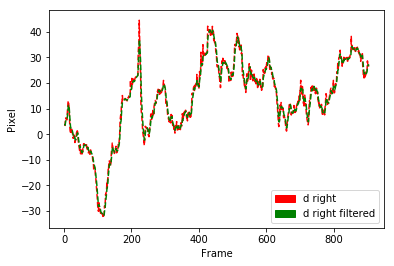

In [21]:
red_patch = mpatches.Patch(color='red', label='d right')
green_patch = mpatches.Patch(color='green', label='d right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_right, 'r--', frame, plot_d_right_filtered, 'g--')
plt.show()

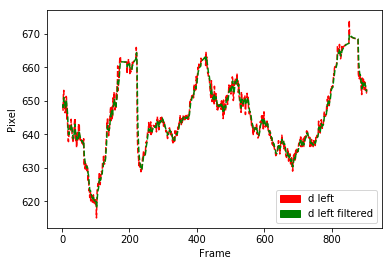

In [22]:
red_patch = mpatches.Patch(color='red', label='d left')
green_patch = mpatches.Patch(color='green', label='d left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_left, 'r--', frame, plot_d_left_filtered, 'g--')
plt.show()

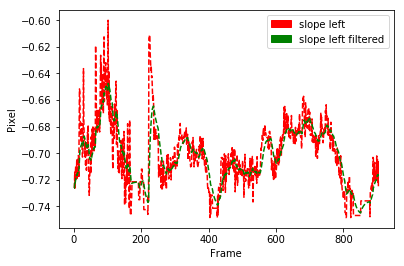

In [23]:
red_patch = mpatches.Patch(color='red', label='slope left')
green_patch = mpatches.Patch(color='green', label='slope left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_left, 'r--', frame, plot_slope_left_filtered, 'g--')
plt.show()

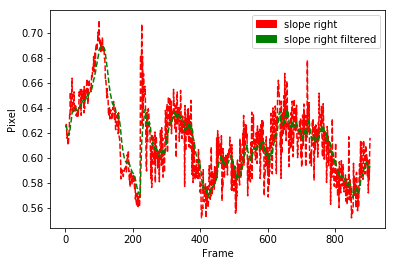

In [24]:
red_patch = mpatches.Patch(color='red', label='slope right')
green_patch = mpatches.Patch(color='green', label='slope right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_right, 'r--', frame, plot_slope_right_filtered, 'g--')
plt.show()

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')

print('Height: ' , clip3.h, ' Width: ', clip3.w)

challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Height:  720  Width:  1280
--------------------------------------------
right slope average:  0.595755032206
update right slope average:  0.5951643537001668
update right slope average:  0.5951643537001668
left slope average:  -0.694047796488
update left slope average:  -0.7148766741586097
update left slope average:  -0.7148766741586097
update d right mean:  0.5951643537001668
predict d right mean:  28.771623882646047
d_right:  31.7436291938
filtered_d_right:  28.771623882646047
update d left mean:  -0.7148766741586097
predict d left mean:  742.6240464617266
d_left:  882.385973114
filtered_d_left:  742.6240464617266
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 3/251 [00:00<00:10, 23.05it/s]

--------------------------------------------
right slope average:  0.595755032206
update right slope average:  0.5952205419469461
update right slope average:  0.5952205419469461
left slope average:  -0.694047796488
update left slope average:  -0.7128953287953881
update left slope average:  -0.7128953287953881
update d right mean:  0.5952205419469461
predict d right mean:  29.91098989268382
d_right:  31.6901700905
filtered_d_right:  29.91098989268382
update d left mean:  -0.7128953287953881
predict d left mean:  796.8256932967425
d_left:  881.464427371
filtered_d_left:  796.8256932967425
--------------------------------------------
right slope average:  0.590489771446
update right slope average:  0.5947705277721895
update right slope average:  0.5947705277721895
left slope average:  -0.67113902741
update left slope average:  -0.7089232638842511
update left slope average:  -0.7089232638842511
update d right mean:  0.5947705277721895
predict d right mean:  30.491079758673212
d_right:  31.

  3%|▎         | 7/251 [00:00<00:10, 23.95it/s]

--------------------------------------------
right slope average:  0.618632478632
update right slope average:  0.6073527997697964
update right slope average:  0.6073527997697964
left slope average:  -0.688384412041
update left slope average:  -0.6982117056059146
update left slope average:  -0.6982117056059146
update d right mean:  0.6073527997697964
predict d right mean:  23.120655780448395
d_right:  20.0474797264
filtered_d_right:  23.120655780448395
update d left mean:  -0.6982117056059146
predict d left mean:  873.0101750149544
d_left:  877.939556428
filtered_d_left:  873.0101750149544
--------------------------------------------
right slope average:  0.605165456013
update right slope average:  0.6071447288655958
update right slope average:  0.6071447288655958
left slope average:  -0.69747879367
update left slope average:  -0.6981419874152314
update left slope average:  -0.6981419874152314
update d right mean:  0.6071447288655958
predict d right mean:  21.46490985295905
d_right:  18

  4%|▍         | 10/251 [00:00<00:09, 24.38it/s]

878.027762479
filtered_d_left:  877.3859714481264
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.601258430514
update right slope average:  0.6087795179667862
update right slope average:  0.6087795179667862
left slope average:  -0.70921128393
update left slope average:  -0.7003043186234599
update left slope average:  -0.7003043186234599
update d right mean:  0.6087795179667862
predict d right mean:  18.702014288138006
d_right:  17.8843468378
filtered_d_right:  18.702014288138006
update d left mean:  -0.7003043186234599
predict d left mean:  878.0521950664138
d_left:  879.092538432
filtered_d_left:  878.0521950664138


  5%|▌         | 13/251 [00:00<00:10, 23.75it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.605306753247
update right slope average:  0.6084491714938026
update right slope average:  0.6084491714938026
left slope average:  -0.710408321052
update left slope average:  -0.7012654610660739
update left slope average:  -0.7012654610660739
update d right mean:  0.6084491714938026
predict d right mean:  18.4440750837131
d_right:  18.0412893935
filtered_d_right:  18.4440750837131
update d left mean:  -0.7012654610660739
predict d left mean:  878.573928637106
d_left:  879.388643162
filtered_d_left:  878.573928637106
Outlier slope... skipping
--------------------------------------------
right slope average:  0.602692735379
update right slope average:  0.6079015909575392
update right slope average:  0.6079015909575392
left slope average:  -0.718252203632
update left slope average:  -0.702881323627231
update left slope average:  -0.702881323627231
update d right mean:  0.6079015909575392
predict 

  6%|▋         | 16/251 [00:00<00:10, 23.45it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.585881067403
update right slope average:  0.6044084788415591
update right slope average:  0.6044084788415591
left slope average:  -0.720941635812
update left slope average:  -0.7028702492782973
update left slope average:  -0.7028702492782973
update d right mean:  0.6044084788415591
predict d right mean:  19.003813564299087
d_right:  19.5568738424
filtered_d_right:  19.003813564299087
update d left mean:  -0.7028702492782973
predict d left mean:  876.6861790804883
d_left:  879.718391343
filtered_d_left:  876.6861790804883
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.632925472747
update right slope average:  0.6071211556617518
update right slope average:  0.6071211556617518
left slope average:  -0.708078502553
update left slope average:  -0.703365683964664
update left slope average:  -0.703365683964664
update d right me

  8%|▊         | 19/251 [00:00<00:10, 23.07it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.609109109109
update right slope average:  0.6073102595783166
update right slope average:  0.6073102595783166
left slope average:  -0.711341123301
update left slope average:  -0.7041243470092547
update left slope average:  -0.7041243470092547
update d right mean:  0.6073102595783166
predict d right mean:  19.556537559979706
d_right:  20.2591025969
filtered_d_right:  19.556537559979706
update d left mean:  -0.7041243470092547
predict d left mean:  878.0489037572224
d_left:  879.22466962
filtered_d_left:  878.0489037572224
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.603449660979
update right slope average:  0.6069430204377727
update right slope average:  0.6069430204377727
left slope average:  -0.697022720709
update left slope average:  -0.703448805361525
update left slope average:  -0.703448805361525
update d right mea

  9%|▉         | 22/251 [00:00<00:09, 23.71it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.591770186335
update right slope average:  0.6036954815207146
update right slope average:  0.6036954815207146
left slope average:  -0.706287167996
update left slope average:  -0.7062782236774509
update left slope average:  -0.7062782236774509
update d right mean:  0.6036954815207146
predict d right mean:  23.257730947452643
d_right:  24.3337117706
filtered_d_right:  23.257730947452643
update d left mean:  -0.7062782236774509
predict d left mean:  879.805689769346
d_left:  877.999193378
filtered_d_left:  879.805689769346
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.602588832886
update right slope average:  0.6035902116556704
update right slope average:  0.6035902116556704
left slope average:  -0.707835308124
update left slope average:  -0.7064263412139202
update left slope average:  -0.70642634

 10%|█         | 26/251 [00:01<00:08, 25.89it/s]

 0.6023135624002297
update right slope average:  0.6023135624002297
left slope average:  -0.664589646465
update left slope average:  -0.7014456377520984
update left slope average:  -0.7014456377520984
update d right mean:  0.6023135624002297
predict d right mean:  25.884392708642057
d_right:  25.1400088841
filtered_d_right:  25.884392708642057
update d left mean:  -0.7014456377520984
predict d left mean:  877.023787616432
d_left:  875.96378364
filtered_d_left:  877.023787616432
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.653846153846
update right slope average:  0.6072155961405642
update right slope average:  0.6072155961405642
left slope average:  -0.665289379735
update left slope average:  -0.6980062765293876
update left slope average:  -0.6980062765293876
update d right mean:  0.6072155961405642
predict d right mean:  23.843837907497175
d_right:  20.657403

 13%|█▎        | 33/251 [00:01<00:07, 29.14it/s]


update left slope average:  -0.6962566414379735
update d right mean:  0.6139642644932716
predict d right mean:  20.664882491438757
d_right:  15.7007757197
filtered_d_right:  20.664882491438757
update d left mean:  -0.6962566414379735
predict d left mean:  874.2878366332043
d_left:  872.092920622
filtered_d_left:  874.2878366332043
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.639971509972
update right slope average:  0.6164382016901089
update right slope average:  0.6164382016901089
left slope average:  -0.682146535463
update left slope average:  -0.6949144187080424
update left slope average:  -0.6949144187080424
update d right mean:  0.6164382016901089
predict d right mean:  17.661955746009564
d_right:  12.97272704
filtered_d_right:  17.661955746009564
update d left mean:  -0.6949144187080424
predict d left mean:  872.9815508595615
d_left:  870.941716635
filtered_d_left:  872.9815508595615
Outlier slope... ski

 15%|█▍        | 37/251 [00:01<00:07, 29.47it/s]

--------------------------------------------
right slope average:  0.630214668649
update right slope average:  0.6206727444376561
update right slope average:  0.6206727444376561
left slope average:  -0.676651263479
update left slope average:  -0.681328611299387
update left slope average:  -0.681328611299387
update d right mean:  0.6206727444376561
predict d right mean:  12.00557947457295
d_right:  10.8905303644
filtered_d_right:  12.00557947457295
update d left mean:  -0.681328611299387
predict d left mean:  867.9951054249423
d_left:  868.819231892
filtered_d_left:  867.9951054249423
--------------------------------------------
right slope average:  0.616973515218
update right slope average:  0.6203208555467558
update right slope average:  0.6203208555467558
left slope average:  -0.679842370165
update left slope average:  -0.6811872327274544
update left slope average:  -0.6811872327274544
update d right mean:  0.6203208555467558
predict d right mean:  11.99788401074148
d_right:  11.985

 16%|█▋        | 41/251 [00:01<00:06, 31.02it/s]

Outlier slope... skipping
--------------------------------------------
right slope average:  0.604587973401
update right slope average:  0.6166499273067887
update right slope average:  0.6166499273067887
left slope average:  -0.683915158021
update left slope average:  -0.6804025422695477
update left slope average:  -0.6804025422695477
update d right mean:  0.6166499273067887
predict d right mean:  13.702806286861014
d_right:  14.8863772044
filtered_d_right:  13.702806286861014
update d left mean:  -0.6804025422695477
predict d left mean:  866.5958659177969
d_left:  867.933334888
filtered_d_left:  866.5958659177969
--------------------------------------------
right slope average:  0.606449468085
update right slope average:  0.6156796094192425
update right slope average:  0.6156796094192425
left slope average:  -0.674446576407
update left slope average:  -0.6798359814816375
update left slope average:  -0.6798359814816375
update d right mean:  0.6156796094192425
predict d right mean:  14.

 18%|█▊        | 45/251 [00:01<00:06, 30.34it/s]

--------------------------------------------
right slope average:  0.617011081162
update right slope average:  0.6158062655648832
update right slope average:  0.6158062655648832
left slope average:  -0.672659174961
update left slope average:  -0.6791532883213135
update left slope average:  -0.6791532883213135
update d right mean:  0.6158062655648832
predict d right mean:  15.036274898888857
d_right:  16.2640797402
filtered_d_right:  15.036274898888857
update d left mean:  -0.6791532883213135
predict d left mean:  866.8172739908636
d_left:  867.725842766
filtered_d_left:  866.8172739908636
--------------------------------------------
right slope average:  0.610061853007
update right slope average:  0.6152598287685516
update right slope average:  0.6152598287685516
left slope average:  -0.666626752668
update left slope average:  -0.677961702594719
update left slope average:  -0.677961702594719
update d right mean:  0.6152598287685516
predict d right mean:  14.955065197313301
d_right:  14

 20%|█▉        | 49/251 [00:02<00:12, 16.05it/s]

--------------------------------------------
right slope average:  0.590515547031
update right slope average:  0.6079050730078509
update right slope average:  0.6079050730078509
left slope average:  -0.70548580539
update left slope average:  -0.6831731131072507
update left slope average:  -0.6831731131072507
update d right mean:  0.6079050730078509
predict d right mean:  18.414270393099446
d_right:  20.4253579419
filtered_d_right:  18.414270393099446
update d left mean:  -0.6831731131072507
predict d left mean:  870.8949012065683
d_left:  873.465881873
filtered_d_left:  870.8949012065683
--------------------------------------------
right slope average:  0.592499877878
update right slope average:  0.6064396550231274
update right slope average:  0.6064396550231274
left slope average:  -0.698718976849
update left slope average:  -0.6846519121826496
update left slope average:  -0.6846519121826496
update d right mean:  0.6064396550231274
predict d right mean:  19.292431664251385
d_right:  2

 21%|██        | 52/251 [00:02<00:11, 17.64it/s]

--------------------------------------------
right slope average:  0.630651147099
update right slope average:  0.6124454367191602
update right slope average:  0.6124454367191602
left slope average:  -0.704093222324
update left slope average:  -0.6867316132387598
update left slope average:  -0.6867316132387598
update d right mean:  0.6124454367191602
predict d right mean:  19.480814554996204
d_right:  18.3893109656
filtered_d_right:  19.480814554996204
update d left mean:  -0.6867316132387598
predict d left mean:  872.2229768465761
d_left:  875.123998201
filtered_d_left:  872.2229768465761
--------------------------------------------
right slope average:  0.598864161049
update right slope average:  0.6111535189307524
update right slope average:  0.6111535189307524
left slope average:  -0.693355276873
update left slope average:  -0.6873616887251016
update left slope average:  -0.6873616887251016
update d right mean:  0.6111535189307524
predict d right mean:  19.324920660907058
d_right:  

 22%|██▏       | 55/251 [00:02<00:14, 13.83it/s]

--------------------------------------------
right slope average:  0.611696723159
update right slope average:  0.6112051911905636
update right slope average:  0.6112051911905636
left slope average:  -0.696173804175
update left slope average:  -0.6881999405197227
update left slope average:  -0.6881999405197227
update d right mean:  0.6112051911905636
predict d right mean:  19.13099140130281
d_right:  18.8281606205
filtered_d_right:  19.13099140130281
update d left mean:  -0.6881999405197227
predict d left mean:  872.7662951490671
d_left:  873.583415662
filtered_d_left:  872.7662951490671
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.603362391034
update right slope average:  0.6104591454375888
update right slope average:  0.6104591454375888
left slope average:  -0.665195571059
update left slope average:  -0.6860116516697021
update left slope average:  -0.6860116516697021
update d right mean:  0.6104591454375888
pr

 24%|██▎       | 59/251 [00:02<00:15, 12.54it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.602562178388
update right slope average:  0.609408999007088
update right slope average:  0.609408999007088
left slope average:  -0.65369256677
update left slope average:  -0.6816770254328985
update left slope average:  -0.6816770254328985
update d right mean:  0.609408999007088
predict d right mean:  18.547769869598554
d_right:  18.0387444219
filtered_d_right:  18.547769869598554
update d left mean:  -0.6816770254328985
predict d left mean:  870.0900047604695
d_left:  868.338900897
filtered_d_left:  870.0900047604695
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.601574477549
update right slope average:  0.6086637407647033
update right slope average:  0.6086637407647033
left slope average:  -0.674198875162
update left slope average:  -0.6809656669718932
update left slope average:  -0.6809656669

 25%|██▌       | 63/251 [00:03<00:14, 13.18it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.591549440058
update right slope average:  0.6055426036193946
update right slope average:  0.6055426036193946
left slope average:  -0.670969745702
update left slope average:  -0.6780542158126024
update left slope average:  -0.6780542158126024
update d right mean:  0.6055426036193946
predict d right mean:  19.891332796862628
d_right:  20.6418853648
filtered_d_right:  19.891332796862628
update d left mean:  -0.6780542158126024
predict d left mean:  868.1257030225785
d_left:  867.169359417
filtered_d_left:  868.1257030225785
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.606022727273
update right slope average:  0.605588275344455
update right slope average:  0.605588275344455
left slope average:  -0.688687791772
update left slope average:  -0.6790657338960394
update left s

 26%|██▌       | 65/251 [00:03<00:13, 14.01it/s]

--------------------------------------------
right slope average:  0.640866873065
update right slope average:  0.6132759930396461
update right slope average:  0.6132759930396461
left slope average:  -0.686819223544
update left slope average:  -0.6793911541638861
update left slope average:  -0.6793911541638861
update d right mean:  0.6132759930396461
predict d right mean:  16.223188510807265
d_right:  12.4261015961
filtered_d_right:  16.223188510807265
update d left mean:  -0.6793911541638861
predict d left mean:  867.4705277129875
d_left:  867.609641567
filtered_d_left:  867.4705277129875
--------------------------------------------
right slope average:  0.627561327561
update right slope average:  0.6146348843713721
update right slope average:  0.6146348843713721
left slope average:  -0.678678502778
update left slope average:  -0.6793233632564432
update left slope average:  -0.6793233632564432
update d right mean:  0.6146348843713721
predict d right mean:  14.208320588721804
d_right:  

 27%|██▋       | 69/251 [00:03<00:13, 13.91it/s]

 -0.6803480817452995
update d right mean:  0.6148552028912714
predict d right mean:  11.939307672407436
d_right:  10.1928844796
filtered_d_right:  11.939307672407436
update d left mean:  -0.6803480817452995
predict d left mean:  869.0653124969383
d_left:  870.559416539
filtered_d_left:  869.0653124969383
--------------------------------------------
right slope average:  0.61866151414
update right slope average:  0.6152172779517866
update right slope average:  0.6152172779517866
left slope average:  -0.69657754723
update left slope average:  -0.6818919083831606
update left slope average:  -0.6818919083831606
update d right mean:  0.6152172779517866
predict d right mean:  11.194314651183152
d_right:  10.0309687034
filtered_d_right:  11.194314651183152
update d left mean:  -0.6818919083831606
predict d left mean:  870.1148327021086
d_left:  871.753713931
filtered_d_left:  870.1148327021086
--------------------------------------------
right slope average:  0.614417730174
update right slope

 28%|██▊       | 71/251 [00:03<00:12, 14.83it/s]

--------------------------------------------
right slope average:  0.608922196637
update right slope average:  0.6145496368214922
update right slope average:  0.6145496368214922
left slope average:  -0.694237175754
update left slope average:  -0.6837394179834942
update left slope average:  -0.6837394179834942
update d right mean:  0.6145496368214922
predict d right mean:  10.129016366509976
d_right:  10.0665610354
filtered_d_right:  10.129016366509976
update d left mean:  -0.6837394179834942
predict d left mean:  872.1357476436153
d_left:  873.687752202
filtered_d_left:  872.1357476436153
--------------------------------------------
right slope average:  0.58728546415
update right slope average:  0.6119561345234785
update right slope average:  0.6119561345234785
left slope average:  -0.69454083397
update left slope average:  -0.6847669018364348
update left slope average:  -0.6847669018364348
update d right mean:  0.6119561345234785
predict d right mean:  10.287355091597266
d_right:  10

 30%|██▉       | 75/251 [00:04<00:13, 13.16it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.596674876847
update right slope average:  0.6074082972784685
update right slope average:  0.6074082972784685
left slope average:  -0.696072655253
update left slope average:  -0.6880250786091094
update left slope average:  -0.6880250786091094
update d right mean:  0.6074082972784685
predict d right mean:  12.208308902693036
d_right:  14.0659598866
filtered_d_right:  12.208308902693036
update d left mean:  -0.6880250786091094
predict d left mean:  876.5148721197207
d_left:  878.080967427
filtered_d_left:  876.5148721197207
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.578547422757
update right slope average:  0.6046629088415538
update right slope average:  0.6046629088415538
left slope average:  -0.697611135125
update left slope average:  -0.6889369514872
update left sl

 31%|███▏      | 79/251 [00:04<00:11, 15.00it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.57426428018
update right slope average:  0.5995577464025318
update right slope average:  0.5995577464025318
left slope average:  -0.693398945954
update left slope average:  -0.6892700851953962
update left slope average:  -0.6892700851953962
update d right mean:  0.5995577464025318
predict d right mean:  19.47256939567634
d_right:  22.7069412631
filtered_d_right:  19.47256939567634
update d left mean:  -0.6892700851953962
predict d left mean:  878.9728407487042
d_left:  880.075708624
filtered_d_left:  878.9728407487042
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.594117647059
update right slope average:  0.5990402573769389
update right slope average:  0.5990402573769389
left slope average:  -0.678752194664
update lef

 32%|███▏      | 81/251 [00:04<00:11, 14.47it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.5908566151
update right slope average:  0.5973602648340994
update right slope average:  0.5973602648340994
left slope average:  -0.702297432859
update left slope average:  -0.6910158748070744
update left slope average:  -0.6910158748070744
update d right mean:  0.5973602648340994
predict d right mean:  22.99000641337387
d_right:  24.6480444301
filtered_d_right:  22.99000641337387
update d left mean:  -0.6910158748070744
predict d left mean:  879.7346401402517
d_left:  880.510204078
filtered_d_left:  879.7346401402517
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.554373522459
update right slope average:  0.593271154

 34%|███▍      | 85/251 [00:04<00:10, 15.60it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.558166299307
update right slope average:  0.5878931120071469
update right slope average:  0.5878931120071469
left slope average:  -0.729003127236
update left slope average:  -0.7012941600480646
update left slope average:  -0.7012941600480646
update d right mean:  0.5878931120071469
predict d right mean:  27.80205925709827
d_right:  29.7128385306
filtered_d_right:  27.80205925709827
update d left mean:  -0.7012941600480646
predict d left mean:  883.9450061753932
d_left:  886.064446192
filtered_d_left:  883.9450061753932
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
----------------

 35%|███▌      | 89/251 [00:05<00:12, 13.07it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.578937235271
update right slope average:  0.588008768104479
update right slope average:  0.588008768104479
left slope average:  -0.727819496258
update left slope average:  -0.7082336206198382
update left slope average:  -0.7082336206198382
update d right mean:  0.588008768104479
predict d right mean:  29.996761258999495
d_right:  30.4009328833
filtered_d_right:  29.996761258999495
update d left mean:  -0.7082336206198382
predict d left mean:  883.109

 37%|███▋      | 93/251 [00:05<00:10, 14.50it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.581947558937
update right slope average:  0.58689200377993
update right slope average:  0.58689200377993
left slope average:  -0.555555555556
update left slope average:  -0.6953960087780336
update left slope average:  -0.6953960087780336
update d right mean:  0.58689200377993
predict d right mean:  31.569396116568313
d_right:  33.7718874739
filtered_d_right:  31.569396116568313
update d left mean:  -0.6953960087780336
predict d left mean:  847.3675313184322
d_left:  790.843110396
filtered_d_left:  847.3675313184322
Outlier slope... ski

 38%|███▊      | 95/251 [00:05<00:10, 15.21it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.563003667005
update right slope average:  0.5817196455474863
update right slope average:  0.5817196455474863
left slope average:  -0.739130434783
update left slope average:  -0.6968713037432548
update left slope average:  -0.6968713037432548
update d right mean:  0.5817196455474863
predict d right mean:  33.87057284789135
d_right:  34.7045832396
filtered_d_right:  33.87057284789135
update d left mea

 39%|███▉      | 99/251 [00:05<00:11, 13.49it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.555555555556
update right slope average:  0.5753852332108046
update right slope average:  0.5753852332108046
left slope average:  -0.664511494253
update left slope average:  -0.6972775422445351


 41%|████      | 103/251 [00:06<00:09, 15.41it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.555555555556
update right slope average:  0.5702475763978995
update right slope average:  0.5702475763978995
left slope average:  -0.664511494253
update left slope average:  -0.6887882106163041
update left slope average:  -0.6887882106163041
update d right mean:  0.5702475763978995
predict d right mean:  38.81645535952139
d_right:  39.4764446346
filtered_d_right:  38.81645535952139
update d left mean:  -0.6887882106163041
predict d left mean:  858.067125909387
d_left:  857.12315259
filtered_d_left:  858.067125909387
Outlier slope... skipping
Outlier slope... skipping
Outlier sl

 43%|████▎     | 107/251 [00:06<00:10, 13.95it/s]

left slope average:  -0.736842105263
update left slope average:  -0.6893788174958929
update left slope average:  -0.6893788174958929
update d right mean:  0.5664410313653314
predict d right mean:  39.861245988237656
d_right:  40.3524463679
filtered_d_right:  39.861245988237656
update d left mean:  -0.6893788174958929
predict d left mean:  858.2109592779128
d_left:  860.067928755
filtered_d_left:  858.2109592779128
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier sl

 43%|████▎     | 109/251 [00:06<00:10, 13.59it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.570958646617
update right slope average:  0.563633233797271
update right slope average:  0.563633233797271
left slope average:  -0.679418042917
update left slope average:  -0.6856245021582503
update left slope average:  

 45%|████▌     | 113/251 [00:06<00:11, 12.43it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.631152177126
update right slope average:  0.5784874080448844
update right slope average:  0.5784874080448844
left slope average:  -0.745098039216
update left slope average:  -0.6959177622596672
update left slope average:  -0.6959177622596672
update d right mean:  0.5784874080448844
predict d right mean:  44.56648694838138
d_right:  42.2505832762
filtered_d_right:  44.56648694838138
update d left mean:  -0.6959177622596672
predict d left mean:  867.1484451615805
d_left:  869.095395578
filtered_d_left:  867.1484451615805
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.620192307692
update right slope average:  0.5824545833697168
update right slope average:  0.58

 46%|████▌     | 115/251 [00:07<00:11, 12.30it/s]

 39.90977020275682
d_right:  40.9055051313
filtered_d_right:  39.90977020275682
update d left mean:  -0.6996151438425641
predict d left mean:  861.941607628659
d_left:  862.09999038
filtered_d_left:  861.941607628659
--------------------------------------------
right slope average:  0.582371794872
update right slope average:  0.5800519596244254
update right slope average:  0.5800519596244254
left slope average:  -0.745454545455
update left slope average:  -0.7039756133441701
update left slope average:  -0.7039756133441701
update d right mean:  0.5800519596244254
predict d right mean:  38.443294558503766
d_right:  36.1533153913
filtered_d_right:  38.443294558503766
update d left mean:  -0.7039756133441701
predict d left mean:  864.5144718857925
d_left:  868.532135303
filtered_d_left:  864.5144718857925
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  

 47%|████▋     | 117/251 [00:07<00:11, 12.13it/s]

0.574275362319
update right slope average:  0.5795024612564651
update right slope average:  0.5795024612564651
left slope average:  -0.745454545455
update left slope average:  -0.7079212935246725
update left slope average:  -0.7079212935246725
update d right mean:  0.5795024612564651
predict d right mean:  38.59150438260992
d_right:  38.8229418503
filtered_d_right:  38.59150438260992
update d left mean:  -0.7079212935246725
predict d left mean:  865.4450891639184
d_left:  866.898297192
filtered_d_left:  865.4450891639184
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.622641509434
update right slope average:  0.5836060598483176
update right slope average:  0.5836060598483176
left slope average:  -0.745454545455
update left slope average:  -0.7114916411858759
update left slope average:  -0.7114916411858759
update d right mean:  0.5836060598483176
predict d right mean:  37.48404851

 47%|████▋     | 119/251 [00:07<00:11, 11.61it/s]

update right slope average:  0.5843382171773058
left slope average:  -0.745454545455
update left slope average:  -0.717645756566408
update left slope average:  -0.717645756566408
update d right mean:  0.5843382171773058
predict d right mean:  37.28732860752142
d_right:  37.039960278
filtered_d_right:  37.28732860752142
update d left mean:  -0.717645756566408
predict d left mean:  867.7245683460538
d_left:  868.79137707
filtered_d_left:  867.7245683460538
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.583029612124
update right slope average:  0.5842137362237592
update right slope average:  0.5842137362237592
left slope average:  -0.745454545455
update left slope average:  -0.720291065439542
update left slope average:  -0.720291065439542
update d right mean:  0.5842137362237592
predict d right mean:  37.32075326762532
d_right:  37.3729476396
filtered_d_ri

 48%|████▊     | 121/251 [00:07<00:13,  9.62it/s]

--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.584309714062
update right slope average:  0.5842228661081256
update right slope average:  0.5842228661081256
left slope average:  -0.745454545455
update left slope average:  -0.722684739512526
update left slope average:  -0.722684739512526
update d right mean:  0.5842228661081256
predict d right mean:  37.318301463461715
d_right:  37.3144728418
filtered_d_right:  37.318301463461715
update d left mean:  -0.722684739512526
predict d left mean:  868.8979601607324
d_left:  869.767342033
filtered_d_left:  868.8979601607324
--------------------------------------------

 50%|████▉     | 125/251 [00:08<00:11, 10.82it/s]


No detections on right or left line - using previous results
right slope average:  0.589753807836
update right slope average:  0.584748996508424
update right slope average:  0.584748996508424
left slope average:  -0.745454545455
update left slope average:  -0.7248507155260897
update left slope average:  -0.7248507155260897
update d right mean:  0.584748996508424
predict d right mean:  37.17701200510645
d_right:  36.956381054
filtered_d_right:  37.17701200510645
update d left mean:  -0.7248507155260897
predict d left mean:  869.4007248131852
d_left:  870.18581837
filtered_d_left:  869.4007248131852
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.591071933296
update right slope average:  0.5853504653769457
update right slope average:  0.5853504653769457
left slope average:  -0.745454545455
update left slope average:  -0.7268106532403689
update left slope average:  -0.7268106532403689
update d right mean:  

 51%|█████     | 127/251 [00:08<00:11, 11.20it/s]

--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.655589508531
update right slope average:  0.6018457293116268
update right slope average:  0.6018457293116268
left slope average:  -0.745454545455
update left slope average:  -0.7316410857626988
update left slope average:  -0.7316410857626988
update d right mean:  0.6018457293116268
predict d right mean:  32.61316167229715
d_right:  30.2729892009
filtered_d_right:  32.61316167229715
update d left mean:  -0.7316410857626988
predict d left mean:  870.9706905275001
d_left:  871.493739525
filtered_d_left:  870.9706905275001
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.614825581395
update right slope average:  0.6030804367283056
update right slope average:  0.6030804367283056
left slope average:  -0.745454545455
update left slope average:  -0.7329550900380561
update left slope ave

 53%|█████▎    | 132/251 [00:08<00:12,  9.27it/s]

--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.633410931174
update right slope average:  0.6102949850964092
update right slope average:  0.6102949850964092
left slope average:  -0.745454545455
update left slope average:  -0.7361935648834167
update left slope average:  -0.7361935648834167
update d right mean:  0.6102949850964092
predict d right mean:  30.3912842120145
d_right:  29.3965512036
filtered_d_right:  30.3912842120145
update d left mean:  -0.7361935648834167
predict d left mean:  872.0180268049497
d_left:  872.367231119
filtered_d_left:  872.0180268049497
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.622112534783
update right slope average:  0.611419128588242
update right slope average:  0.611419128588242
left slope average:  -0.697799916978
update left slope average:  -0.7325413721221741
update left slope average:  -0.732

 54%|█████▍    | 136/251 [00:09<00:09, 11.57it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.627869640593
update right slope average:  0.6148168517358091
update right slope average:  0.6148168517358091
left slope average:  -0.671270264049
update left slope average:  -0.7168686202289697
update left slope average:  -0.7168686202289697
update d right mean:  0.6148168517358091
predict d right mean:  18.75006250013914
d_right:  15.6361873706
filtered_d_right:  18.75006250013914
update d left mean:  -0.7168686202289697
predict d left mean:  866.1922899803332
d_left:  861.564656966
filtered_d_left:  866.1922899803332
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.623032171512
update right slope average:  0.6155983333884786
update right slope average:  0.61559833338

 56%|█████▌    | 140/251 [00:09<00:11,  9.66it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.657358156028
update right slope average:  0.6195175060198982
update right slope average:  0.6195175060198982
left slope average:  -0.676923076923
update left slope average:  -0.6979318224747865
update left slope average:  -0.6979318224747865
update d right mean:  0.6195175060198982
predict d right mean:  17.69155719714456
d_right:  17.7070847122
filtered_d_right:  17.69155719714456
update d left mean:  -0.6979318224747865
predict d left mean:  856.9409779154973
d_left:  855.009899056
filtered_d_left:  856.9409779154973
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope...

 57%|█████▋    | 142/251 [00:09<00:10, 10.31it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.616319444444
update right slope average:  0.6207831130993011
update right slope average:  0.6207831130993011
left slope average:  -0.643939393939
update left slope average:  -0.6805405929982011
update left slope average:  -0.6805405929982011
update d right mean:  0.6207831130993011
predict d right mean:  16.417564386902136
d_right:  16.2208367043
filtered_d_right:  16.417564386902136
update d left mean:  -0.6805405929982011
predict d left mean:  856.4089455733639
d_left:  853.076420632
filtered_d_left:  856.4089455733639
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope.

 58%|█████▊    | 146/251 [00:10<00:09, 11.61it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.603935620644
update right slope average:  0.6192479315435881
update right slope average:  0.6192479315435881
left slope average:  -0.587046757908
update left slope average:  -0.6523372540071557
update left slope average:  -0.6523372540071557
update d right mean:  0.6192479315435881
predict d right mean:  15.794658862239231
d_right:  15.590044112
filtered_d_right:  15.794658862239231
update d left mean:  -0.6

 59%|█████▉    | 148/251 [00:10<00:08, 11.91it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slop

 61%|██████    | 152/251 [00:10<00:08, 11.52it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.612244897959
update right slope average:  0.6120453148798705
update right slope average:  0.6120453148798705
left slope average:  -0.606824471954
update left slope average:  -0.627752407077907
update left slope average:  -0.627752407077907
update d right mean:  0.6120453148798705


 61%|██████▏   | 154/251 [00:10<00:07, 12.35it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.627980335528
update right slope average:  0.6092238143220416
update right slope average:  0.6092238143220416
left slope average:  -0.61951925838
update left slope average:  -0.6254349959335177
update left slope average:  -0.6254349959335177
update d right mean:  0.6092238143220416
predict d right mean:  28.350898267816888
d_right:  29.0460727945
filtered_d_right:  28.350898267816888
update d left mean:  -0.6254349959335177
predict d left mean:  829.6460798510324
d_left:  827.394224977
filtered_d_left:  829.6460798510324
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
---------------

 62%|██████▏   | 156/251 [00:10<00:07, 12.35it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.635116222054
update right slope average:  0.6101808893877978
update right slope average:  0.6101808893877978
left slope average:  -0.631836133792
update left slope average:  -0.6267167536789758
update left slope average:  -0.6267167536789758
update d right mean:  0.6101808893877978
predict d right mean:  29.89997378102881
d_right:  31.0757107303
filtered_d_right:  29.89997378102881
update d left mean:  -0.6267167536789758
predict d left mean:  829.0022305091545
d_left:  827.794460661
filtered_d_left:  829.0022305091545
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.631012430193
update right slope average:  0.6121624880814367
update right slope average:  0.6121624880814367
left slope average:  -0.623010539248
update left slope average:  -0.6263642003203944
update left s

 64%|██████▎   | 160/251 [00:11<00:07, 11.58it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.655913978495
update right slope average:  0.6259971161067237
update right slope average:  0.6259971161067237
left slope average:  -0.627636352717
update left slope average:  -0.6262603705449068
update left slope average:  -0.6262603705449068
update d right mean:  0.6259971161067237
predict d right mean:  14.52125997830349
d_right:  5.99676890304
filtered_d_right:  14.52125997830349
update d left mean:  -0.6262603705449068
predict d left mean:  825.5924403390709
d_left:  822.641121738
filtered_d_left:  825.5924403390709
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.662148755899
update right slope average:  0.6294360380211189
update right slope average:  0.6294360380211189
left slope average:  -0.612726555603
update left slope average:  -0.6249729674546032
update left slope average:  -0.62497296

 65%|██████▍   | 162/251 [00:11<00:08, 11.11it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.667438271605
update right slope average:  0.6343428636861773
update right slope average:  0.6343428636861773
left slope average:  -0.606883885655
update left slope average:  -0.6219354405534083
update left slope average:  -0.6219354405534083
update d right mean:  0.6343428636861773
predict d right mean:  6.248881813971042
d_right:  4.04562278168
filtered_d_right:  6.248881813971042
update d left mean:  -0.6219354405534083
predict d left mean:  821.1840154360114
d_left:  819.70772632
filtered_d_left:  821.1840154360114
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.673187011332
update right slope average:  0.638037910200108
update right slope average:  0.638037910200108
left slope average:  -0

 65%|██████▌   | 164/251 [00:11<00:07, 11.97it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.652178569397
update right slope average:  0.6412027712408904
update right slope average:  0.6412027712408904
left slope average:  -0.591023730002
update left slope average:  -0.6145997955434327
update left slope average:  -0.6145997955434327
update d right mean:  0.6412027712408904
predict d right mean:  -0.7596045694146711
d_right:  -3.22421909535
filtered_d_right:  -0.7596045694146711
update d left mean:  -0.6145997955434327
predict d left mean:  822.3557453700997
d_left:  823.308695654
filtered_d_left:  822.3557453700997
--------------------------------------------
right slope average:  0.626832474903
update right slope average:  0.6398357979230388
update right slope average:  0.6398357979230388
left slope average:  -0.582181835596
update left slope average:  -0.6115160396329141
update left slope average:  -0.6115160396329141
update d right mean:  0.63983579792303

 67%|██████▋   | 168/251 [00:12<00:07, 11.06it/s]

Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.62468502168
update right slope average:  0.6383945815150843
update right slope average:  0.6383945815150843
left slope average:  -0.589259275021
update left slope average:  -0.6093988666358541
update left slope average:  -0.6093988666358541
update d right mean:  0.6383945815150843
predict d right mean:  -1.4512718715288173
d_right:  -0.874344795545
filtered_d_right:  -1.4512718715288173
update d left mean:  -0.6093988666358541
predict d left mean:  824.200857368715
d_left:  825.046525326
filtered_d_left:  824.200857368715
--------------------------------------------
right slope average:  0.624651398385
update right slope average:  0.6370872622921357
update right slope average:  0.6370872622921357
left slope average:  -0.591052859775
update left slope average:  -0.6076537041647059
update left slope average:  -0.6076537041647059
update d right mean:  0.6370872622921357

 69%|██████▊   | 172/251 [00:12<00:06, 13.09it/s]

--------------------------------------------
right slope average:  0.630952380952
update right slope average:  0.6341483052420204
update right slope average:  0.6341483052420204
left slope average:  -0.627086748278
update left slope average:  -0.6092144806219026
update left slope average:  -0.6092144806219026
update d right mean:  0.6341483052420204
predict d right mean:  5.5029887108282844
d_right:  7.94965241687
filtered_d_right:  5.5029887108282844
update d left mean:  -0.6092144806219026
predict d left mean:  832.7494383500857
d_left:  837.280827359
filtered_d_left:  832.7494383500857
Outlier slope... skipping
--------------------------------------------
right slope average:  0.608625840671
update right slope average:  0.6317204827911269
update right slope average:  0.6317204827911269
left slope average:  -0.649923104582
update left slope average:  -0.6130868852996789
update left slope average:  -0.6130868852996789
update d right mean:  0.6317204827911269
predict d right mean:  6.8

 70%|███████   | 176/251 [00:12<00:06, 11.53it/s]

--------------------------------------------
right slope average:  0.628415300546
update right slope average:  0.6325470178745399
update right slope average:  0.6325470178745399
left slope average:  -0.653801657982
update left slope average:  -0.6209866791275089
update left slope average:  -0.6209866791275089
update d right mean:  0.6325470178745399
predict d right mean:  5.689030322336275
d_right:  3.47677849432
filtered_d_right:  5.689030322336275
update d left mean:  -0.6209866791275089
predict d left mean:  839.4001203918224
d_left:  841.665912361
filtered_d_left:  839.4001203918224
--------------------------------------------
right slope average:  0.627333999334
update right slope average:  0.6320511298926299
update right slope average:  0.6320511298926299
left slope average:  -0.65684879877
update left slope average:  -0.6243980604603097
update left slope average:  -0.6243980604603097
update d right mean:  0.6320511298926299
predict d right mean:  4.260389045682142
d_right:  2.02

 71%|███████   | 178/251 [00:12<00:06, 11.99it/s]

filtered_d_left:  842.5910104285063
--------------------------------------------
right slope average:  0.606846539661
update right slope average:  0.6265827479692749
update right slope average:  0.6265827479692749
left slope average:  -0.670431147449
update left slope average:  -0.6364714202850665
update left slope average:  -0.6364714202850665
update d right mean:  0.6265827479692749
predict d right mean:  2.451906271609324
d_right:  3.81285248071
filtered_d_right:  2.451906271609324
update d left mean:  -0.6364714202850665
predict d left mean:  843.9709300215943
d_left:  846.125747344
filtered_d_left:  843.9709300215943
--------------------------------------------
right slope average:  0.617459376542
update right slope average:  0.6257148879740922
update right slope average:  0.6257148879740922
left slope average:  -0.666678599847
update left slope average:  -0.6393448758839354
update left slope average:  -0.6393448758839354
update d right mean:  0.6257148879740922
predict d right me

 72%|███████▏  | 180/251 [00:12<00:05, 12.24it/s]

--------------------------------------------
right slope average:  0.599867724868
update right slope average:  0.6210811923447322
update right slope average:  0.6210811923447322
left slope average:  -0.688712531806
update left slope average:  -0.6462528043896392
update left slope average:  -0.6462528043896392
update d right mean:  0.6210811923447322
predict d right mean:  5.1642740105749025
d_right:  8.21977788451
filtered_d_right:  5.1642740105749025
update d left mean:  -0.6462528043896392
predict d left mean:  850.4739030843665
d_left:  854.551417711
filtered_d_left:  850.4739030843665


 73%|███████▎  | 184/251 [00:13<00:06, 10.99it/s]

--------------------------------------------
right slope average:  0.609481915934
update right slope average:  0.6199778120811791
update right slope average:  0.6199778120811791
left slope average:  -0.679586961076
update left slope average:  -0.6494237134434019
update left slope average:  -0.6494237134434019
update d right mean:  0.6199778120811791
predict d right mean:  6.9925699605136025
d_right:  9.84755064379
filtered_d_right:  6.9925699605136025
update d left mean:  -0.6494237134434019
predict d left mean:  852.8181257497123
d_left:  856.478753247
filtered_d_left:  852.8181257497123
--------------------------------------------
right slope average:  0.598864809082
update right slope average:  0.6179694393182321
update right slope average:  0.6179694393182321
left slope average:  -0.683763397977
update left slope average:  -0.6526902732551934
update left slope average:  -0.6526902732551934
update d right mean:  0.6179694393182321
predict d right mean:  8.934589650393926
d_right:  1

 74%|███████▍  | 186/251 [00:13<00:06, 10.31it/s]


right slope average:  0.605339494288
update right slope average:  0.6136241799233457
update right slope average:  0.6136241799233457
left slope average:  -0.690312108324
update left slope average:  -0.6588694374477166
update left slope average:  -0.6588694374477166
update d right mean:  0.6136241799233457
predict d right mean:  11.841984350548183
d_right:  13.9381610604
filtered_d_right:  11.841984350548183
update d left mean:  -0.6588694374477166
predict d left mean:  857.913718213302
d_left:  860.864403533
filtered_d_left:  857.913718213302
--------------------------------------------
right slope average:  0.585684708666
update right slope average:  0.6109664399000448
update right slope average:  0.6109664399000448
left slope average:  -0.712654591762
update left slope average:  -0.6639857460550984
update left slope average:  -0.6639857460550984
update d right mean:  0.6109664399000448
predict d right mean:  13.227772654494135
d_right:  15.3917542785
filtered_d_right:  13.2277726544

 75%|███████▍  | 188/251 [00:13<00:05, 11.36it/s]

--------------------------------------------
right slope average:  0.606358707149
update right slope average:  0.6105281296816196
update right slope average:  0.6105281296816196
left slope average:  -0.699813676399
update left slope average:  -0.667393875133454
update left slope average:  -0.667393875133454
update d right mean:  0.6105281296816196
predict d right mean:  15.213470016191694
d_right:  18.3142413167
filtered_d_right:  15.213470016191694
update d left mean:  -0.667393875133454
predict d left mean:  864.2421782859701
d_left:  868.457970577
filtered_d_left:  864.2421782859701
Outlier slope... skipping
--------------------------------------------
right slope average:  0.581919404125
update right slope average:  0.6078067268953407
update right slope average:  0.6078067268953407
left slope average:  -0.710465141199
update left slope average:  -0.6714910259571804
update left slope average:  -0.6714910259571804
update d right mean:  0.6078067268953407
predict d right mean:  17.240

 76%|███████▋  | 192/251 [00:14<00:05, 10.18it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.584621491366
update right slope average:  0.6042257837270609
update right slope average:  0.6042257837270609
left slope average:  -0.677850635864
update left slope average:  -0.6759541933865953
update left slope average:  -0.6759541933865953
update d right mean:  0.6042257837270609
predict d right mean:  17.927475336394764
d_right:  18.0751723608
filtered_d_right:  17.927475336394764
update d left mean:  -0.6759541933865953
predict d left mean:  870.8750935970985
d_left:  871.411575192
filtered_d_left:  870.8750935970985
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.576037174262
update right slope average:  0.6015443444511532
update right slope average:  0.6015443444511532
left slope average

 77%|███████▋  | 194/251 [00:14<00:05, 10.65it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.66091954023
update right slope average:  0.6066246951834375
update right slope average:  0.6066246951834375
left slope average:  -0.703782072165
update left slope average:  -0.6826143792785794
update left slope average:  -0.6826143792785794
update d right mean:  0.6066246951834375
predict d right mean:  18.01015713055092
d_right:  15.6065537623
filtered_d_right:  18.01015713055092
update d left mean:  -0.6826143792785794
predict d left mean:  871.7507122338749
d_left:  873.088692907
filtered_d_left:  871.7507122338749
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.608823529412
update right slope average:  0.6068338591178377
update right slope average:  0.6068338591178377
left slope average:  -0.707134736639
update left slope average:  -0.68494

 78%|███████▊  | 196/251 [00:14<00:04, 11.14it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.577276844375
update right slope average:  0.6055859222491323
update right slope average:  0.6055859222491323
left slope average:  -0.708148000189
update left slope average:  -0.6886654366140543
update left slope average:  -0.6886654366140543
update d right mean:  0.6055859222491323
predict d right mean:  15.436577947535548
d_right:  15.0977616569
filtered_d_right:  15.436577947535548
update d left mean:  -0.6886654366140543
predict d left mean:  874.1114055364316
d_left:  874.388081162
filtered_d_left:  874.1114055364316
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.593092017613
update right slope average:  0.6043974405455229
update right slope average:  0.6043974405455229
left slope average:  -0.702116229252
update left slope average:  -0.6899449422142527
update left

 80%|████████  | 202/251 [00:15<00:04, 11.70it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.579180761099
update right slope average:  0.6011525285550828
update right slope average:  0.6011525285550828
left slope average:  -0.708846589548
update left slope average:  -0.6921481908601197
update left slope average:  -0.6921481908601197
update d right mean:  0.6011525285550828
predict d right mean:  17.753465716234867
d_right:  19.0070966498
filtered_d_right:  17.753465716234867
update d left mean:  -0.6921481908601197
predict d left mean:  876.7012757876995
d_left:  878.196226957
filtered_d_left:  876.7012757876995
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.576618041824
update right slope average:  0.5988186874191607
update right slope average:  0.5988186874191607
left slope average

 81%|████████▏ | 204/251 [00:15<00:04, 11.30it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.56467793298
update right slope average:  0.5914471860571358
update right slope average:  0.5914471860571358
left slope average:  -0.703296130161
update left slope average:  -0.6972287730633776
update left slope average:  -0.6972287730633776
update d right mean:  0.5914471860571358
predict d right mean:  23.188848777333142
d_right:  24.9470508444
filtered_d_right:  23.188848777333142
update d left mean:  -0.6972287730633776
predict d left mean:  878.2663066146348
d_left:  880.220739707
filtered_d_left:  878.2663066146348
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.590576923077
update right slope average:  0.5913644023590475
update right slope average:  0.5913644023590475
left slope average:  -0.729526239299
update left slope average:  -0.700

 83%|████████▎ | 208/251 [00:15<00:03, 12.18it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.606481481481
update right slope average:  0.5949368625513815
update right slope average:  0.5949368625513815
left slope average:  -0.715534076245
update left slope average:  -0.7026765545585969
update left slope average:  -0.7026765545585969
update d right mean:  0.5949368625513815
predict d right mean:  27.714972550434364
d_right:  29.7424923128
filtered_d_right:  27.714972550434364
update d left mean:  -0.7026765545585969
predict d left mean:  882.6727065352544
d_left:  884.576619776
filtered_d_left:  882.6727065352544
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.593236714976
update right slope average:  0.5947751361459169
update right slope average:  0.5947751361459169
left slope average

 84%|████████▎ | 210/251 [00:15<00:03, 11.76it/s]


update left slope average:  -0.7021476016024976
update left slope average:  -0.7021476016024976
update d right mean:  0.5953309593539305
predict d right mean:  28.772533300595494
d_right:  29.3136904841
filtered_d_right:  28.772533300595494
update d left mean:  -0.7021476016024976
predict d left mean:  883.2044189623076
d_left:  884.283298952
filtered_d_left:  883.2044189623076
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.584995973342
update right slope average:  0.594347844615989
update right slope average:  0.594347844615989
left slope average:  -0.731047993812
update left slope average:  -0.7048967491563622
update left slope average:  -0.7048967491563622
update d right mean:  0.594347844615989
predict d right mean:  28.7296136805572
d_right:  28.6625924272
filtered_d_right:  28.7296136805572
update d left mean:  -0.7048967491563622
predict d left mean:  88

 84%|████████▍ | 212/251 [00:16<00:03, 10.37it/s]

-0.727186998033
update left slope average:  -0.7070171073414754
update left slope average:  -0.7070171073414754
update d right mean:  0.5937277805823605
predict d right mean:  28.22338401228175
d_right:  27.4328796499
filtered_d_right:  28.22338401228175
update d left mean:  -0.7070171073414754
predict d left mean:  886.2582768669006
d_left:  888.897470206
filtered_d_left:  886.2582768669006
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.597511114321
update right slope average:  0.5940876699090467
update right slope average:  0.5940876699090467
left slope average:  -0.728178713522
update left slope average:  -0.7090301034782287
update left slope average:  -0.7090301034782287
update d right mean:  0.5940876699090467
predict d right mean:  27.300522447358507
d_right:  25.8594253748
filtered_d_right:  27.300522447

 86%|████████▌ | 216/251 [00:16<00:03, 10.97it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.584631132205
update right slope average:  0.5915603215571055
update right slope average:  0.5915603215571055
left slope average:  -0.730933355954
update left slope average:  -0.7129989967707617
update left slope average:  -0.7129989967707617
update d right mean:  0.5915603215571055
predict d right mean:  26.570116666296105
d_right:  26.8796284831
filtered_d_right:  26.570116666296105
update d left mean:  -0.7129989967707617
predict d left mean:  888.842567973974
d_left:  889.568546954
filtered_d_left:  888.842567973974
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier

 87%|████████▋ | 218/251 [00:16<00:03, 10.41it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.588744588745
update right slope average:  0.5889334535979293
update right slope average:  0.5889334535979293
left slope average:  -0.730933355954
update left slope average:  -0.7176455968943987
update left slope average:  -0.7176455968943987
update d right mean:  0.5889334535979293
predict d right mean:  27.285922797083327
d_right:  27.2943880839
filtered_d_right:  27.285922797083327
update d left mean:  -0.7176455968943987
predict d left mean:  889.9850223969135
d_left:  890.520554959
filtered_d_left:  889.9850223969135
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope 

 88%|████████▊ | 222/251 [00:16<00:02, 12.83it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.565217391304
update right slope average:  0.5867471984403203
update right slope average:  0.5867471984403203
left slope average:  -0.736111111111
update left slope average:  -0.720991568256316
update left slope average:  -0.720991568256316
update d right mean:  0.5867471984403203
predict d right mean:  29.783092785161354
d_right:  30.7435850794
filtered_d_right:  29.783092785161354
update d left mean:  -0.720991568256316
predict d left mean:  891.2898311931792
d_left:  891.89821312
filtered_d_left:  891.2898311931792
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
---------

 91%|█████████ | 228/251 [00:17<00:01, 11.83it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.577952570462
update right slope average:  0.5810427368333877
update right slope average:  0.5810427368333877
left slope average:  -0.646464646465
update left slope average:  -0.7066312215727786
update left slope average:  -0.7066312215727786
update d right mean:  0.5810427368333877
predict d right mean:  38.15458843041311
d_right:  39.5267346096
filtered_d_right:  38.15458843041311
update d left mean:  -0.7066312215727786
predict d left mean:  879.9367911344353
d_left:  863.355272563
filtered_d_left:  879.9367911344353
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope...

 92%|█████████▏| 230/251 [00:17<00:01, 13.14it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.587800897593
update right slope average:  0.5825755711242894
update right slope average:  0.5825755711242894
left slope average:  -0.712328767123
update left slope average:  -0.7100398572175916
update left slope average:  -0.7100398572175916
update d right mean:  0.5825755711242894
predict d right mean:  41.386638788880724
d_right:  41.9831041728
filtered_d_right:  41.386638788880724
update d left mean:  -0.7100398572175916
predict d left mean:  885.73435283107
d_left:  886.586981256
filtered_d_left:  885.73435283107
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.6

 93%|█████████▎| 234/251 [00:17<00:01, 11.61it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.586111111111
update right slope average:  0.5859155902353933
update right slope average:  0.5859155902353933
left slope average:  -0.741935483871
update left slope average:  -0.7198919588595784
update left slope average:  -0.7198919588595784
update d right mean:  0.5859155902353933
predict d right mean:  40.44125949655718
d_right:  40.4327317039
filtered_d_right:  40.44125949655718
update d left mean:  -0.7198919588595784
predict d left mean:  888.4755969918384
d_left:  889.358958901
filtered_d_left:  888.4755969918384
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier

 95%|█████████▍| 238/251 [00:18<00:01, 12.96it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
No detections on right or left line - using previous results
right slope average:  0.585470878006
update right slope average:  0.5838538781845077
update right slope average:  0.5838538781845077
left slope average:  -0.741935483871
update left slope average:  -0.7256031997795858
update left slope average:  -0.7256031997795858
update d right mean:  0.5838538781845077
predict d right mean:  40.98921440811369
d_right:  40.9185249002
filtered_d_right:  40.98921440811369
update d left mean:  -0.7256031997795858
predict d left mean:  889.8648369172043
d_left:  890.51584648
filtered_d_left:  889.8648369172043
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier 

 96%|█████████▌| 240/251 [00:18<00:00, 12.56it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.595029239766
update right slope average:  0.58190822286202
update right slope average:  0.58190822286202
left slope average:  -0.719779187221
update left slope average:  -0.7278644898433682
update left slope average:  -0.7278644898433682
update d right mean:  0.58190822286202
predict d right mean:  39.180867541885384
d_right:  37.3096052647
filtered_d_right:  39.180867541885384
update d left mean:  -0.7278644898433682
predict d left mean:  893.9540935933754
d_left:  897.371047099
filtered_d_left:  893.9540935933754
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.624943000456
update right slope average:  0.5860019027227512
update right slope a

 97%|█████████▋| 244/251 [00:18<00:00, 13.90it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.577873384477
update right slope average:  0.5852286780588871
update right slope average:  0.5852286780588871
left slope average:  -0.682765151515
update left slope average:  -0.72276576937297
update left slope average:  -0.72276576937297
update d right mean:  0.5852286780588871
predict d right mean:  37.39588716447119
d_right:  36.1749685331
filtered_d_right:  37.39588716447119
update d left mean:  -0.72276576937297
predict d left mean:  894.9403503538538
d_left:  895.211648446
filtered_d_left:  894.9403503538538
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.58516939114
update right slope average:  0.58522303839531

 99%|█████████▉| 248/251 [00:18<00:00, 13.75it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.575113058096
update right slope average:  0.5841208498857986
update right slope average:  0.5841208498857986
left slope average:  -0.689465641329
update left slope average:  -0.714795026456076
update left slope average:  -0.714795026456076
update d right mean:  0.5841208498857986
predict d right mean:  38.069303884203656
d_right:  39.2090113337
filtered_d_right:  38.069303884203656
update d left mean:  -0.714795026456076
predict d left mean:  891.1688791323713
d_left:  888.253426068
filtered_d_left:  891.1688791323713
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.568141011443
update right slope average:  0.5826007690008262
update right slope average:  0.5826007690008262
left slope average:  -0.720807352315
update lef

100%|██████████| 251/251 [00:19<00:00, 13.08it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.593103448276
update right slope average:  0.5835435034820757
update right slope average:  0.5835435034820757
left slope average:  -0.711787062065
update left slope average:  -0.714016177887054
update left slope average:  -0.714016177887054
update d right mean:  0.5835435034820757
predict d right mean:  40.27077461757965
d_right:  38.8553768837
filtered_d_right:  40.27077461757965
update d left mean:  -0.714016177887054
predict d left mean:  888.2020663851844
d_left:  886.86219916
filtered_d_left:  888.2020663851844
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
--------------------------------------------
right slope average:  0.573190789474
update right slope average:  0.5825587023698239
update right slope average:  0.5825587023698239
left slope average:  -0.

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.8 s, sys: 868 ms, total: 11.7 s
Wall time: 21.4 s


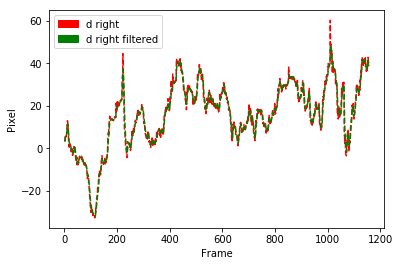

In [27]:
red_patch = mpatches.Patch(color='red', label='d right')
green_patch = mpatches.Patch(color='green', label='d right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_right, 'r--', frame, plot_d_right_filtered, 'g--')
plt.show()

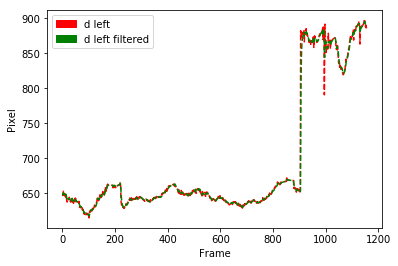

In [28]:
red_patch = mpatches.Patch(color='red', label='d left')
green_patch = mpatches.Patch(color='green', label='d left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_left, 'r--', frame, plot_d_left_filtered, 'g--')
plt.show()

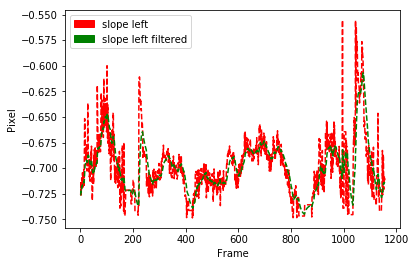

In [29]:
red_patch = mpatches.Patch(color='red', label='slope left')
green_patch = mpatches.Patch(color='green', label='slope left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_left, 'r--', frame, plot_slope_left_filtered, 'g--')
plt.show()

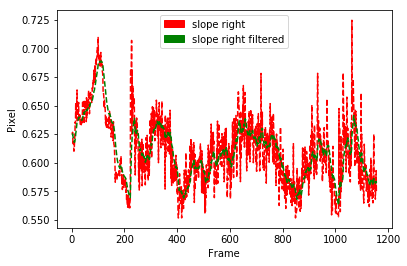

In [30]:
red_patch = mpatches.Patch(color='red', label='slope right')
green_patch = mpatches.Patch(color='green', label='slope right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_right, 'r--', frame, plot_slope_right_filtered, 'g--')
plt.show()

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))